# Modelo de Propensão a Churn


* Este notebook apresenta a construção de um estudo voltado à identificação do melhor modelo de machine learning para a detecção e categorização, em percentis, de clientes propensos à evasão (churn), utilizando dados financeiros fictícios de correntistas. A análise segue as etapas da metodologia CRISP-DM.

* A abordagem será estruturada em cinco das seis etapas da metodologia. A etapa de Deploy (Implantação) não será totalmente executada; no entanto, o modelo será salvo como se estivesse pronto para produção.
    * Etapas: 

        * **Compreensão do Negócio** – Definição do problema e dos objetivos do projeto. 🟧

        * **Compreensão dos Dados** – Exploração inicial para entender a estrutura e qualidade dos dados.🟧

        * **Preparação dos Dados** – Tratamento, limpeza e transformação dos dados para a modelagem.🟧

        * **Modelagem** – Aplicação de algoritmos de machine learning para detectar padrões de fraude.🟧

        * **Avaliação** – Medição do desempenho do modelo para garantir sua eficácia.🟧

        * **Deploy** (Implantação) – Integração do modelo em um ambiente operacional para uso real.❌

# 1.Compreensão do Negócio

* A predição de churn (evasão de clientes) é um desafio estratégico para bancos e instituições financeiras, pois clientes insatisfeitos podem afetar diretamente as receitas, a imagem da marca e a confiança do mercado. Muitos desses clientes insatisfeitos apresentam reclamações não resolvidas, que podem evoluir para ações judiciais, reclamações em órgãos como o Procon ou junto a reguladores do setor, com impactos significativos na reputação e na operação da instituição. Antecipar esses casos permite ações preventivas, fortalece a fidelização de clientes e protege a sustentabilidade financeira e regulatória do negócio. Por isso, modelos de predição de churn são ferramentas valiosas para a gestão proativa do relacionamento com o cliente e para garantir a sustentabilidade operacional e reputacional das instituições financeiras.

* Objetivo do Projeto:

    * 1- Desenvolver uma análise exploratória que forneça informações sobre o comportamento dos clientes em risco de churn, identificando padrões e fatores que contribuem para a evasão. ✅

    * 2- Desenvolver um modelo de Machine Learning capaz de identificar clientes com alta probabilidade de churn, separando a base de clientes em decis de probabilidade para permitir ações específicas em grupos de clientes com diferentes níveis de risco de evasão, a fim de otimizar as estratégias de retenção. ✅


        * Serão utilizadas cinco métricas fundamentais para avaliar a performance, que capturam diferentes aspectos da **qualidade das previsões probabilísticas e da discriminação** do modelo: 

            * **AUC-ROC >= 0.85** - ROC AUC (Área sob a Curva ROC) é uma métrica global que avalia a capacidade do modelo em distinguir classes independentemente do limiar. Mede o poder de discriminação entre clientes com maior e menor risco de churn, sendo essencial para priorizar ações com base nas probabilidades previstas. ✅

            * **Brier Score <= 0.10** – Mede a precisão das previsões probabilísticas, avaliando o quão bem calibradas e úteis são para decisões. Quanto menor o valor, mais confiáveis as probabilidades estimadas, o que é essencial em projetos de retenção de cliente, onde decisões baseadas em risco devem ser o mais precisas possível. ✅

            * **Log Loss <= 0.35** – Log Loss (Entropia Cruzada) Métrica global que avalia a confiança do modelo nas previsões probabilísticas, penalizando fortemente erros feitos com alta certeza. Minimizar o Log Loss assegura previsões precisas e confiáveis, fundamentais para decisões seguras. ✅

            * **AUC-PR >= 0.70** — Avalia o desempenho em distinguir classes positivas (clientes churn); é especialmente relevante para este projeto pois existe desbalanceamento natural no evento. ✅

            * **ECE <= 0.03** — Estima o erro de calibração do modelo, ou seja, o quão próximas as probabilidades previstas estão da frequência real, fundamental para segmentação precisa por níveis de risco. ✅

            * **a média da soma delas será o critério de desempate entre os modelos**. 

           
* Restrições de Negócio

    Para atender a requisitos e garantir um modelo confiável:

    * Imparcialidade e Prevenção de Discriminação: 
    
        O modelo não deve apresentar tendências discriminatórias baseadas em atributos como gênero, idade, localização ou outros fatores socioeconômicos. Se esse tipo de varivel for interessante de se manter, deve-se aplicar transformacoes e técnicas para que sejam mitigadas as chances de vies descriminativo nessas variaveis. Os resultados finais devem ser observdos. ✅

 
    * Explicabilidade e Transparência

        O modelo deve ser interpretável tanto globalmente quanto localmente, garantindo que especialistas possam entender seus critérios de decisão. Aplicar Técnicas como SHAP (SHapley Additive Explanations) e LIME (Local Interpretable Model-agnostic Explanations).✅

* Escopo da Implantação
    * O modelo final será salvo para futuras implementações, mas a fase de Deploy não será completamente executada neste estudo.✅



Os modelos serão 2 modelos baseados em árvores e uma rede neural : xgboost(XGBClassifier), HistGradientBoostingClassifier e uma ANN (Artificial Neural Network:  MLPClassifier) 

# 2.Compreensão dos Dados

## Importando Bibliotecas

In [1]:
# ========================
# Bibliotecas padrão
# ========================
import os
import shutil
import time
import warnings
from itertools import combinations, permutations

# ========================
# Bibliotecas externas
# ========================
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.gridspec import GridSpec

# Estatísticas e testes
from scipy.special import expit  # sigmoid
from scipy.stats import chi2_contingency, ks_2samp

import torch
import shap
import optuna
from lime.lime_tabular import LimeTabularExplainer
from xgboost import XGBClassifier
from dython.nominal import associations
import lightgbm as lgb

# ========================
# Scikit-learn
# ========================
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, average_precision_score, balanced_accuracy_score,
    brier_score_loss, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, log_loss, matthews_corrcoef, precision_recall_curve,
    precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

# Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ========================
# Classes transformadoras customizadas
# ========================
from Classes_transformadoras_customizadas import (
    FeatureEngineeringTransformer,
    OneHotEncoderTransformer,
    OrdinalEncoderTransformer,
    OutlierPercentilFlagTransformer,
    PassThroughTransformer,
    RemoveColunas,
    SimpleImputerTransformer,
    ToDataFrameTransformer
)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

In [2]:
df_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#dimensoes 
print('df_treino dimensões:', f"{df_original.shape[0]:,}".replace(',', '.') + ' linhas, ' 
      + f"{df_original.shape[1]:,}".replace(',', '.') + ' colunas\n')

df_original.head(5)


df_treino dimensões: 10.000 linhas, 18 colunas



RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

In [3]:
#colunas e tipos de dados
print(df_original.columns)
print("")
print(df_original.dtypes)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object


In [4]:
#checando os valores null em cada variavel 
df_original.isnull().sum()  


RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

* Aresença de valores zero pode carregar um significado importante. O tratamento adequado desses zeros depende do contexto e da importância de cada variável no modelo, podendo representar ausência real de informação,um comportamento específico do cliente ou até um dado faltante codificado como zero. Isso sera observado e tratado em cada caso, **aplicar um tratamento de zeros geral pode afetar o modelo.**

In [5]:
#contando a quantidade de zeros em cada coluna 
for col in df_original.columns:
    zero_count = (df_original[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")



 'RowNumber': 0 valores zero

 'CustomerId': 0 valores zero

 'Surname': 0 valores zero

 'CreditScore': 0 valores zero

 'Geography': 0 valores zero

 'Gender': 0 valores zero

 'Age': 0 valores zero

 'Tenure': 413 valores zero

 'Balance': 3617 valores zero

 'NumOfProducts': 0 valores zero

 'HasCrCard': 2945 valores zero

 'IsActiveMember': 4849 valores zero

 'EstimatedSalary': 0 valores zero

 'Exited': 7962 valores zero

 'Complain': 7956 valores zero

 'Satisfaction Score': 0 valores zero

 'Card Type': 0 valores zero

 'Point Earned': 0 valores zero


* descartando variaveis meramente identificadoras, sem influência no modelo

In [6]:
#meramente identificadoras: RowNumber, CustomerId e Surname

df_original = df_original[['CreditScore',
                    'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

df_selecionado = df_original.copy()

df_selecionado_final = df_selecionado.copy() # df que será usado para o modelo final, sem feature engineering explicatório



In [7]:
df_original.columns

Index(['CreditScore', 'Gender', 'Geography', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned',
       'Exited'],
      dtype='object')

## 2.1 Análise Exploratória (EDA) 

### Dicionário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Point Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


### Análise das Variáveis Numéricas

In [8]:
df_selecionado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  object 
 2   Geography           10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Complain            10000 non-null  int64  
 11  Satisfaction Score  10000 non-null  int64  
 12  Card Type           10000 non-null  object 
 13  Point Earned        10000 non-null  int64  
 14  Exited              10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [9]:
pd.options.display.float_format = '{:.2f}'.format  # config 2 casas decimais para configurar o describe
df_selecionado.describe()

CreditScore      Age   Tenure   Balance  NumOfProducts  HasCrCard  \
count     10000.00 10000.00 10000.00  10000.00       10000.00   10000.00   
mean        650.53    38.92     5.01  76485.89           1.53       0.71   
std          96.65    10.49     2.89  62397.41           0.58       0.46   
min         350.00    18.00     0.00      0.00           1.00       0.00   
25%         584.00    32.00     3.00      0.00           1.00       0.00   
50%         652.00    37.00     5.00  97198.54           1.00       1.00   
75%         718.00    44.00     7.00 127644.24           2.00       1.00   
max         850.00    92.00    10.00 250898.09           4.00       1.00   

       IsActiveMember  EstimatedSalary  Complain  Satisfaction Score  \
count        10000.00         10000.00  10000.00            10000.00   
mean             0.52        100090.24      0.20                3.01   
std              0.50         57510.49      0.40                1.41   
min              0.00            11.58      0.00                1.00   
25%              0.00         51002.11      0.00                2.00   
50%              1.00        100193.91      0.00                3.00   
75%              1.00        149388.25      0.00                4.00   
max              1.00        199992.48      1.00                5.00   

       Point Earned   Exited  
count      10000.00 10000.00  
mean         606.52     0.20  
std          225.92     0.40  
min          119.00     0.00  
25%          410.00     0.00  
50%          605.00     0.00  
75%          801.00     0.00  
max         1000.00     1.00

- Podemos ver que existem algumas variaveis que embora sejam numéricas originalmente, são na verdade categóricas e até mesmo ordinais, elas vao ser separadas apenas para analise, e nas transformacoes pre-modelo vao ser tratadas da forma ideal. 

    * **NumOfProducts** é uma variável categórica Ordinal; 
    * **HasCrCard** é binária (embora para o modelo seja numérica, 0 ou 1 impõe distinção de categorias ("Sim" e "Não")); 
    * **IsActiveMember**  Binária também; 
    * **Complain** Binária também; 
    * **Satisfaction Score** é uma variável categórica Ordinal; 

    * **Exited** é a alvo, mas também binária. 




- df_anl_num é meramente para separar de forma mais facil os tipos de numericas e categoricas 

In [10]:
#print(df_selecionado.dtypes) #so pra fazer o check

df_anl_num = df_selecionado[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']]
df_anl_num.head(5)

CreditScore  Age  Tenure   Balance  EstimatedSalary  Point Earned
0          619   42       2      0.00        101348.88           464
1          608   41       1  83807.86        112542.58           456
2          502   42       8 159660.80        113931.57           377
3          699   39       1      0.00         93826.63           350
4          850   43       2 125510.82         79084.10           425

#### **CreditScore**

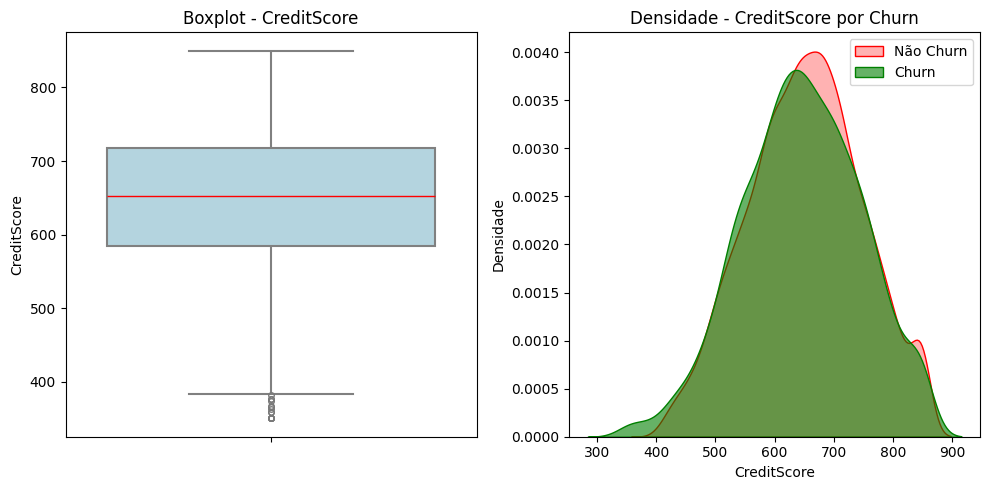

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot 
sns.boxplot(
    y=df_anl_num['CreditScore'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - CreditScore')
axes[0].set_ylabel('CreditScore')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['CreditScore'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['CreditScore'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - CreditScore por Churn')
axes[1].set_xlabel('CreditScore')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()



- **Count**: 10.000 observações, sem valores ausentes.
- **Mean (650,53)**: A média de crédito razoável em relaçao as min e max.
- **Std (96,65)**: A variação mostra que há clientes com scores muito distintos.
- **Min (350)**: clientes com baixo score e portanto maior risco de crédito.
- **25% (584)**: Um quarto dos clientes tem score abaixo de 584.
- **50% (652)**: A mediana está próxima da média, indicando distribuição relativamente simétrica.
- **75% (718)**: 75% dos clientes têm até 718 pontos.
- **Max (850)**: Alguns clientes têm score excelente.
    - Aqui temos alguns outliers, serão avaliados para transformação. 


- As distribuições entre as classes de churn sao bem parecidas, com churn com pico um pouco mais elevado mas na mesma faixa. De de forma geral, estão com maior densidade entre 600 e 700 de score, valores bastante auto, indicando bom score de crédito para maioria de clientes 


#### **Age**

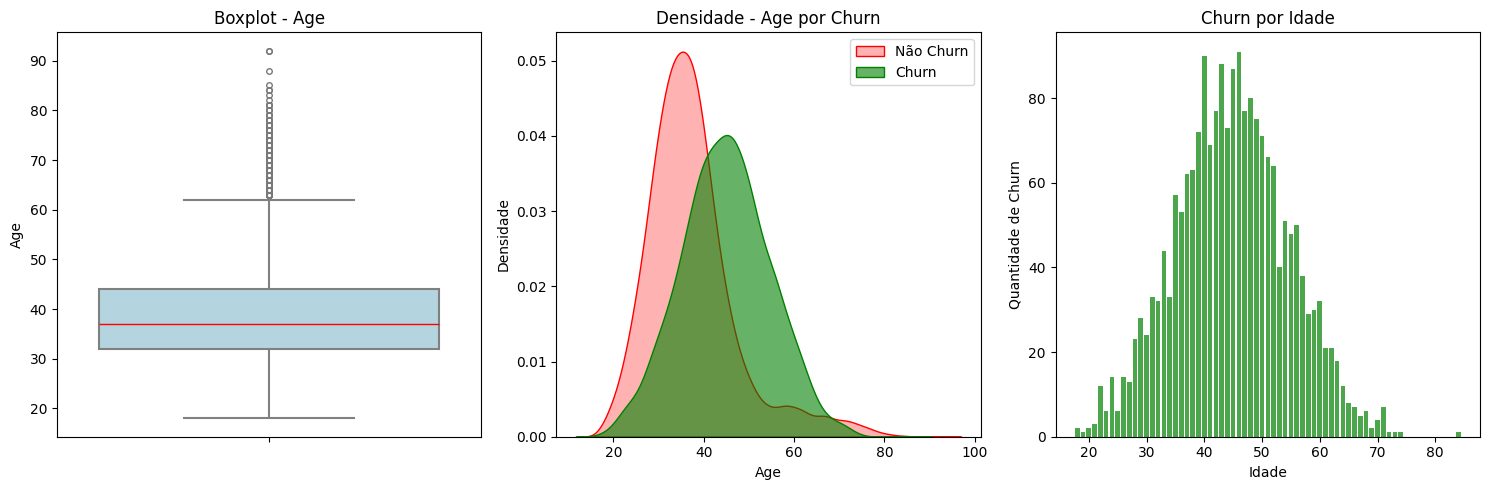

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# === Boxplot ===
sns.boxplot(
    y=df_anl_num['Age'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Age')

# === KDE - Densidade Churn vs Não Churn ===
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Age'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Age'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - Age por Churn')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Densidade')
axes[1].legend()

# === Gráfico de Barras - Quantidade de Churn por Idade ===
churn_por_idade = df_selecionado[df_selecionado['Exited'] == 1]['Age'].value_counts().sort_index()

axes[2].bar(churn_por_idade.index, churn_por_idade.values, color='green', alpha=0.7)
axes[2].set_title('Churn por Idade')
axes[2].set_xlabel('Idade')
axes[2].set_ylabel('Quantidade de Churn')

plt.tight_layout()
plt.show()



- **Count**: 10.000 observações, sem valores ausentes.
- **Mean (38,92)**: A idade média dos clientes é de cerca de 39 anos.
- **Std (10,49)**: A dispersão é razoável, com clientes de várias faixas etárias.
- **Min (18)**: Sao os clientes mais jovens, mas nenhum menor de idade. 
- **25% (32)**: Um quarto dos clientes tem até 32 anos.
- **50% (37)**: A mediana mostra uma concentração em torno dos 37 anos. (e o gráfico de densidade também)
- **75% (44)**: 75% dos clientes têm até 44 anos.
- **Max (92)**: Há clientes idosos na base, chegando a 92 anos.

    - Aqui temos alguns outliers, serão considerados para transformações. 

 - Observa-se uma diferença significativa nas distribuições de idade entre clientes que deram churn e os que permaneceram. A maior densidade de clientes que **não deram churn** está concentrada na faixa de **25 a 40 anos**, enquanto os clientes que **deram churn** apresentam uma concentração mais acentuada entre **40 e 45 anos**. Isso sugere uma possível relação entre idade e propensão ao churn, mais precisamente em clientes mais velhos;  precisará ser monitorado, pois essa variável é sensível para justiça do modelo. 

#### **Tenure**

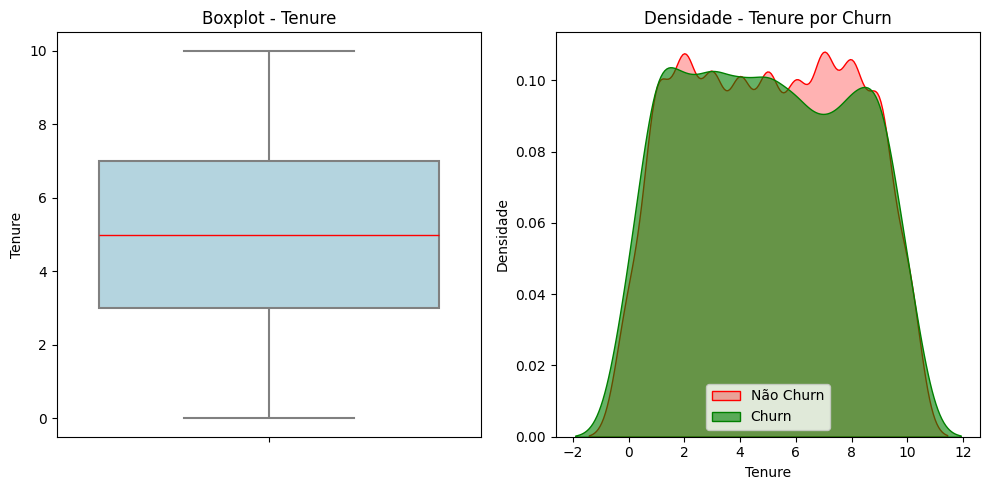

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Tenure'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Tenure')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Tenure'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Tenure'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - Tenure por Churn')
axes[1].set_xlabel('Tenure')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()



- **Count**: 10.000 registros, sem valores ausentes.
- **Mean (5,01)**: Em média, os clientes têm 5 anos de banco.
- **Std (2,89)**: A variação é pequena, indicando tempos de casa parecidos.
- **Min (0)**: Provaveis novos clientes.
- **25% (3)**: Um quarto dos clientes tem até 3 anos de relacionamento.
- **50% (5)**: A mediana coincide com a média, sugerindo distribuição simétrica. (gráfico de densidade também sugere isso)
- **75% (7)**: 75% dos clientes têm até 7 anos no banco.
- **Max (10)**: Alguns clientes têm até 10 anos de relacionamento.

- Clientes de 6 a 9 aparentam ter menos ocorrência de churn. 



#### **Balance**

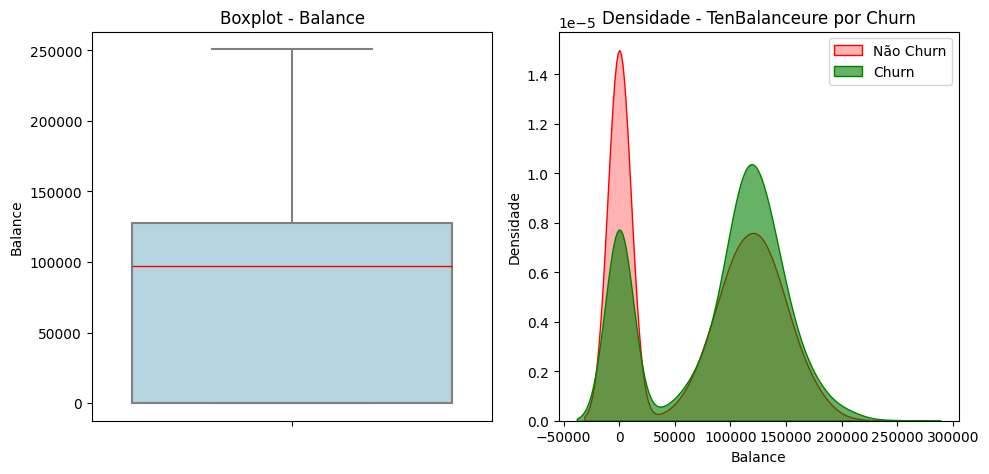

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Balance'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Balance')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Balance'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Balance'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - TenBalanceure por Churn')
axes[1].set_xlabel('Balance')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()



- **Count**: 10.000 clientes, sem valores ausentes.
- **Mean (76.485,89)**: Saldo médio de R$ 76 mil.
- **Std (62.397,41)**: Alta variabilidade de saldos entre os clientes, o que e aceitável e até esperado. 
- **Min (0,00)**: Há clientes sem saldo.
- **25% (0,00)**: Um quarto dos clientes tem saldo zerado.
- **50% (97.198,54)**: A mediana é alta, sugerindo concentração nos que possuem saldo elevado.
- **75% (127.644,24)**: Um quarto dos clientes têm saldo acima de R$ 127 mil.
- **Max (250.898,09)**: Alguns clientes possuem saldos muito altos, ate em relacao aos 75%.

**Pontos de atenção e riscos**
- Pelo gráfico de densidade, observa-se uma alta concentração de valores iguais a zero, indicando **dados inflados de zero**, seguida de uma distribuição aproximadamente normal nos demais valores.
 Nota-se que **clientes churn** apresentam **menor densidade** nos pontos inflados de zero em comparação com os de maior densidade, que estão na faixa **entre 100.000 e 150.000**, o que pode indicar uma relação entre clientes que tem saldo e propensão ao churn; evidentemente mais clientes que tem saldo na conta vem a churn, isso pode ser um indicativo de insatisfação. 

- A variável apresenta distribuição muito desigual, com **25% dos clientes tendo saldo zero**, enquanto a mediana é de cerca de R$ 97 mil e o máximo ultrapassa R$ 250 mil — o que explica o desvio padrão elevado.
- Esse cenário pode distorcer o aprendizado do modelo, será necessário transformaçoes e testar feature engineering se viável. 

#### **EstimatedSalary**

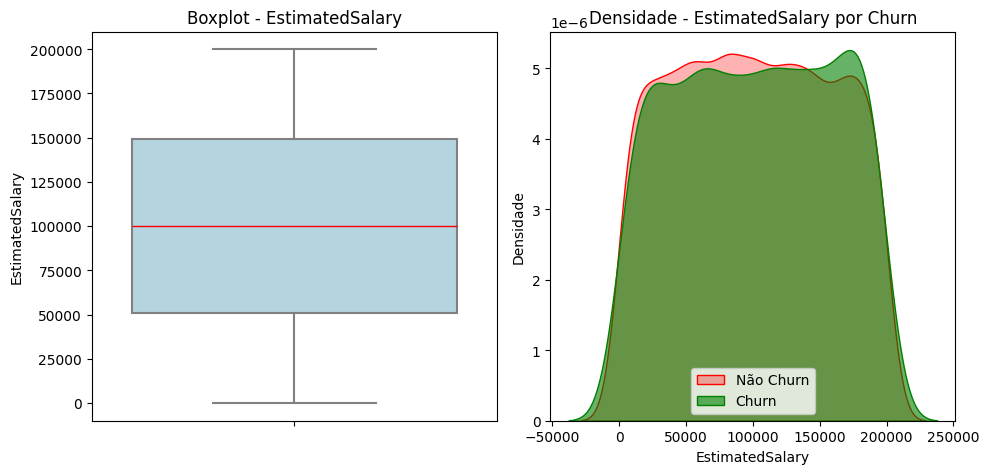

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['EstimatedSalary'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - EstimatedSalary')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['EstimatedSalary'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['EstimatedSalary'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - EstimatedSalary por Churn')
axes[1].set_xlabel('EstimatedSalary')
axes[1].set_ylabel('Densidade')
axes[1].legend()

plt.tight_layout()
plt.show()


- **Count**: 10.000 observações, sem valores ausentes.  
- **Mean (R$ 100.090,24)**: Salário médio estimado de aproximadamente R$ 100 mil.  
- **Std (R$ 57.510,49)**: Alta dispersão na distribuição de salários entre os clientes.  
- **Min (R$ 11,58)**: Existem clientes com rendas bastante baixas.  
- **25% (R$ 51.002,11)**: Um quarto dos clientes ganha até R$ 51 mil.  
- **50% (R$ 100.193,91)**: A mediana indica que metade dos clientes ganha até R$ 100 mil.  
- **75% (R$ 149.388,25)**: Um quarto dos clientes ganha acima de R$ 149 mil.  
- **Max (R$ 199.992,48)**: Valor máximo de salário observado.



**Postos de atenção e riscos**
- Alta dispersão salarial: os valores variam de **R$ 11 até quase R$ 200 mil**, com média e mediana próximas a R$ 100 mil. (desvio padrão alto).
- Apesar da amplitude, a distribuição é próxima da uniforme, sem indícios de outliers ou assimetrias relevantes.
- Padronização (standardscaler ou RobustScaler -> mais adequado quando tem outliers, mas aqui não parece ser o caso) para compatibilidade com algoritmos sensíveis à escala pode ser necessário.

#### **Point Earned**

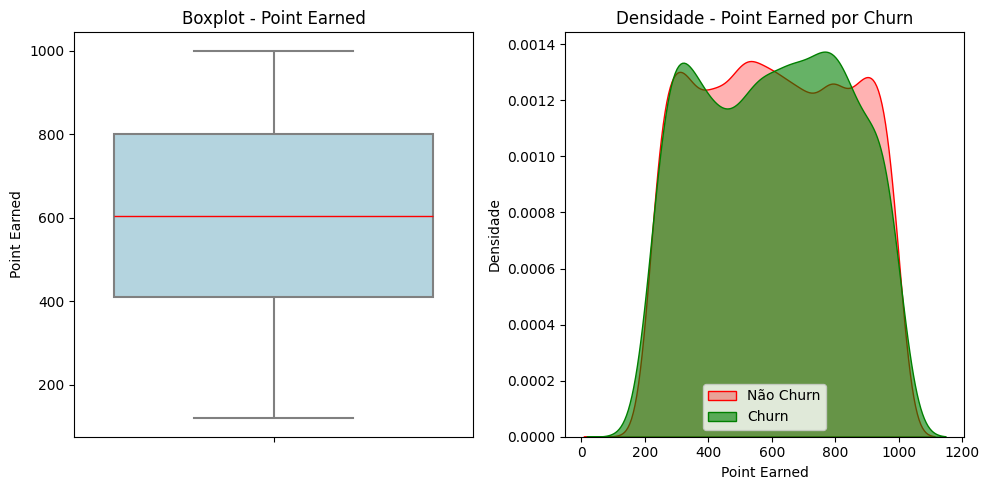

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Boxplot
sns.boxplot(
    y=df_anl_num['Point Earned'],
    ax=axes[0],
    color='lightblue',
    linewidth=1.2,
    fliersize=4,
    boxprops=dict(edgecolor='gray', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1.5),
    capprops=dict(color='gray', linewidth=1.5)
)
axes[0].set_title('Boxplot - Point Earned')

# KDE - Churn vs Não Churn
df_churn = df_selecionado[df_selecionado['Exited'] == 1]
df_nao_churn = df_selecionado[df_selecionado['Exited'] == 0]

sns.kdeplot(df_nao_churn['Point Earned'], ax=axes[1], fill=True, color='red', label='Não Churn', alpha=0.3)
sns.kdeplot(df_churn['Point Earned'], ax=axes[1], fill=True, color='green', label='Churn', alpha=0.6)
axes[1].set_title('Densidade - Point Earned por Churn')
axes[1].set_xlabel('Point Earned')
axes[1].set_ylabel('Densidade')
axes[1].legend()


plt.tight_layout()
plt.show()



- **Count**: 10.000 registros, sem valores ausentes.  
- **Mean (606,52)**: Média de pontos ganhos pelos clientes.  
- **Std (225,92)**: Boa dispersão, sugerindo diferentes níveis de engajamento.  
- **Min (119)**: Alguns clientes apresentam pontuação baixa.  
- **25% (410)**: Um quarto dos clientes tem até 410 pontos.  
- **50% (605)**: A mediana indica até 605 pontos para metade da base.  
- **75% (801)**: Um quarto dos clientes apresenta pontuação mais alta, acima de 801.  
- **Max (1000)**: Alguns clientes atingiram a pontuação máxima.

**Pontos de atenção**
- Ampla variação: pontuações vão de 119 a 1000.  

#### **Correlação entre Numéricas e Target** 

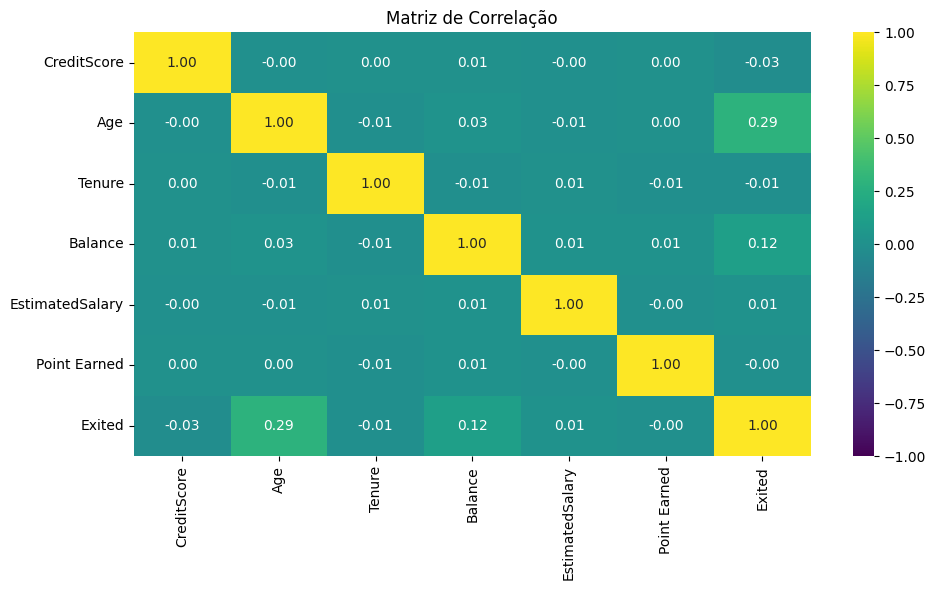

In [17]:
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

#só pra pra matrix de correlacao
df_anl_num_com_exited = df_selecionado[['CreditScore', 
                                        'Age', 
                                        'Tenure', 
                                        'Balance', 
                                        'EstimatedSalary', 
                                        'Point Earned',
                                        'Exited']] 
#Matriz de correlacao 
fig, axes = plt.subplots(1, 1, figsize=(10, 6))# Cria fig 
sns.heatmap(df_anl_num_com_exited.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')
plt.tight_layout()
plt.show()

* Com base na matriz de correlação, não foram identificadas evidências de multicolinearidade (embora nossos modelos capturem bem isso, se houvesse uma delas seria removidas - duas vezes a mesma info sempre cai em assunto de custo) entre as variáveis explicativas , uma vez que os coeficientes de correlação estão todos abaixo de 0,80 (modualarmente falando, tanto positiva quanto negativamente). 

* No entanto, a variável **Complain** apresenta uma correlação perfeita (1.00) com a variável alvo **Exited**, o que indica um possível vazamento de informação (**data leakage**). Isso significa que essa variável carrega informação que está diretamente associada ao desfecho que o modelo tenta prever, podendo comprometer a generalização (e levar a uma performance artificialmente inflada).


## Análise das Variáveis Categóricas

* selecionando variáveis categóricas (e verificando que elas nao sejam numéricas do df_anl_num)

In [18]:
df_anl_cat = df_selecionado[[col for col in df_selecionado.columns if col not in df_anl_num.columns]]
df_anl_cat['Exited'] = df_selecionado['Exited'] #target

df_anl_cat.columns


Index(['Gender', 'Geography', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'Complain', 'Satisfaction Score', 'Card Type', 'Exited'],
      dtype='object')

#### **Gender**

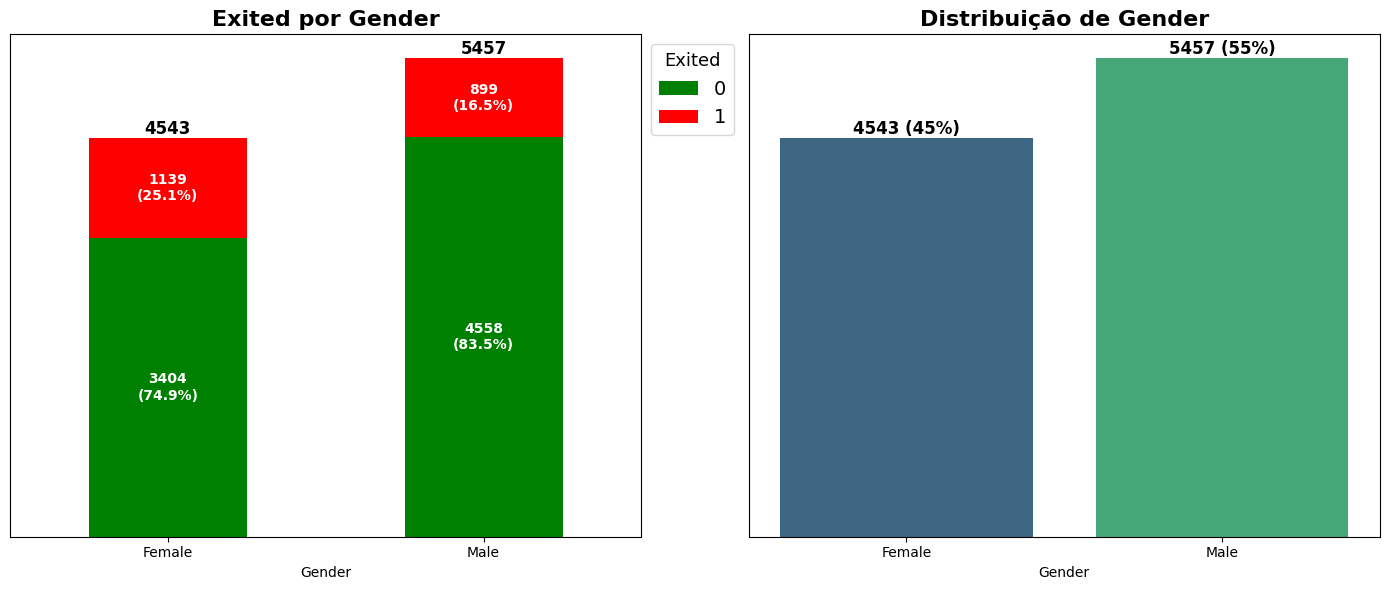

In [19]:
def add_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',
              bbox_to_anchor=(1.0, 1))



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Barras empilhadas Exited por Gender
counts = df_anl_cat.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
colors = ['green', 'red']
counts.plot(kind='bar', stacked=True, color=colors, ax=axes[0])
axes[0].set_title('Exited por Gender', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Gender', fontsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)

#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=10,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])

# Distribuição de Gender (segunda barra simples)
ax = axes[1]
sns.countplot(x=df_anl_cat['Gender'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Gender', fontsize=16,fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['Gender'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(
        label,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.show()


- A quantidade de clientes do sexo masculino é superior em 10%. 
- Observa-se uma proporção de churn com desbalanceamento evidente; 
- Mulheres apresentam uma taxa de churn maior do que homens, o que pode explicar a tendência do modelo em prever com maior frequência churn para clientes do gênero feminino.
    - Por se tratar de uma variável sensível relacionada à justiça do modelo, seu impacto será monitorado para garantir decisões justas.

#### **Geography**

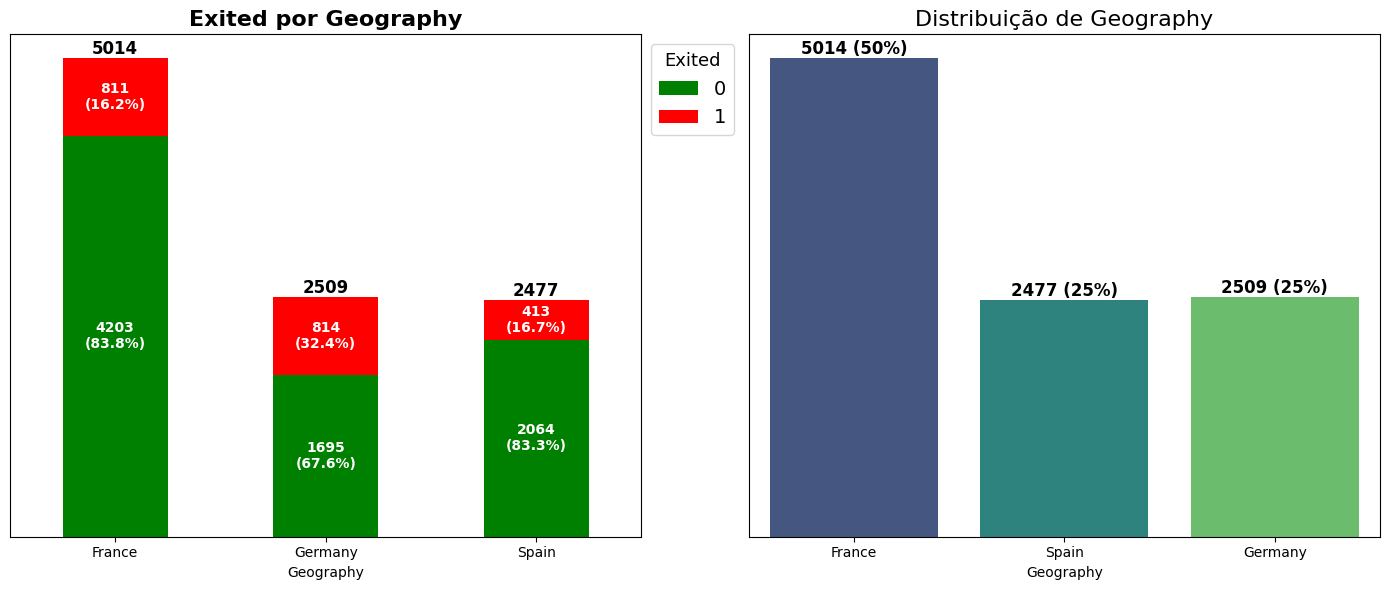

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Geography
counts = df_anl_cat.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Geography', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Geography', fontsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)

#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=10,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])


# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Geography'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Geography', fontsize=16,)
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['Geography'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


* A França se destaca em volume total em relação aos demais países, mas sua taxa de churn é a mesma da Espanha. 
* Já Alemanh, apesar de ter bem menos volume de dados, tem a mesma quantidade de churn que França, e em termos de proporção tem praticamente o dobro dos dois outros paises. 
* Alemanha parece impactar o evento mais que as demais, e por ser uma das variáveis sensíveis em termos de justiça do modelo, vai ser monitorada. 

#### **NumOfProducts**

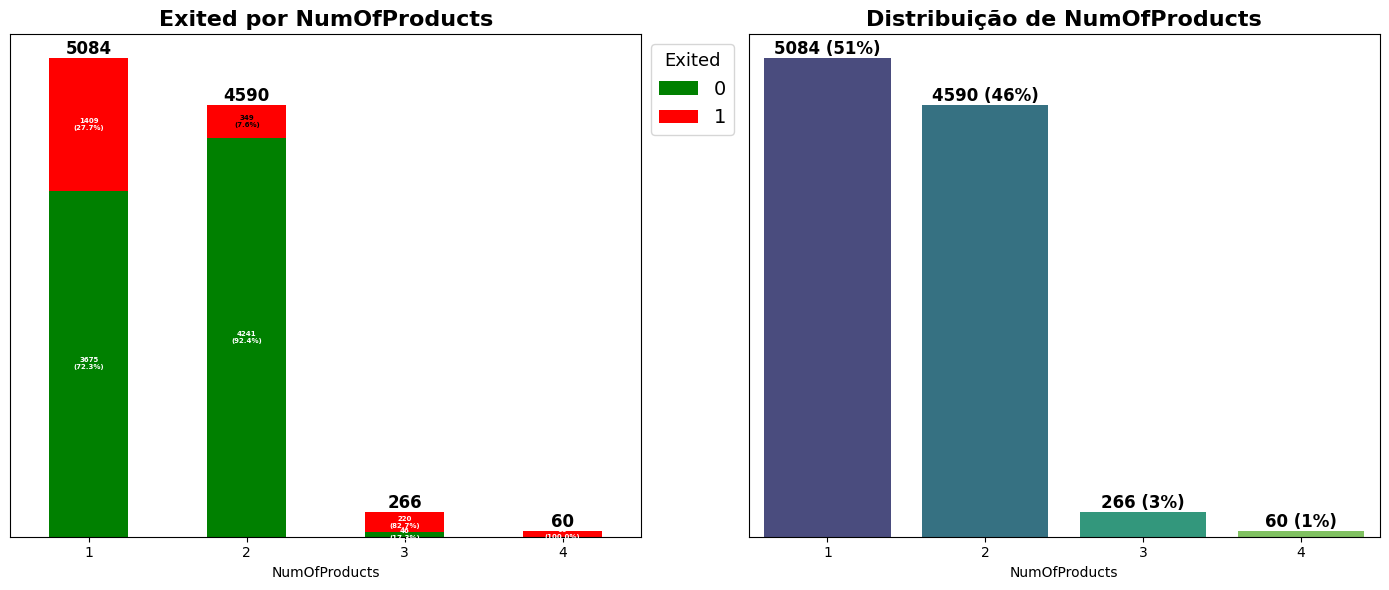

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por NumOfProducts
counts = df_anl_cat.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por NumOfProducts', fontsize=16, fontweight='bold')
axes[0].set_xlabel('NumOfProducts', fontsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=5,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])


# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['NumOfProducts'], ax=ax, palette='viridis')
ax.set_title('Distribuição de NumOfProducts', fontsize=16,fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['NumOfProducts'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- Evidentemente os clientes tem entre 1 e 2 produtos na maioria dos casos, apesar disso os produtos 3 e 4 tem uma taxa de evasão bem maior, isso é um comportamento que necessita de investigação, pode ser possível desgaste, alta complexidade e insatisfação gerada pelo acumulo de produtos, preço agregado também pode ser um fator que leve a essa alta taxa, não faz parte do escopo, mas em cenários reais, essa variável deveria ser analisada com negócio. 

- As legendas ficaram ruins de visualizar entao segue seus valores: 
    - Todos clientes com 4 produtos sairam (60), como podemos ver no gráfico ao lado, eles representam apenas 1% da base. 

    - 17,3% (46) clientes não deram churn com 3 produtos 
    - 82,7 (220) deram churn com 3 produtos 



#### **HasCrCard**

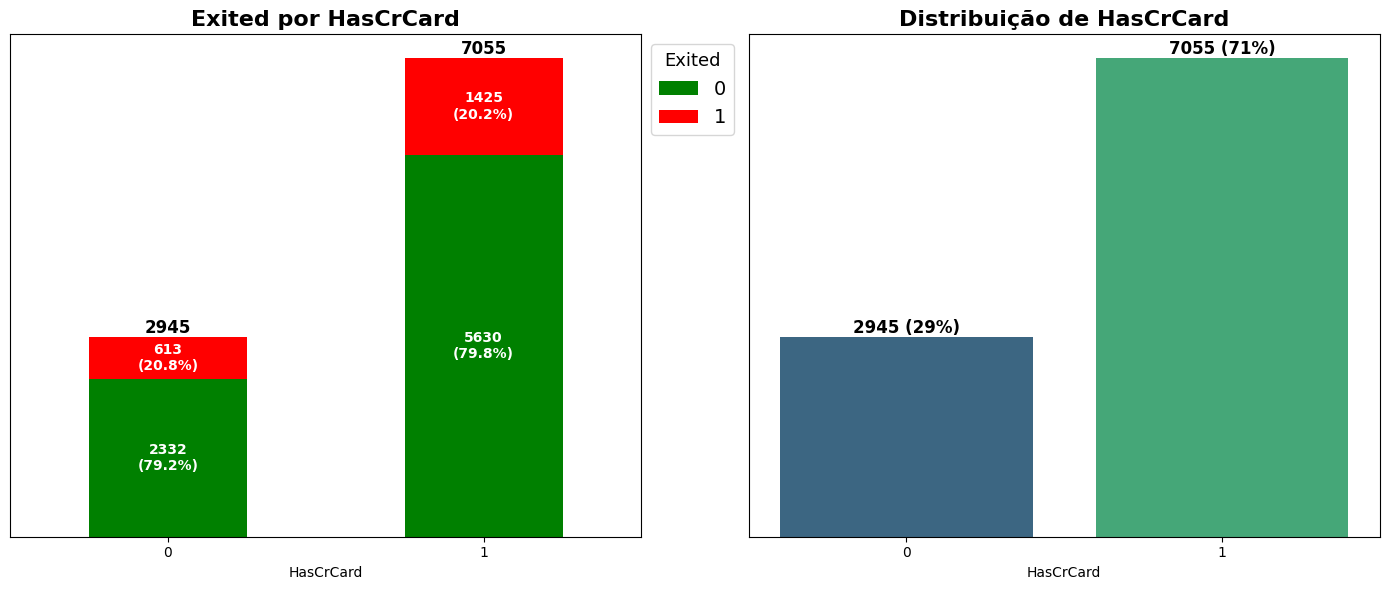

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#barras empilhadas Exited por HasCrCard
counts = df_anl_cat.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por HasCrCard', fontsize=16, fontweight='bold')
axes[0].set_xlabel('HasCrCard', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=10,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['HasCrCard'], ax=ax, palette='viridis')
ax.set_title('Distribuição de HasCrCard', fontsize=16, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 

total = len(df_anl_cat['HasCrCard'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A maioria dos clientes possui cartão de crédito. A taxa de churn entre quem tem cartão e quem não é bem semelhante, nenhum ponto de atenção aqui. 

#### **IsActiveMember**

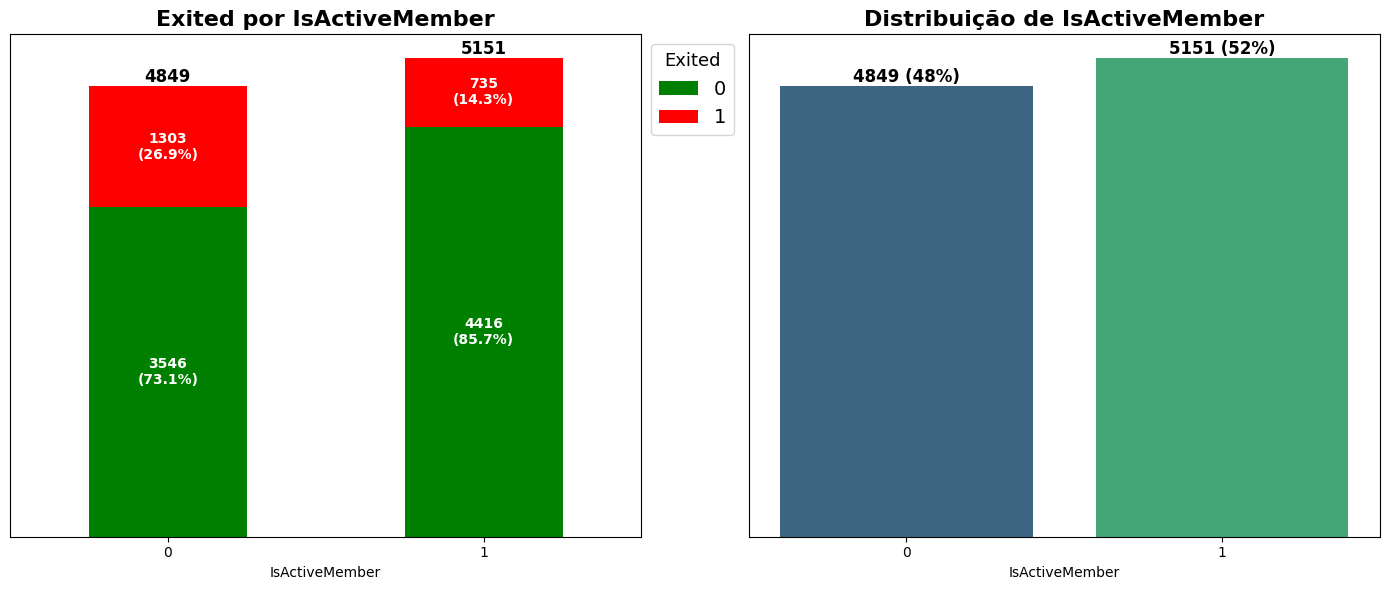

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por IsActiveMember
counts = df_anl_cat.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por IsActiveMember', fontsize=16, fontweight='bold')
axes[0].set_xlabel('IsActiveMember', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=10,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])


# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['IsActiveMember'], ax=ax, palette='viridis')
ax.set_title('Distribuição de IsActiveMember', fontsize=16, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['IsActiveMember'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- Clientes ativos e não ativos apresentam proporções quase iguais na base, porém a classe de quem não é cliente ativo tem quase o dobro de evasão da classe de quem é ativo. 

#### **Complain**

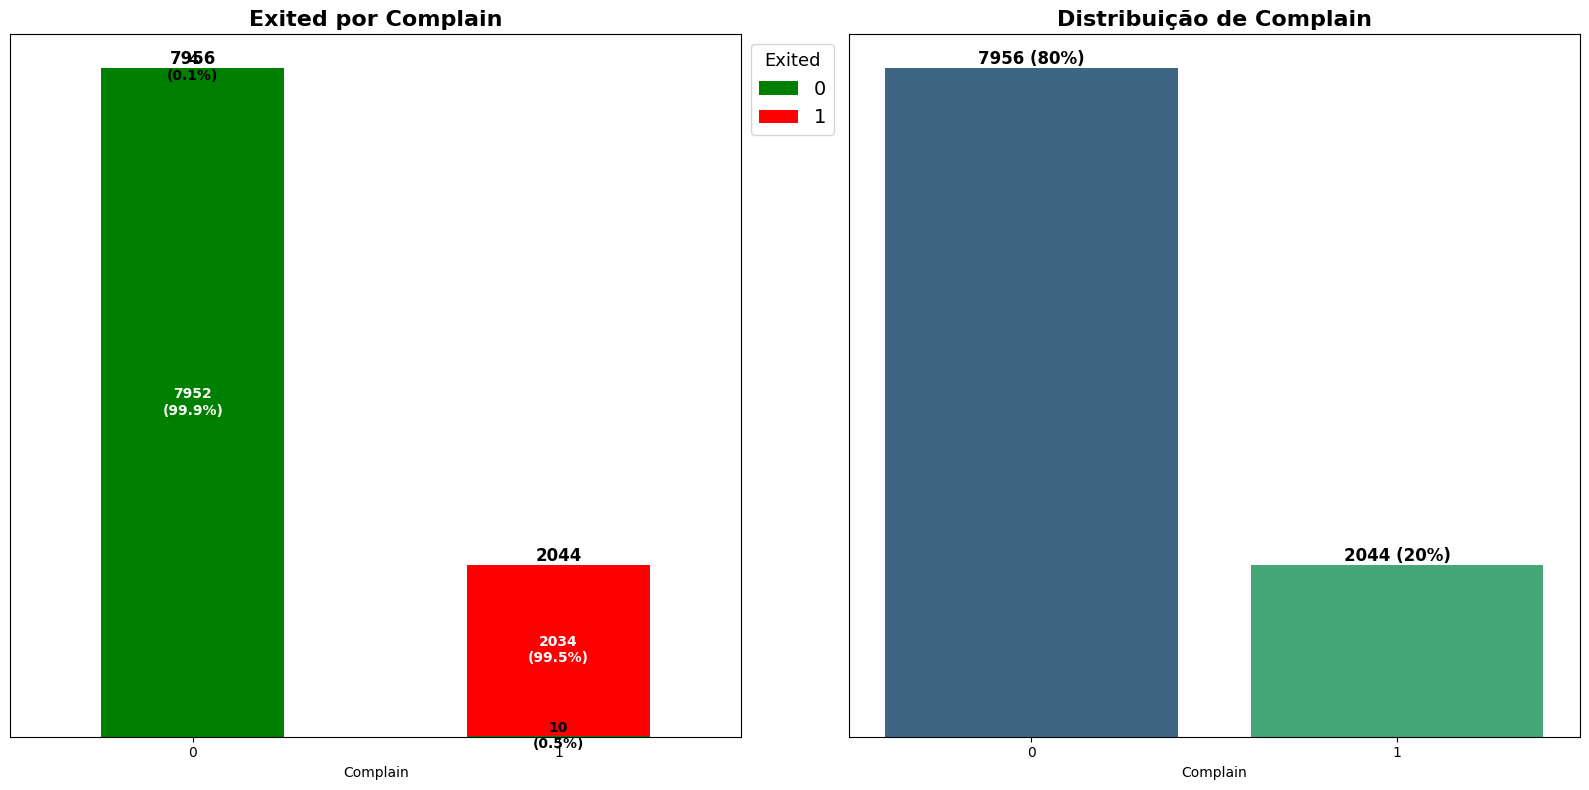

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Primeiro gráfico: barras empilhadas Exited por Complain
counts = df_anl_cat.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Complain', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Complain', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=10,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Complain'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Complain', fontsize=16, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['Complain'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- Podemos ver que 20% dos clientes reclamam, e desses que reclamam 99.5% evadiram (churn), dos que nao reclamam apenas 0.1% evade. 

- Aqui tem um forte perigo, essa variável já foi identificada como possível vazamento de dados, ela fica mais evidente disto aqui. 

- As legendas ficaram ruins mas aqui estão os números delas: 

    * 4 clientes (0,1%) dos clientes sem reclamação eram churn

    * 10 clientes (0.5%) dos clientes que reclamaram não deram churn, 99,5% dos clientes que reclamaram deram churn 


#### **Satisfaction Score**

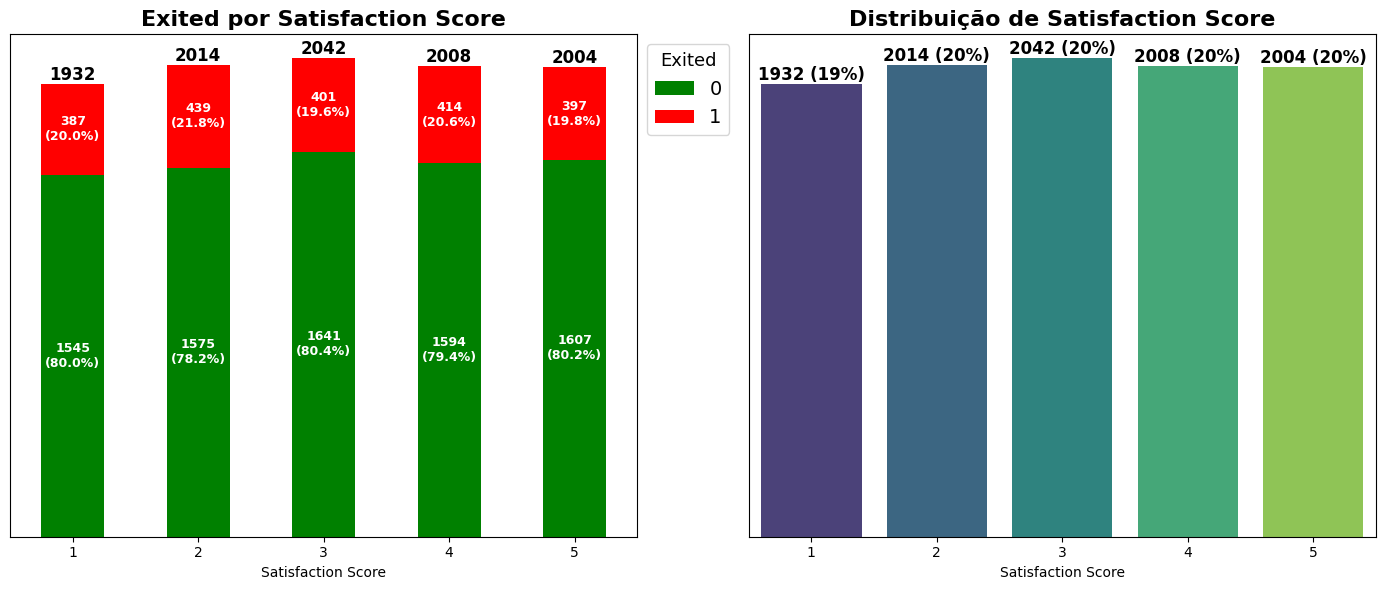

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Complain
counts = df_anl_cat.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Satisfaction Score', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Satisfaction Score', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=9,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Satisfaction Score'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Satisfaction Score', fontsize=16,fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['Satisfaction Score'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A distribuição dos clientes entre as categorias dessa variável é quase uniforme, apresentando uma boa representatividade em cada grupo. O desbalanceamento de churn também acompanha essa distribuição, mantendo-se relativamente equilibrado dentro de cada categoria.

#### **Card Type**

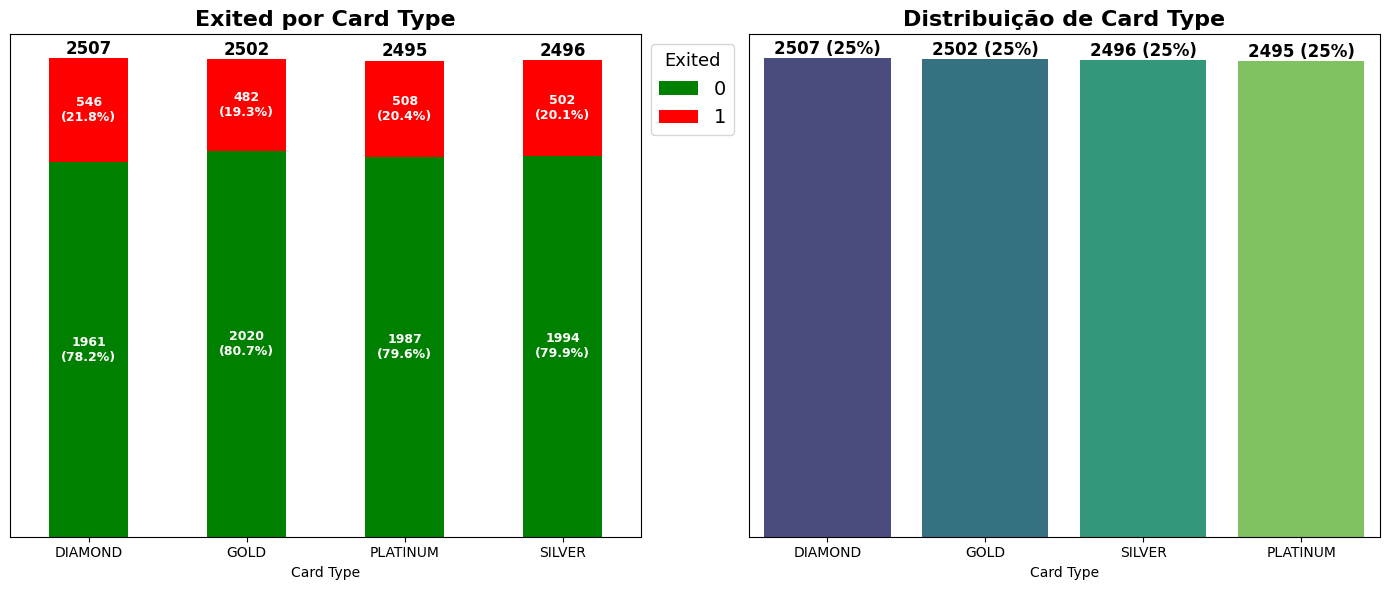

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Primeiro gráfico: barras empilhadas Exited por Card Type
counts = df_anl_cat.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
axes[0].set_title('Exited por Card Type', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Card Type', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


#Rótulos absolutos + porcentagens nas barras empilhadas
for i, (index, row) in enumerate(counts.iterrows()):
    total = row.sum()
    bottom = 0
    for value in row:
        if value > 0:
            pct = 100 * value / total
            label = f'{int(value)}\n({pct:.1f}%)'
            axes[0].text(
                i, bottom + value / 2, label,
                ha='center', va='center', fontsize=9,
                color='white' if pct > 10 else 'black', fontweight='bold'
            )
            bottom += value

    # Total no topo da barra
    axes[0].text(
        i, bottom + 1, f'{int(total)}',
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Legenda
add_legend(axes[0])

# Segundo gráfico: countplot com rótulos de quantidade e porcentagem
ax = axes[1]
sns.countplot(x=df_anl_cat['Card Type'], ax=ax, palette='viridis')
ax.set_title('Distribuição de Card Type', fontsize=16,fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
total = len(df_anl_cat['Card Type'])
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total
    label = f'{count} ({int(round(pct))}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


- A distribuição dos clientes entre as categorias dessa variável é quase uniforme, apresentando uma boa representatividade em cada grupo. O desbalanceamento de churn também acompanha essa distribuição, mantendo-se relativamente equilibrado dentro de cada categoria.

#### **Exited (Target)**

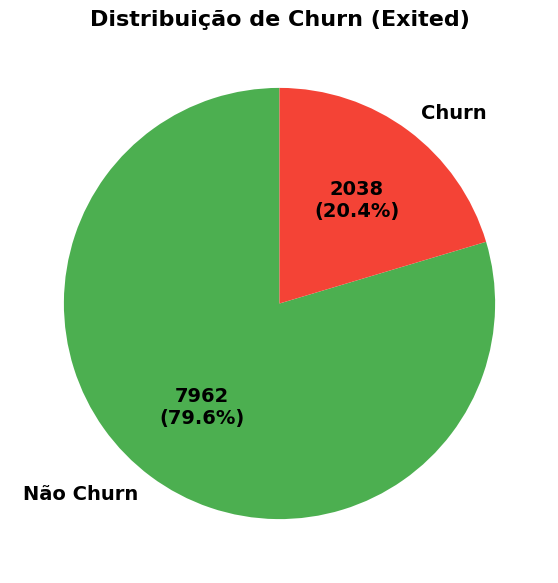

In [27]:
# Contagem das classes de churn
counts_exited = df_anl_cat['Exited'].value_counts()
labels = counts_exited.index.map({0: 'Não Churn', 1: 'Churn'})

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}\n({pct:.1f}%)'
    return my_autopct

plt.figure(figsize=(7,7))
plt.pie(counts_exited, labels=labels, autopct=make_autopct(counts_exited), 
        startangle=90, colors=['#4CAF50', '#F44336'], textprops={'fontsize': 14, 'fontweight': 'bold'})
plt.title('Distribuição de Churn (Exited)', fontsize=16, fontweight='bold')
plt.show()


- Aqui o desbalanceamento das classes fica evidente de fato ao analisarmos diretamente a variável target. Embora não se trate de um caso típico de evento raro — geralmente definido quando a classe minoritária representa menos de 5% dos casos. 

#### **Associação com V de Cramer e Qui2: vars categóricas** 

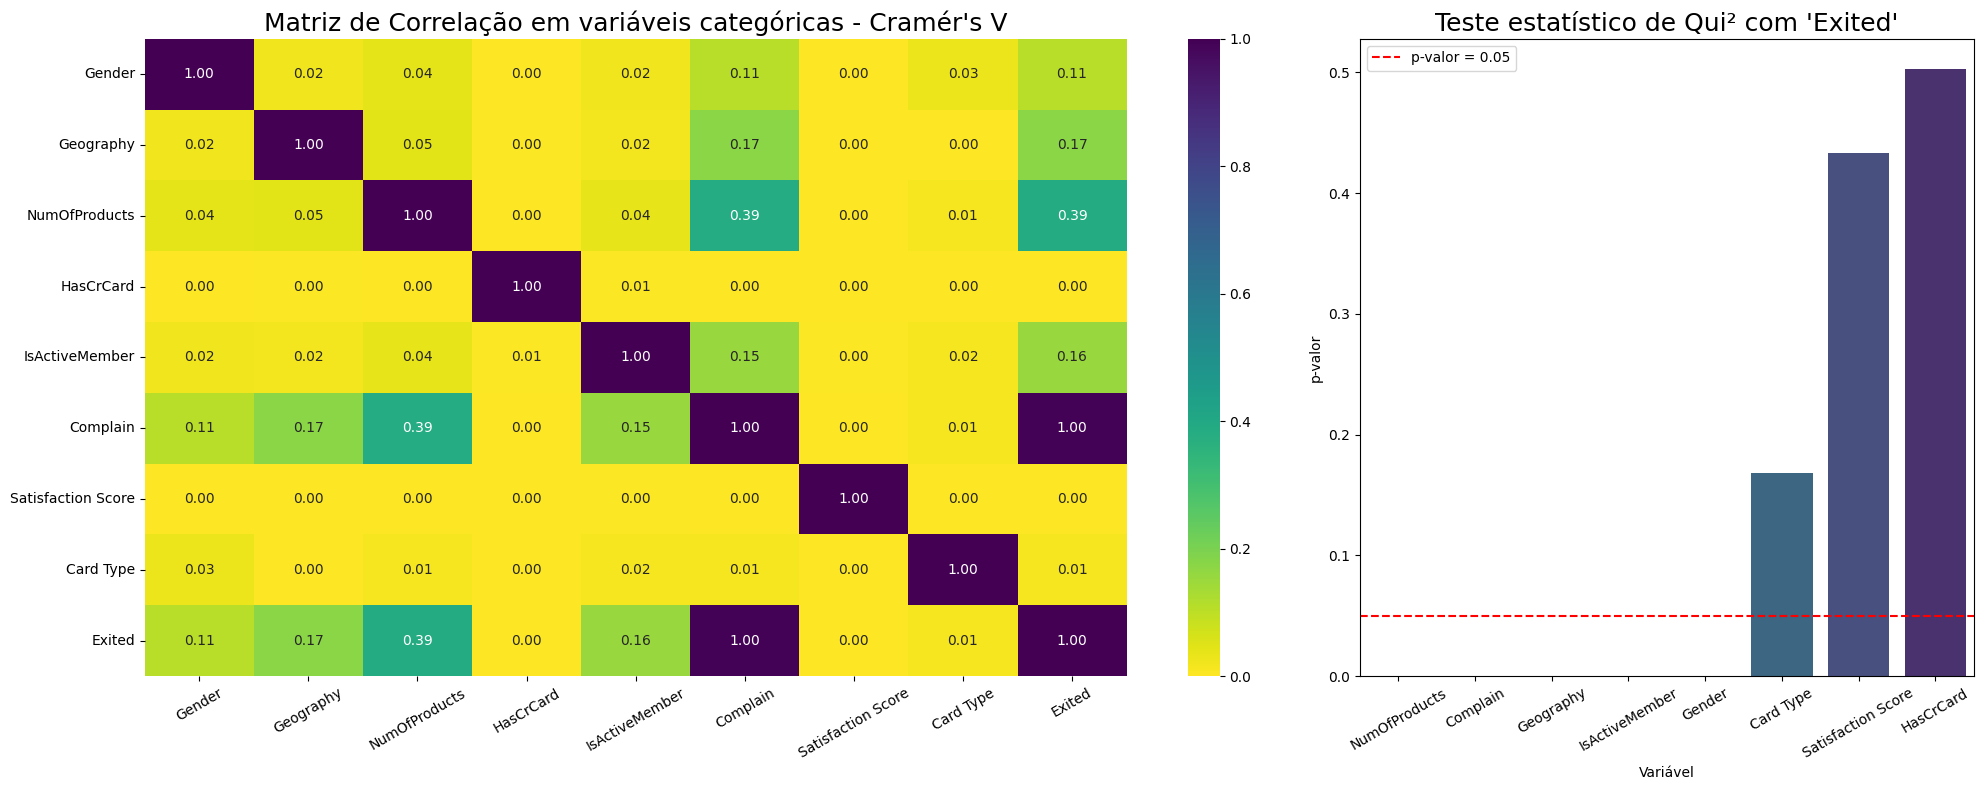

In [28]:
def calcular_V_de_Cramer_matrix(df, incluir_target=True, target='Exited'):

    '''Essa funcao cria o teste de Cramer e retorna uma matriz com os resultados'''

    cat_cols = df.columns.tolist() if incluir_target else [col for col in df.columns if col != target]
    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for col1, col2 in combinations(cat_cols, 2):
        tabela = pd.crosstab(df[col1], df[col2])
        chi2 = chi2_contingency(tabela)[0]
        n = tabela.sum().sum()
        phi2 = chi2 / n
        r, k = tabela.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        cramer_matrix.loc[col1, col2] = v
        cramer_matrix.loc[col2, col1] = v

    np.fill_diagonal(cramer_matrix.values, 1.0)
    return cramer_matrix

def teste_qui2(df, target='Exited', min_categories=2 ):

    '''
    Função para calcular os p-valores do teste Qui²

    Parâmetros:

    df : DataFrame contendo as variáveis categóricas (target junto).
    target : variavel alvo
    min_categories : Número mínimo de categorias para a variável ser 
                    considerada para o teste (evita erros com variáveis constantes).
    '''

    p_values = {}
    
    for col in df.columns:
        if col == target:
            continue
        
        # Ignorar constantes (menos de duas categorias na verdade)
        if df[col].nunique() < min_categories:
            p_values[col] = np.nan
            continue
        
        try:
            contingency = pd.crosstab(df[col], df[target])
            chi2, p, dof, expected = chi2_contingency(contingency)
            p_values[col] = p
        except (ValueError, pd.errors.PerformanceWarning) as e:
            # preenche com nan as exceções
            p_values[col] = np.nan
            
    return pd.Series(p_values).sort_values()




# Aplica v_crammer e qui2
cramer_matrix = calcular_V_de_Cramer_matrix(df_anl_cat)
pval_series = teste_qui2(df_anl_cat, target='Exited')

# Plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 1]})

# Heatmap de Cramér's V
sns.heatmap(cramer_matrix.astype(float), annot=True, cmap='viridis_r', fmt=".2f", ax=ax1)
ax1.set_title("Matriz de Correlação em variáveis categóricas - Cramér's V", fontsize=18)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

# Gráfico de barras com p-valores
sns.barplot(x=pval_series.index, y=pval_series.values, palette="viridis_r", ax=ax2)
ax2.axhline(y=0.05, color='red', linestyle='--', label='p-valor = 0.05')
ax2.set_ylabel("p-valor")
ax2.set_xlabel("Variável")
ax2.set_title("Teste estatístico de Qui² com 'Exited'", fontsize=18)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
ax2.legend()

plt.tight_layout()
plt.show()


* Para interpretar os dois testes: 

    - Teste Qui2: verifica se há associação significativa entre duas variáveis categóricas (p < 0,05 indica associação, ou seja, no gráfico de barras quem está acima da linha de p-valor não apresenta associação com a target).

    - Cramér's V: mede a força da associação entre variáveis categóricas, variando de 0 (nenhuma) a 1 (forte).

- Card Type, Satisfaction Score e HasCrCard apresentaram p > 0,05 e valores muito baixos em Cramér's V, indicando associação fraca ou inexistente com a variável alvo, são fortes candidatas a não permanecer no modelo, ao menos olhando de forma linear e direta com a target. 

- Por outro lado, NumOfProducts, Geography e IsActiveMember mostraram valores elevados na matriz de Cramér's V, sugerindo associação mais forte com a variável alvo.

### "Correlação" de todas variáveis, principalmente numéricas vs categoricas 

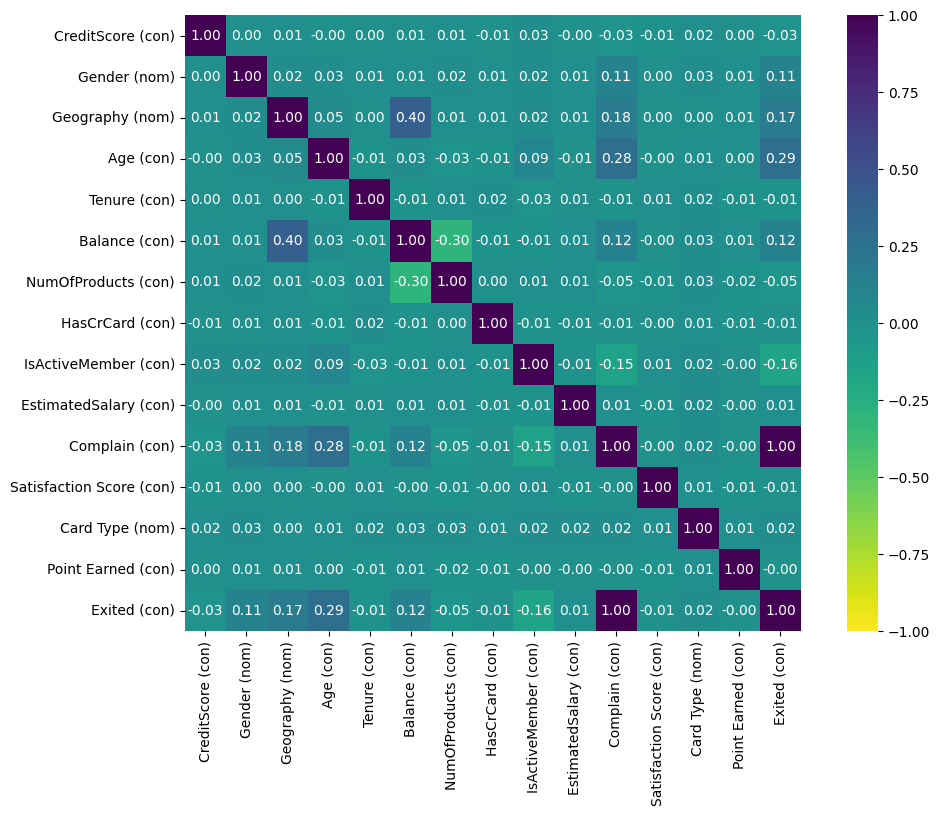

In [29]:
# Matriz de correlação mista 
associacoes = associations(
    df_selecionado,
    nominal_columns='auto',
    mark_columns=True,
    plot=True,
    figsize=(12, 8),
    cmap='viridis_r'
    
)


- nom → variáveis nominais, ou seja, categóricas

- con → variáveis contínuas, ou numéricas

- Para medir a associação entre as variáveis, são usados métodos diferentes dependendo dos tipos:

    - **Correlação de Pearson** para variáveis numéricas vs numéricas

    - **Cramér’s V** para variáveis categóricas vs categóricas

    - **Numérica vs Categórica → Correlation Ratio (também conhecido como η² ou Eta squared), uma métrica baseada em análise de variância (ANOVA)** 
* Os valores obtidos para Cramér’s V, Pearson e Correlation Ratio não são diretamente comparáveis entre si, pois cada um mede a associação de forma distinta — com fundamentos estatísticos específicos para o tipo de variável analisado. Ainda assim, essa abordagem mista é útil para explorar relações entre variáveis numéricas e categóricas de forma integrada.


* De forma geral, as associações mais relevantes envolvem as variáveis de país, idade, gênero (ainda que de forma sutil), status de membro ativo e número de produtos — todas apresentando alguma relação com a variável target ao entre si. A variável Complain será removida, pois carrega quase 100% da info da target para a classe de interesse. As demais variáveis demonstram independência entre si e em relação ao target. Vale lembrar que a correlação capturada é predominantemente linear, o que limita a conclusão sobre a existência de relações mais complexas.

# 3. Preparação dos Dados: Feature Engineering

* Nesta seção, foram criadas variáveis com potencial relevância para o modelo.
**Embora nem todas tenham se mostrado estatisticamente significativas, todas foram registradas para fins exploratórios e de entendimento do comportamento do evento.**

    * As variáveis que demonstraram impacto real estão sendo aplicadas diretamente no pipeline por meio da classe **FeatureEngineeringTransformer() (arquivo -> Classes_transformadoras_customizadas.py).**
    
    * As mesmas lógicas também são implementadas aqui com o objetivo de documentação, ilustração e estudo.

## 3.1 Faixas de CreditScore 

- Categorização da variavel de credit Score, a proposta é ajudar o modelo a entender melhor o score de crédito, testando se categorizando ele entende melhor a informação dessa variável.

- Sem muitas interpretações aqui, mas é possível notar uma tendência dos clientes a ter baixo score de crédito, mais de 90% dos clientes tem score de medio para baixo. 

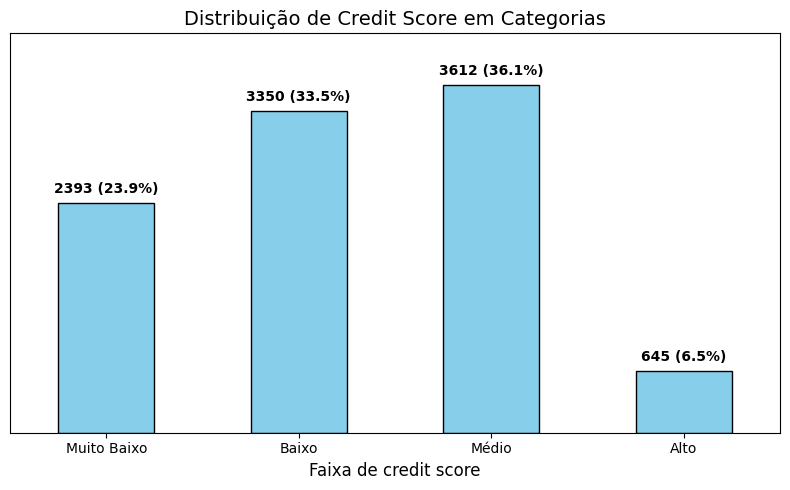

In [30]:
df_selecionado['CreditScore_Bin'] = pd.cut(
    df_selecionado['CreditScore'],
    bins=[0, 580, 670, 800, np.inf],
    labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto']
)


# contagem
count_por_categ = df_selecionado['CreditScore_Bin'].value_counts().sort_index()
total = count_por_categ.sum()

# plot
plt.figure(figsize=(8, 5))
ax = count_por_categ.plot(kind='bar', color='skyblue', edgecolor='black')

# Ajusta o limite superior do eixo y para abrir espaço para os rótulos
y_max = count_por_categ.max()
plt.ylim(0, y_max * 1.15)  # 15% acima do maior valor

# adicionando rótulos de dados
for i, (valor, nome) in enumerate(zip(count_por_categ, count_por_categ.index)):
    percentual = (valor / total) * 100
    ax.text(i, valor + y_max * 0.02, f'{valor} ({percentual:.1f}%)', 
            ha='center', va='bottom', fontweight='bold',fontsize=10)

# config títulos e rótulos
plt.title('Distribuição de Credit Score em Categorias', fontsize=14)
plt.xlabel('Faixa de credit score', fontsize=12)
plt.ylabel('')
ax.set_yticks([]) 
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 3.2 Faixas de Idade 
 - Essa variável serve para agrupar os dados de idade em bins, a proposta é ajudar o modelo a entender melhor e encontrar algum padrão. 

  - A maior parte dos clientes encontra-se nas categorias de adultos e jovens, que juntos representam a maioria da base.

 - Embora a maior quantidade absoluta de churn esteja entre os adultos, isso é parcialmente explicado pelo fato de que eles (adultos) correspondem a cerca de 67% de todos os clientes — ou seja, são naturalmente mais representados em todos os comportamentos.

 - Um ponto de atenção está na categoria dos idosos: embora representem um grupo menor em termos absolutos, apresentam uma taxa de churn proporcionalmente mais alta. Enquanto aproximadamente **20% dos adultos dão churn entre os adultos, entre os idosos essa taxa sobe para cerca de 45%**, ou seja, uma diferença de 25 pontos percentuais. Isso indica que, **proporcionalmente à sua presença na base, os idosos estão mais propensos a churn**.

    - Esse comportamento exige atenção, pois pode levar o modelo a superestimar o risco de churn entre idosos, o que caracterizaria um possível viés. Por isso, essa variável deve ser incluída no grupo de variáveis sensíveis que precisam ser monitoradas em termos de justiça e equidade do modelo. 

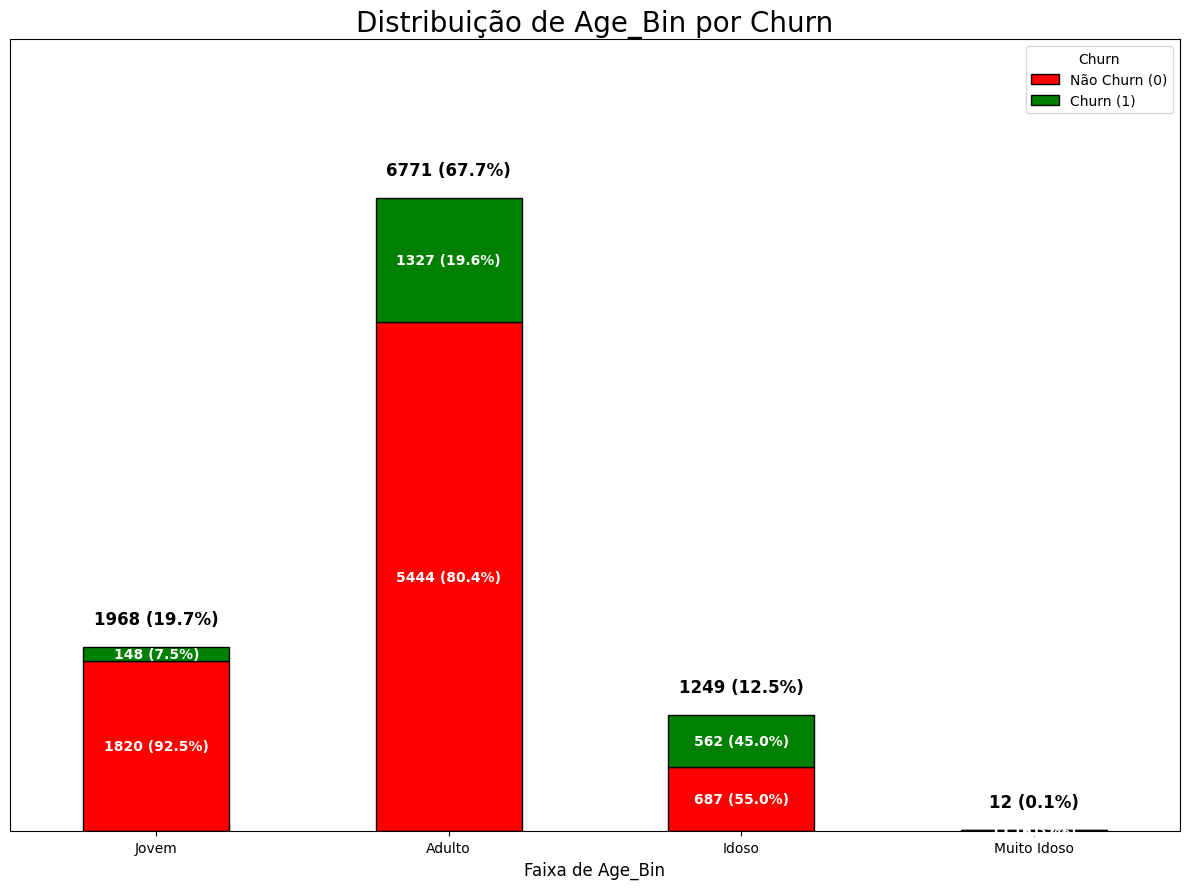

In [31]:
# Faixas etárias 
df_selecionado['Age_Bin'] = pd.cut(
    df_selecionado['Age'],
    bins=[18, 30, 50, 80, np.inf],
    labels=['Jovem', 'Adulto', 'Idoso', 'Muito Idoso'],
    right=True, include_lowest=True
)



# contagem por faixa etária e churn
count_por_categ = df_selecionado.groupby(['Age_Bin', 'Exited']).size().unstack(fill_value=0).sort_index()
totais_por_bin = count_por_categ.sum(axis=1)
total_geral = totais_por_bin.sum()

#  barras empilhadas
plt.figure(figsize=(12, 9))
ax = count_por_categ.plot(kind='bar', stacked=True, color=['red', 'green'], edgecolor='black', ax=plt.gca())

# Ajusta o limite superior do eixo y
y_max = totais_por_bin.max()
plt.ylim(0, y_max * 1.25)

# Rótulos internos com quantidade e % do total por faixa
for i, (idx, row) in enumerate(count_por_categ.iterrows()):
    y_base = 0
    total_faixa = row.sum()
    for j, valor in enumerate(row):
        if valor > 0:
            percentual = (valor / total_faixa) * 100
            ax.text(i, y_base + valor / 2,
                    f'{valor} ({percentual:.1f}%)',
                    ha='center', va='center', color='white',
                    fontweight='bold', fontsize=10)
        y_base += valor

# Rótulo total + percentual acima da barra
for i, (valor_total, nome) in enumerate(zip(totais_por_bin, totais_por_bin.index)):
    percentual = (valor_total / total_geral) * 100
    ax.text(i, valor_total + y_max * 0.03,
            f'{valor_total} ({percentual:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Configs
plt.title('Distribuição de Age_Bin por Churn', fontsize=20)
plt.xlabel('Faixa de Age_Bin', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('')
ax.set_yticks([]) 
plt.legend(['Não Churn (0)', 'Churn (1)'], title='Churn')
plt.tight_layout()
plt.show()


## 3.5 Flag de Saldo

- Clientes sem saldo podem estar desengajados ou apenas mantendo a conta ativa por conveniência, podendo ser mais suscetíveis ao churn.
- A variável de saldo (Balance) tem forte inflação de zeros (25%). A variável de flag pode auxiliar o modelo a identificar melhor esses clientes e não sofrer confusão por inflação de zeros. 

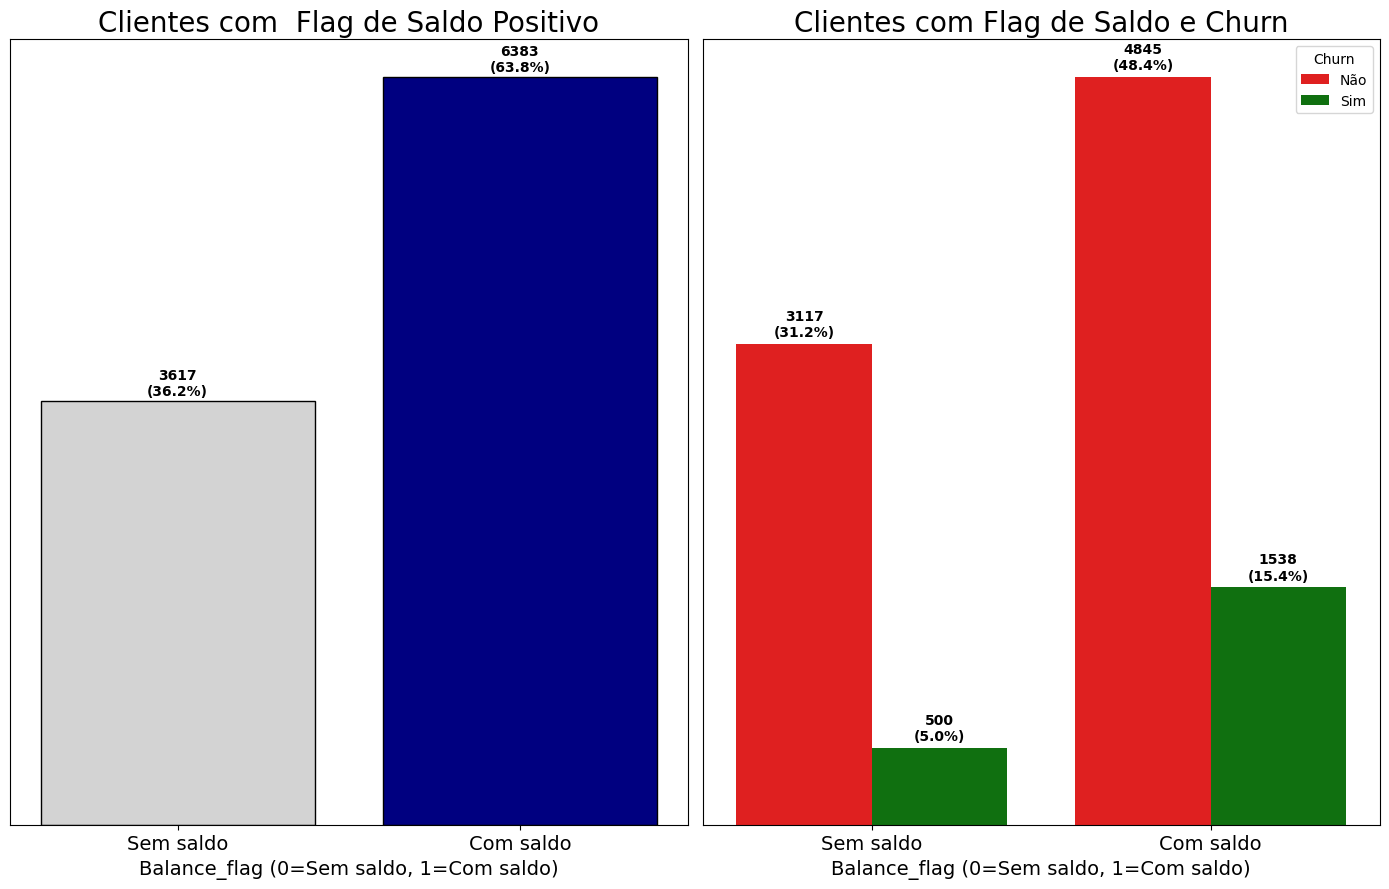

In [32]:

df_selecionado['Balance_flag'] = (df_selecionado['Balance'] > 0).astype(int)


fig, axes = plt.subplots(1, 2, figsize=(14, 9))

total_clientes = len(df_selecionado)

#Contagem Balance_flag 
contagem_flag = df_selecionado['Balance_flag'].value_counts().sort_index()
bars = axes[0].bar(
    contagem_flag.index.astype(str),
    contagem_flag.values,
    color=['lightgray', 'navy'],
    edgecolor='black'
)

axes[0].set_title('Clientes com  Flag de Saldo Positivo', fontsize=20)
axes[0].set_xlabel('Balance_flag (0=Sem saldo, 1=Com saldo)', fontsize=14)
axes[0].set_ylabel('Número de Clientes', fontsize=14)
axes[0].set_xticks([0, 1])
axes[0].set_ylabel('')
axes[0].set_yticks([]) 
axes[0].set_xticklabels(['Sem saldo', 'Com saldo'], fontsize=14)

# Adiciona número e percentual de clientes em cada barra
for bar, flag in zip(bars, contagem_flag.index):
    altura = bar.get_height()
    perc = altura / total_clientes * 100
    if altura > 0:
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            altura + 50,
            f'{int(altura)}\n({perc:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=10
        )

#Contagem de clientes por Balance_flag e Churn
sns.countplot(
    x='Balance_flag',
    hue='Exited',
    data=df_selecionado,
    palette=['red', 'green'],
    ax=axes[1]
)

axes[1].set_title('Clientes com Flag de Saldo e Churn', fontsize=20)
axes[1].set_xlabel('Balance_flag (0=Sem saldo, 1=Com saldo)', fontsize=14)
axes[1].set_ylabel('Número de Clientes', fontsize=14)
axes[1].set_xticks([0, 1])
axes[1].set_ylabel('')
axes[1].set_yticks([]) 
axes[1].set_xticklabels(['Sem saldo', 'Com saldo'], fontsize=14)
axes[1].legend(title='Churn', labels=['Não', 'Sim'])

# Adiciona número e percentual em cada barra do countplot
for p in axes[1].patches:
    altura = p.get_height()
    if altura > 0:
        percentual = altura / total_clientes * 100
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 50,
            f'{int(altura)}\n({percentual:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=10
        )

plt.tight_layout()
plt.show()


- Podemos observar que uma parcela considerável dos **clientes não possui saldo na conta — cerca de 36% do total.**

- Aproximadamente **5%** da base total de clientes **realizou churn estando sem saldo.**

- No entanto, ao olharmos apenas para os **clientes que deram churn, os sem saldo representam cerca de 24% desses casos (500 de 2.038 — soma das duas barras verdes).**


Esse dado é relevante, pois indica que quase um quarto dos churns ocorreu entre clientes sem saldo, sugerindo que a ausência de saldo pode estar associada a menor engajamento financeiro, o que pode contribuir para a evasão.

A variável será incluída nos testes de importância e influência dos modelos como as demais, reconhecendo que a maioria dos churns ainda ocorre entre clientes com saldo. Isso reforça que a relação não é determinística, mas potencialmente explicativa em conjunto com outras variáveis.



## 3.6 Faixas Salário Estimado

- A variável EstimatedSalary foi categorizada em faixas (Baixo, Médio, Alto, Muito Alto) para facilitar a identificação de padrões não lineares que possam existir entre a renda e o comportamento de churn. Essa abordagem pode ajudar os modelos a capturarem relações mais complexas com outras variáveis.

- No entanto, aproximadamente 20% dos clientes em cada faixa deram churn, o que indica que, isoladamente, essa variável não discrimina bem o evento — mas ainda pode ser relevante em interação com outras variáveis.

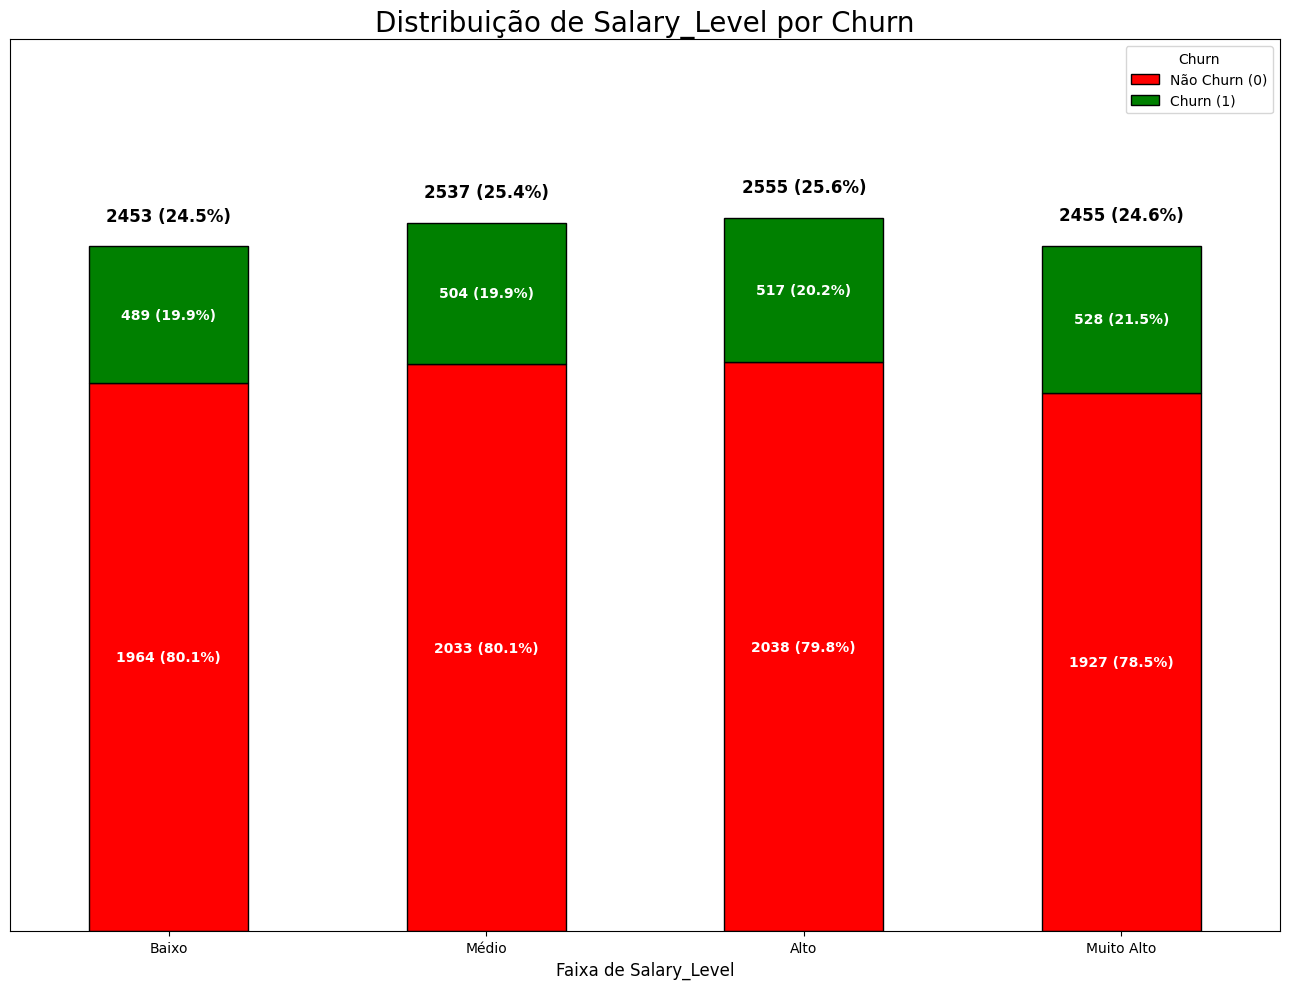

In [33]:
#EstimatedSalary em faixas
bins = [0, 50000, 100000, 150000, 200000]
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']
df_selecionado['Salary_Level'] = pd.cut(df_selecionado['EstimatedSalary'], bins=bins, labels=labels,right=True, include_lowest=True)

# contagem por faixa de salario estimado e churn
count_por_categ = df_selecionado.groupby(['Salary_Level', 'Exited']).size().unstack(fill_value=0).sort_index()
totais_por_bin = count_por_categ.sum(axis=1)
total_geral = totais_por_bin.sum()

# plot barras empilhadas
plt.figure(figsize=(13, 10))
ax = count_por_categ.plot(kind='bar', stacked=True, color=['red', 'green'], edgecolor='black', ax=plt.gca())

# Ajusta o limite superior do eixo y
y_max = totais_por_bin.max()
plt.ylim(0, y_max * 1.25)

# Rótulos internos com quantidade e % do total por faixa
for i, (idx, row) in enumerate(count_por_categ.iterrows()):
    y_base = 0
    total_faixa = row.sum()
    for j, valor in enumerate(row):
        if valor > 0:
            percentual = (valor / total_faixa) * 100
            ax.text(i, y_base + valor / 2,
                    f'{valor} ({percentual:.1f}%)',
                    ha='center', va='center', color='white',
                    fontweight='bold', fontsize=10)
        y_base += valor

# Rótulo total + percentual acima da barra
for i, (valor_total, nome) in enumerate(zip(totais_por_bin, totais_por_bin.index)):
    percentual = (valor_total / total_geral) * 100
    ax.text(i, valor_total + y_max * 0.03,
            f'{valor_total} ({percentual:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Configurações finais
plt.title('Distribuição de Salary_Level por Churn', fontsize=20)
plt.xlabel('Faixa de Salary_Level', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('')
ax.set_yticks([]) 
plt.legend(['Não Churn (0)', 'Churn (1)'], title='Churn')
plt.tight_layout()
plt.show()


## 3.8 Multisserviço Ativo

- A **High_Product_Active** é uma variável binária que indica se o cliente:

    - Possui dois ou mais produtos com o banco (NumOfProducts >= 2)

    - Está ativo (IsActiveMember == 1)

Ou seja, ela representa clientes que não apenas possuem múltiplos produtos, mas também usam ativamente os serviços — o que pode a indicar alto engajamento. 

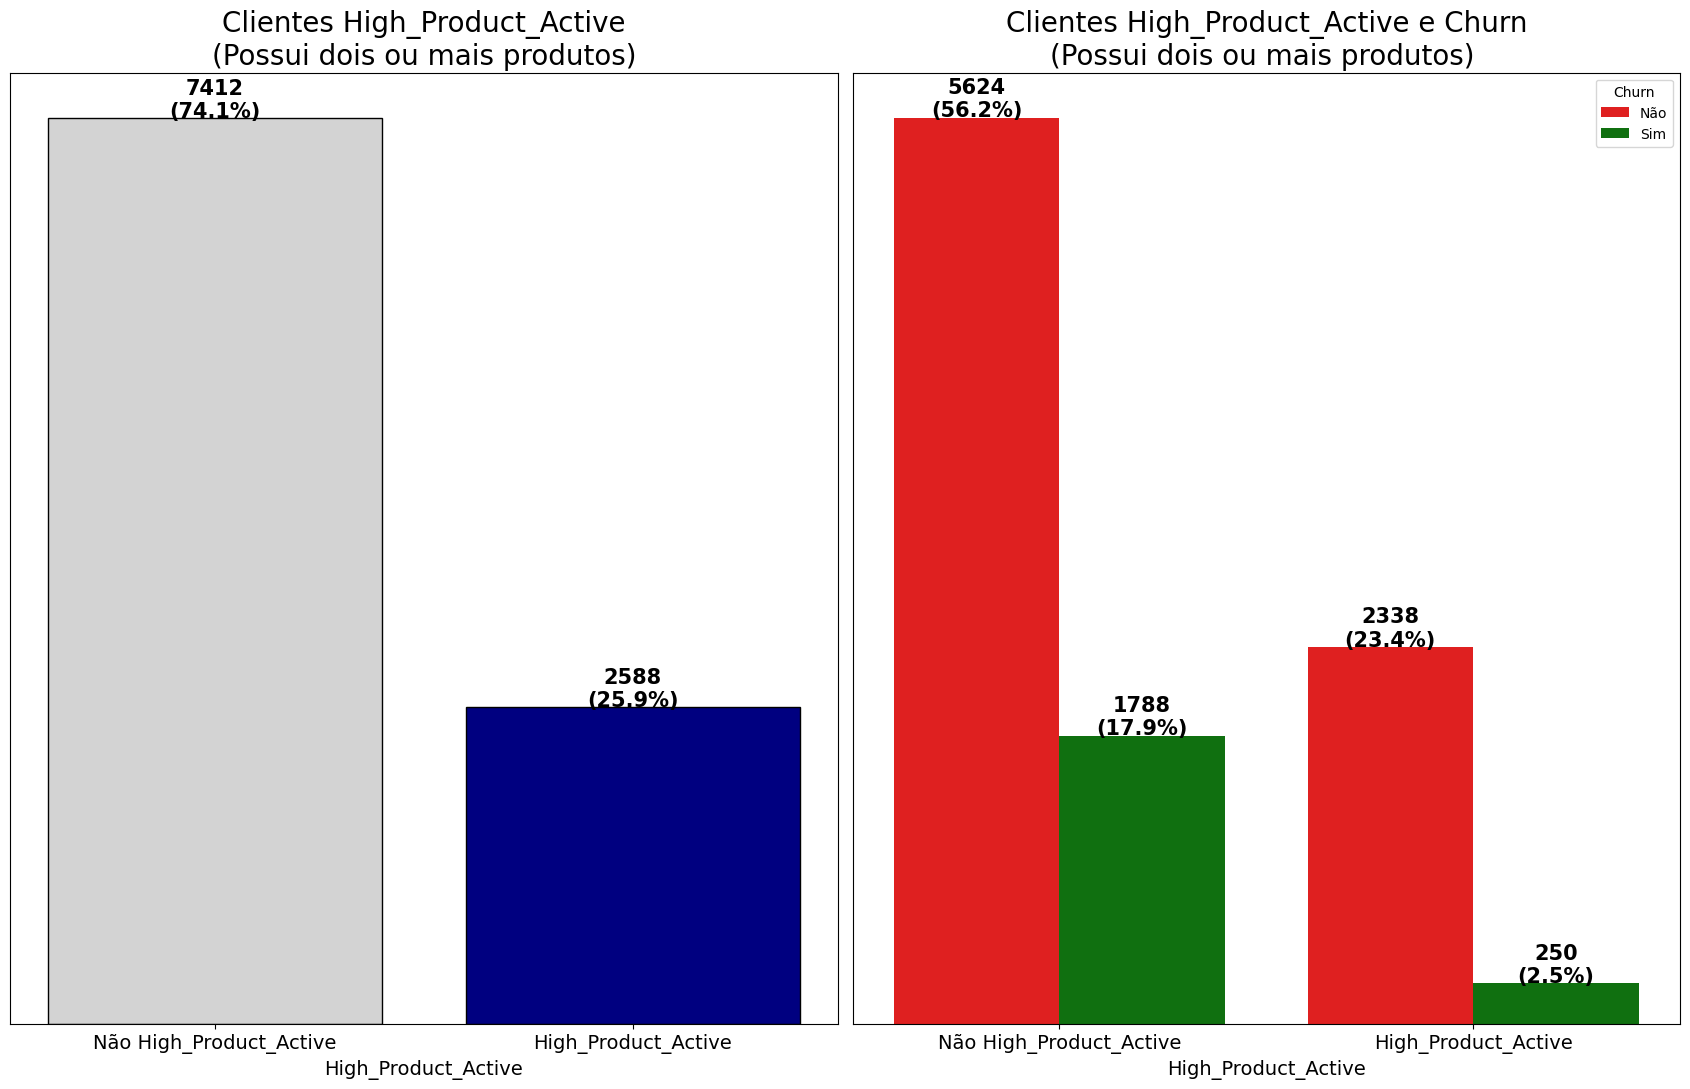

In [34]:
df_selecionado['High_Product_Active'] = (
    (df_selecionado['NumOfProducts'] >= 2) & 
    (df_selecionado['IsActiveMember'] == 1)
).astype(int)


fig, axes = plt.subplots(1, 2, figsize=(17, 11))

total_clientes = len(df_selecionado)

# Contagem total por High_Product_Active 
contagem_flag = df_selecionado['High_Product_Active'].value_counts().sort_index()
bars = axes[0].bar(
    contagem_flag.index.astype(str),
    contagem_flag.values,
    color=['lightgray', 'navy'],
    edgecolor='black'
)

axes[0].set_title('Clientes High_Product_Active\n(Possui dois ou mais produtos)', fontsize=20)
axes[0].set_xlabel('High_Product_Active', fontsize=14)
axes[0].set_ylabel('Número de Clientes', fontsize=14)
axes[0].set_xticks([0, 1])
axes[0].set_ylabel('')
axes[0].set_yticks([]) 
axes[0].set_xticklabels(['Não High_Product_Active', 'High_Product_Active'], fontsize=14)

# Adiciona número e percentual de clientes em cada barra
for bar, flag in zip(bars, contagem_flag.index):
    altura = bar.get_height()
    perc = altura / total_clientes * 100
    if altura > 0:
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({perc:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

# Contagem de clientes por High_Product_Active e Churn
sns.countplot(
    x='High_Product_Active',
    hue='Exited',
    data=df_selecionado,
    palette=['red', 'green'],
    ax=axes[1]
)

axes[1].set_title('Clientes High_Product_Active e Churn\n(Possui dois ou mais produtos) ', fontsize=20)
axes[1].set_xlabel('High_Product_Active', fontsize=14)
axes[1].set_ylabel('Número de Clientes', fontsize=14)
axes[1].set_xticks([0, 1])
axes[1].set_ylabel('')
axes[1].set_yticks([]) 

axes[1].set_xticklabels(['Não High_Product_Active', 'High_Product_Active'], fontsize=14)
axes[1].legend(title='Churn', labels=['Não', 'Sim'])

# Adiciona número e percentual em cada barra do countplot
for p in axes[1].patches:
    altura = p.get_height()
    if altura > 0:
        percentual = altura / total_clientes * 100
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 10,
            f'{int(altura)}\n({percentual:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=15
        )

plt.tight_layout()
plt.show()


- Cerca de 25% dos clientes possuem múltiplos produtos ativos, e entre eles, apenas 2,5% realizam churn. Em contraste, entre os clientes que não possuem múltiplos produtos, o churn atinge aproximadamente 18%.

- A diferença é significativa: o número absoluto de clientes que dão churn e não têm múltiplos produtos é quase do mesmo tamanho da base total de clientes multprodutos. Isso indica **uma possível relação entre a diversificação de produtos e a retenção de clientes, sugerindo que aqueles com mais produtos tendem a estar mais engajados e, consequentemente, são menos propensos ao churn**.

## 3.9 Reclamação não Resolvida 

- **Complain_NoSolution:** indica clientes que reclamaram **(Complain = 1) e apresentaram uma pontuação de satisfação menor que 3**, ou seja, clientes que não estão totalmente satisfeitos e possivelmente não tiveram a solução adequada para sua reclamação.

- Para entender a escala, seria mais ou menos assim se fosse categorizada nominalmente:
    - 5 = Totalmente satisfeito
    - 4 = Satisfeito
    - 3 = Neutro
    - 2 = Insatisfeito
    - 1 = Totalmente insatisfeito

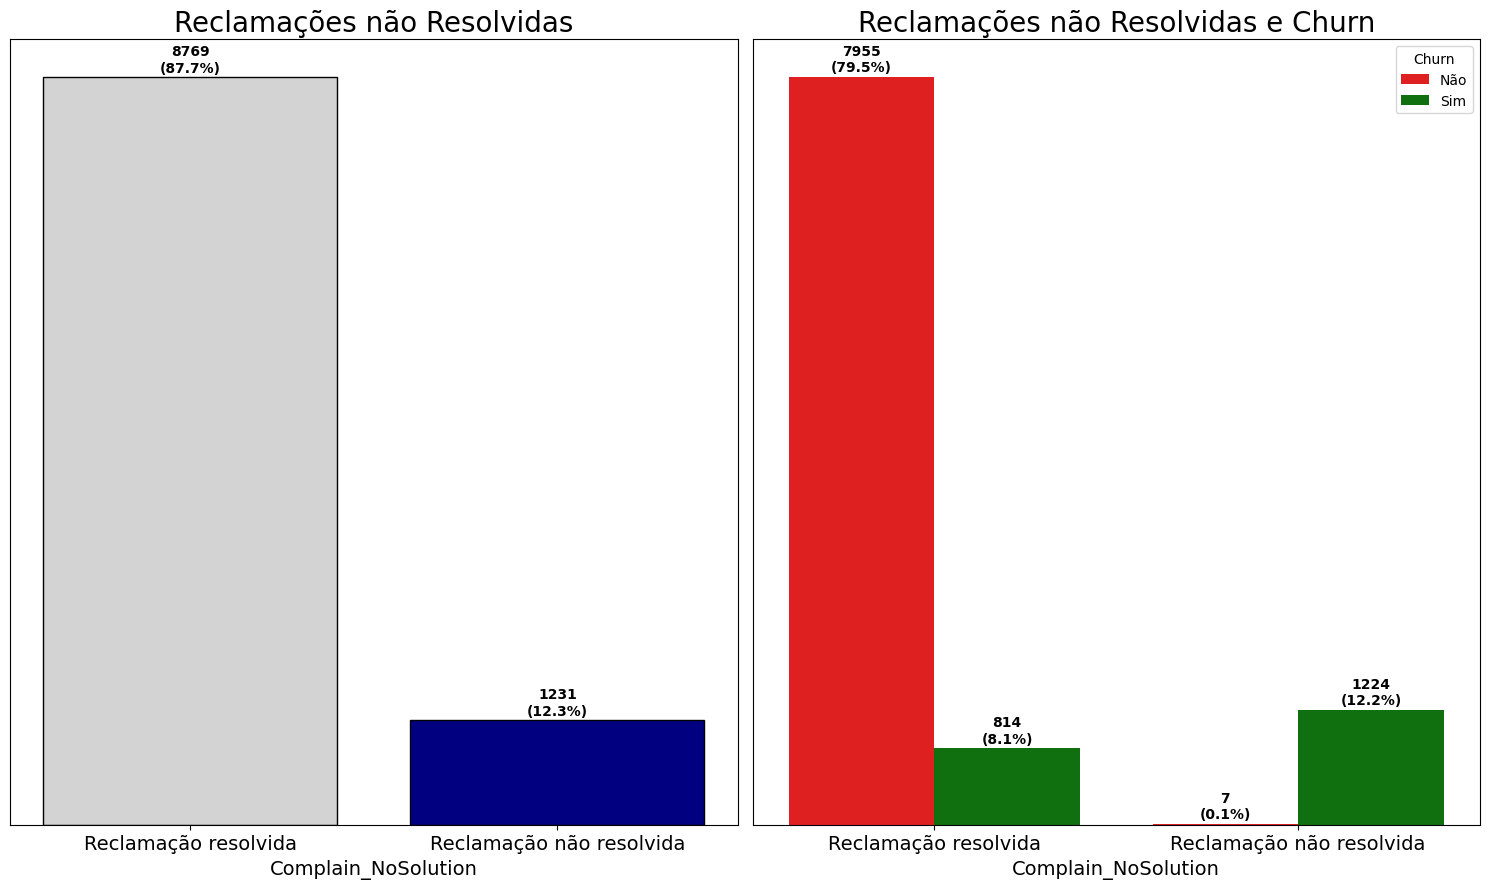

In [35]:
df_selecionado['Complain_NoSolution'] = (
    (df_selecionado['Complain'] == 1) & 
    (df_selecionado['Satisfaction Score'] <= 3)
).astype(int)




fig, axes = plt.subplots(1, 2, figsize=(15, 9))

total_clientes = len(df_selecionado)

# Contagem por Complain_NoSolution (sem filtro de churn)
contagem_flag = df_selecionado['Complain_NoSolution'].value_counts().sort_index()
bars = axes[0].bar(
    contagem_flag.index.astype(str),
    contagem_flag.values,
    color=['lightgray', 'navy'],
    edgecolor='black'
)

axes[0].set_title('Reclamações não Resolvidas', fontsize=20)
axes[0].set_xlabel('Complain_NoSolution', fontsize=14)
axes[0].set_ylabel('Número de Clientes', fontsize=14)

xticklabels = ['Reclamação resolvida' if i == 0 else 'Reclamação não resolvida' for i in contagem_flag.index]
axes[0].set_xticks(contagem_flag.index)
axes[0].set_xticklabels(xticklabels, fontsize=14)
axes[0].set_ylabel('')
axes[0].set_yticks([]) 


# Adiciona número e percentual de clientes em cada barra
for bar, flag in zip(bars, contagem_flag.index):
    altura = bar.get_height()
    perc = altura / total_clientes * 100
    if altura > 0:
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            altura + 60,
            f'{int(altura)}\n({perc:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=10
        )

# Contagem de clientes por Complain_NoSolution e Churn
sns.countplot(
    x='Complain_NoSolution',
    hue='Exited',
    data=df_selecionado,
    palette=['red', 'green'],
    ax=axes[1]
)

axes[1].set_title('Reclamações não Resolvidas e Churn', fontsize=20)
axes[1].set_xlabel('Complain_NoSolution', fontsize=14)
axes[1].set_ylabel('Número de Clientes', fontsize=14)

xticks_labels = ['Reclamação resolvida' if val == 0 else 'Reclamação não resolvida' 
                 for val in sorted(df_selecionado['Complain_NoSolution'].unique())]
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(xticks_labels, fontsize=14)
axes[1].set_ylabel('')
axes[1].set_yticks([]) 


axes[1].legend(title='Churn', labels=['Não', 'Sim'])

# Adiciona número e percentual em cada barra do countplot
for p in axes[1].patches:
    altura = p.get_height()
    if altura > 0:
        percentual = altura / total_clientes * 100
        axes[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 60,
            f'{int(altura)}\n({percentual:.1f}%)',
            ha='center',
            fontweight='bold',
            fontsize=10
        )

plt.tight_layout()
plt.show()


 - Cerca de **12,3% dos clientes tiveram reclamações não resolvidas**, enquanto a grande maioria **(87,7%) teve suas reclamações solucionadas**.
Isso mostra que, embora o volume de reclamações não resolvidas seja menor, ele representa um grupo importante de clientes que podem estar insatisfeitos com o serviço.

 - A diferença no churn entre esses dois grupos é extremamente acentuada: 
    - **entre os clientes com reclamações não resolvidas, praticamente todos realizaram churn (1.224 de 1.231)**.

    - Em contraste, entre os clientes com reclamações resolvidas, apenas 9,2% saíram (814 de 8.769) e eles representam apenas 8,18% do total de clientes que reclamaram.
Isso **indica uma forte relação entre a resolução de reclamações e a permanência dos clientes**, sugerindo que falhas no atendimento de reclamações estão diretamente associadas à evasão, e que resolver reclamações pode ser uma alavanca crucial de retenção.
    - É importante notar que os clientes que registraram reclamações representam entre 8,1% e 12,2% dos casos, uma proporção semelhante à taxa de churn observada na base.Essa semelhança não é coincidência: a variável de reclamação possui uma forte associação com o churn, sugerindo que clientes insatisfeitos ou que enfrentaram problemas têm maior propensão a abandonar o serviço. Além disso, como a variável considera também a pontuação de satisfação, ela pode capturar efeitos mais sutis ou não lineares, oferecendo uma visão mais rica do comportamento do cliente do que uma simples correlação linear.

## 3.11 Analisando variáveis e importância 
 - Antes de entregarmos para os modelos as variáveis, é importante analisar as relações e importâncias entre as variaveis originais e as produzidas por feature engineering. 

### 3.11.1 Matriz de correlação 

**Esta matriz de correlação** utiliza um método que identifica automaticamente o tipo de cada variável e aplica a métrica de associação mais apropriada: correlação de Pearson para pares numéricos, Cramér’s V para variáveis categóricas, e Correlation Ratio (η²) para relações entre variáveis categóricas e numéricas.

* As correlações altas entre as variaveis de feature engineering é esperado, dado que sao feitas a partir de interações. 

* A correlação mais relevante observada foi entre Geography e Balance (e, por consequência, Balance_flag). Isso sugere que o saldo dos clientes pode variar significativamente entre regiões, o que implica que a variável Balance pode estar capturando informações geográficas. Geography é variável sensível no contexto do modelo, essa correlação pode ser um ponto de atenção, pois informações indiretamente relacionadas à localização podem influenciar as decisões do modelo, levantando possíveis preocupações sobre justiça e viés.

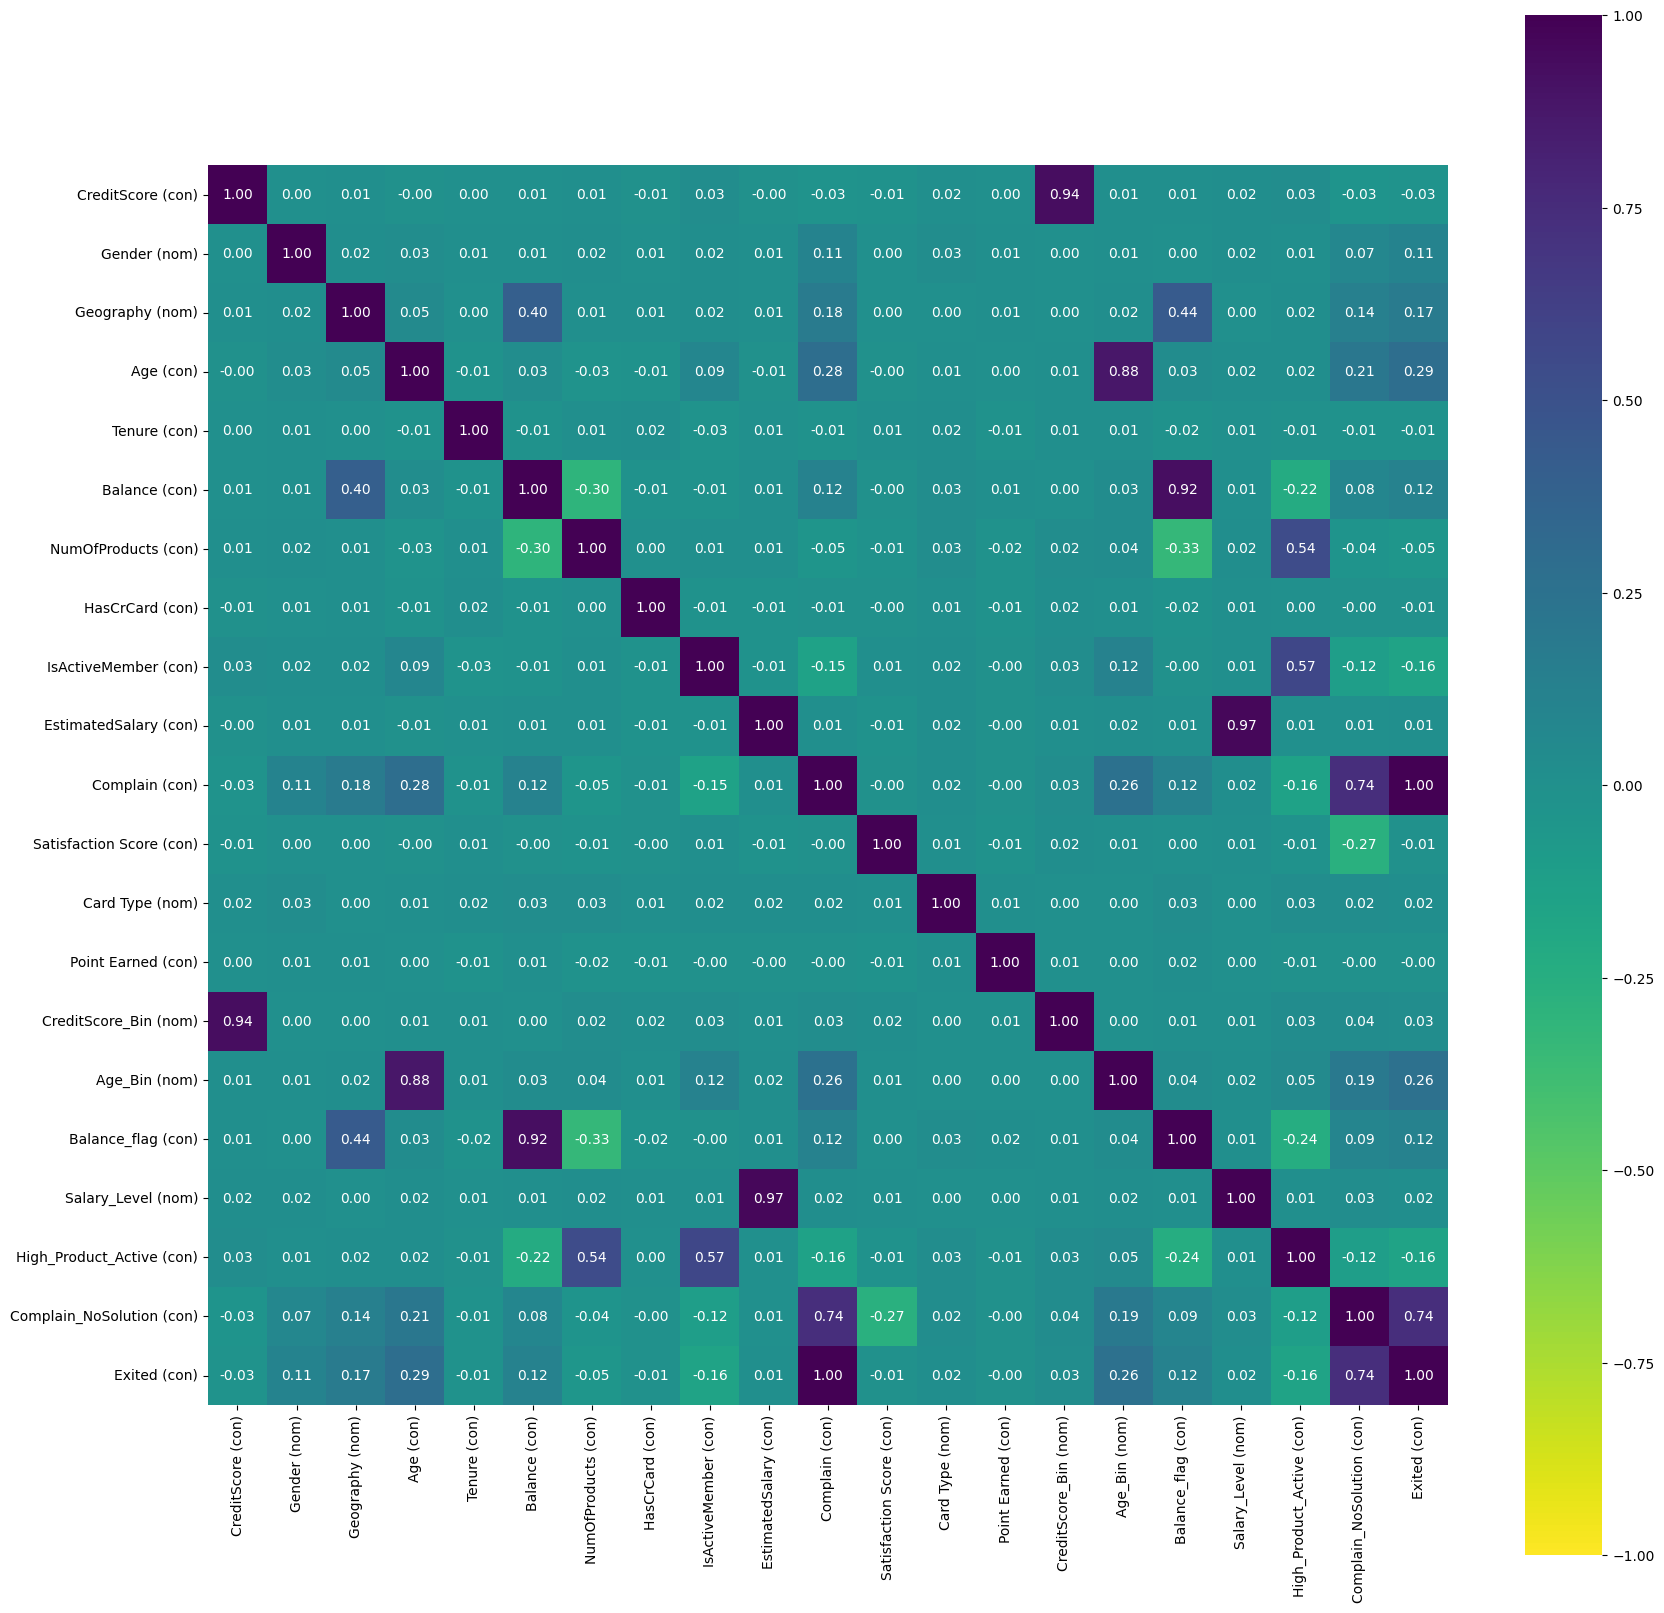

In [36]:

#Organiza o df apenas (def de apoio nada especifico)
def mover_target_para_final(df, target): 
    """
    Move a variavel alvo para o final do df, nao interfere em resultados, é para manter o padrao de legibilidade e facilitar a visualizacao da target
    """
    colunas = [col for col in df.columns if col != target] + [target]
    return df[colunas]



#Aplica def de reorganizar colunas 
df_selecionado = mover_target_para_final(df_selecionado, 'Exited')


associacoes = associations(
    df_selecionado,
    nominal_columns='auto',
    mark_columns=True,
    plot=True,
    figsize=(20, 20),
    cmap='viridis_r'
)


### 3.11.2 **VIF (Variance Inflation Factor) - Dependencias multivaridas :**

 - O VIF (Variance Inflation Factor) é uma métrica que quantifica o quanto uma variável **explicativa** está correlacionada com as **demais variáveis explicativas do modelo**. Para calculá-lo, realiza-se uma regressão linear onde a variável alvo é uma das variáveis explicativas originais, e as outras variáveis do conjunto são usadas como preditoras. Esse processo é repetido para cada variável, gerando um valor de VIF correspondente.

- Trata-se de um teste multivariado que vai além da simples correlação entre pares de variáveis, permitindo diagnosticar a presença de multicolinearidade no conjunto de dados.

 - Os valores de VIF são interpretados da seguinte forma:

      - VIF < 5: sem indicativo relevante de multicolinearidade

      - 5 ≤ VIF < 10: atenção, possível multicolinearidade moderada

      - VIF ≥ 10: forte multicolinearidade

 - **O VIF é especialmente útil em modelos lineares, como regressão linear e regressão logística. Em modelos baseados em árvores e redes neurais a multicolinearidade geralmente não representa um problema significativo.**


 * **Como os modelos serão majoritariamente baseados em árvores e redes neurais, aqui apenas observamos os resultados do VIF sem tomar decisões imediatas de remover ou filtrar variáveis.**

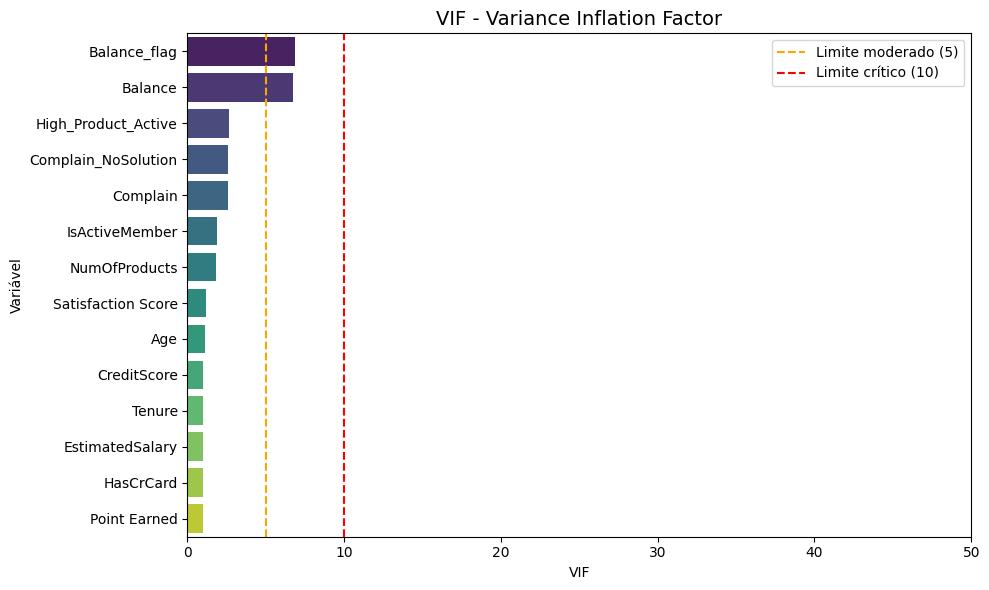

In [37]:
# Seleciona colunas numéricas (sem a target)
X = df_selecionado.select_dtypes(include=['number']).drop(columns='Exited', errors='ignore')

# constante
X_const = add_constant(X)

# VIF
vif_data = pd.DataFrame()
vif_data["Variável"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Remove a constante
vif_data = vif_data[vif_data["Variável"] != "const"]

# Ordena VIF (decrescente)
vif_data = vif_data.sort_values(by="VIF", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=vif_data, x="VIF", y="Variável", palette="viridis")
plt.title("VIF - Variance Inflation Factor", fontsize=14)
plt.xlabel("VIF")
plt.ylabel("Variável")
plt.axvline(x=5, color='orange', linestyle='--', label='Limite moderado (5)')
plt.axvline(x=10, color='red', linestyle='--', label='Limite crítico (10)')
plt.xlim(0, 50)  # Limita o eixo X, para melhor visualização
plt.legend()
plt.tight_layout()
plt.show()



### 3.11.3  Importância das Variáveis com árvore "fraca"

A importância das variáveis foi avaliada por meio de um modelo de árvore “fraco” (LightGBM com poucos estimadores), com o objetivo de identificar quais variáveis mais contribuíram para a performance do modelo.

O critério utilizado foi o ganho (gain), que representa o quanto cada variável ajudou a reduzir o erro de previsão. Como se trata de um problema de classificação binária, esse erro é medido pela log loss (perda logarítmica).
Na prática, quanto maior o ganho, maior a contribuição da variável para melhorar a acurácia do modelo.

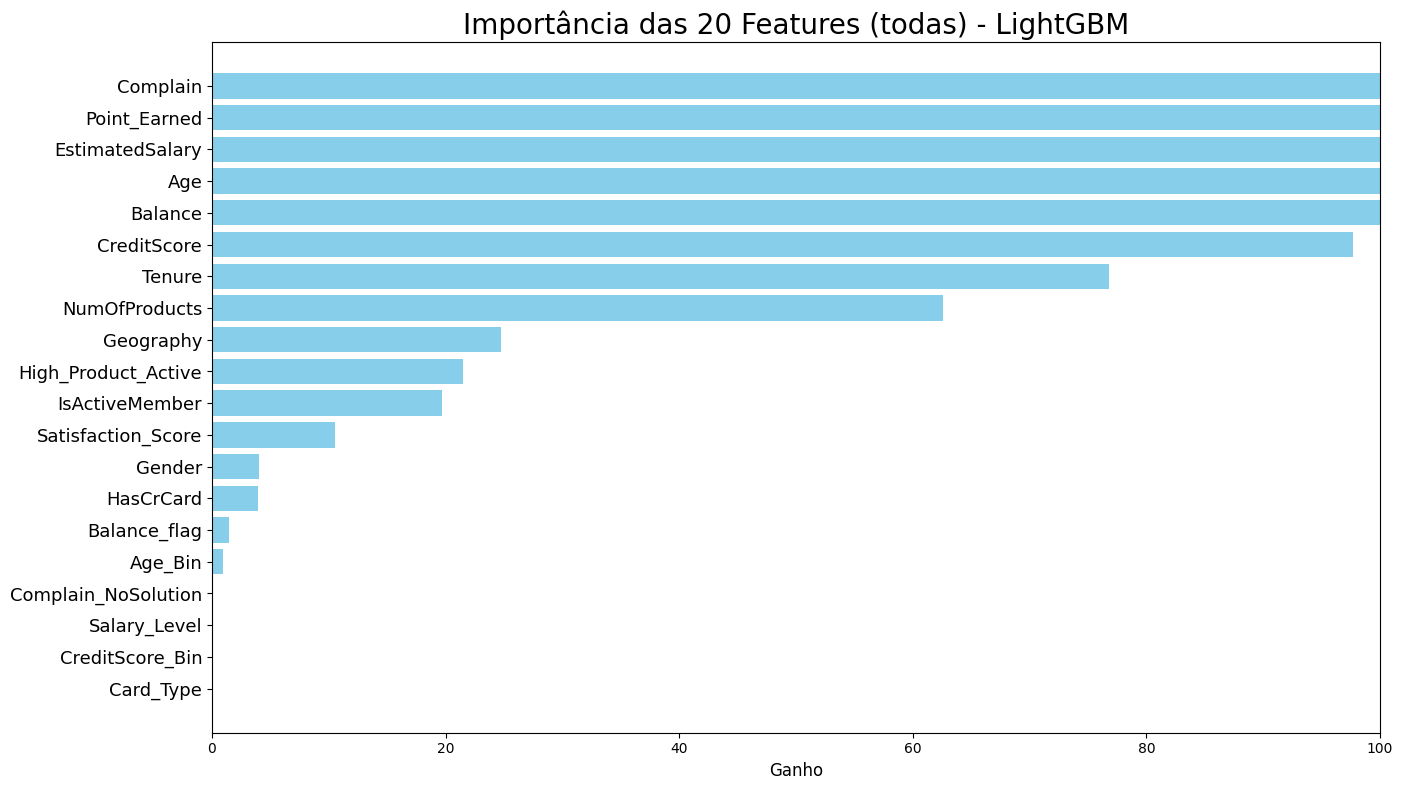


Total de features no importance_df analisadas: 20

Features com importância maior que zero: 17

Nomes das features com importância > 0:
['Complain_NoSolution', 'Age_Bin', 'Balance_flag', 'HasCrCard', 'Gender', 'Satisfaction_Score', 'IsActiveMember', 'High_Product_Active', 'Geography', 'NumOfProducts', 'Tenure', 'CreditScore', 'Balance', 'Age', 'EstimatedSalary', 'Point_Earned', 'Complain']

Features com importância igual a zero: 3

Nomes das features com importância == 0:
['Card_Type', 'CreditScore_Bin', 'Salary_Level']


In [38]:
df_lgb = df_selecionado.copy()

# Padroniza os nomes das colunas
df_lgb.columns = df_lgb.columns.str.replace(" ", "_")

# Detecta colunas categóricas e Converte para category
cat_features = df_lgb.select_dtypes(include=['object']).columns.tolist()

for col in cat_features:
    df_lgb[col] = df_lgb[col].astype('category')

# Atualiza lista 
cat_features = df_lgb.select_dtypes(include=['category']).columns.tolist()

# Separa features e target
target = 'Exited'
X = df_lgb.drop(columns=[target])
y = df_lgb[target]

# Dataset LightGBM
lgb_train = lgb.Dataset(X, label=y, categorical_feature=cat_features, free_raw_data=False)

# Parâmetros
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'seed': 42
}

# Treino
model = lgb.train(params, lgb_train, num_boost_round=500)

# Importância das features
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# df de importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Todas as features
plt.figure(figsize=(14, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title(f'Importância das {len(X.columns)} Features (todas) - LightGBM', fontsize=20)
plt.xlabel('Ganho', fontsize=12)
plt.ylabel('')
plt.xticks(fontsize=10)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.xlim(0, 100)
plt.show()



# printa Análise das features por importância
total_features = len(importance_df)
features_importantes = importance_df[importance_df['Importance'] > 0]
features_zero = importance_df[importance_df['Importance'] == 0]

print(f"\nTotal de features no importance_df analisadas: {total_features}")
print(f"\nFeatures com importância maior que zero: {len(features_importantes)}")
print("\nNomes das features com importância > 0:")
print(features_importantes['Feature'].tolist())

print(f"\nFeatures com importância igual a zero: {len(features_zero)}")
print("\nNomes das features com importância == 0:")
print(features_zero['Feature'].tolist())


### 3.11.4 Análise de Outliers (numéricas)

* Vale destacar que algumas variáveis, embora estejam representadas como numéricas, na prática correspondem a categorias codificadas — como é o caso de Complain, NumOfProducts e da variável-alvo Exited. Por esse motivo, mesmo que os gráficos apresentem valores que à primeira vista pareçam outliers, esses valores não devem ser interpretados como desvios estatísticos, e sim como categorias com menor ou maior frequência. Isso fica evidente ao observar a densidade nos violinplots (área cinza), que reflete a concentração de observações em cada valor. Picos ou dispersões nesses gráficos indicam diferenças na distribuição das classes, e não valores extremos como ocorre em variáveis contínuas.

* Esse comportamento contrasta, por exemplo, com a variável CreditScore, que é de fato contínua e, nesse caso, possíveis outliers podem indicar valores estatisticamente distantes da média

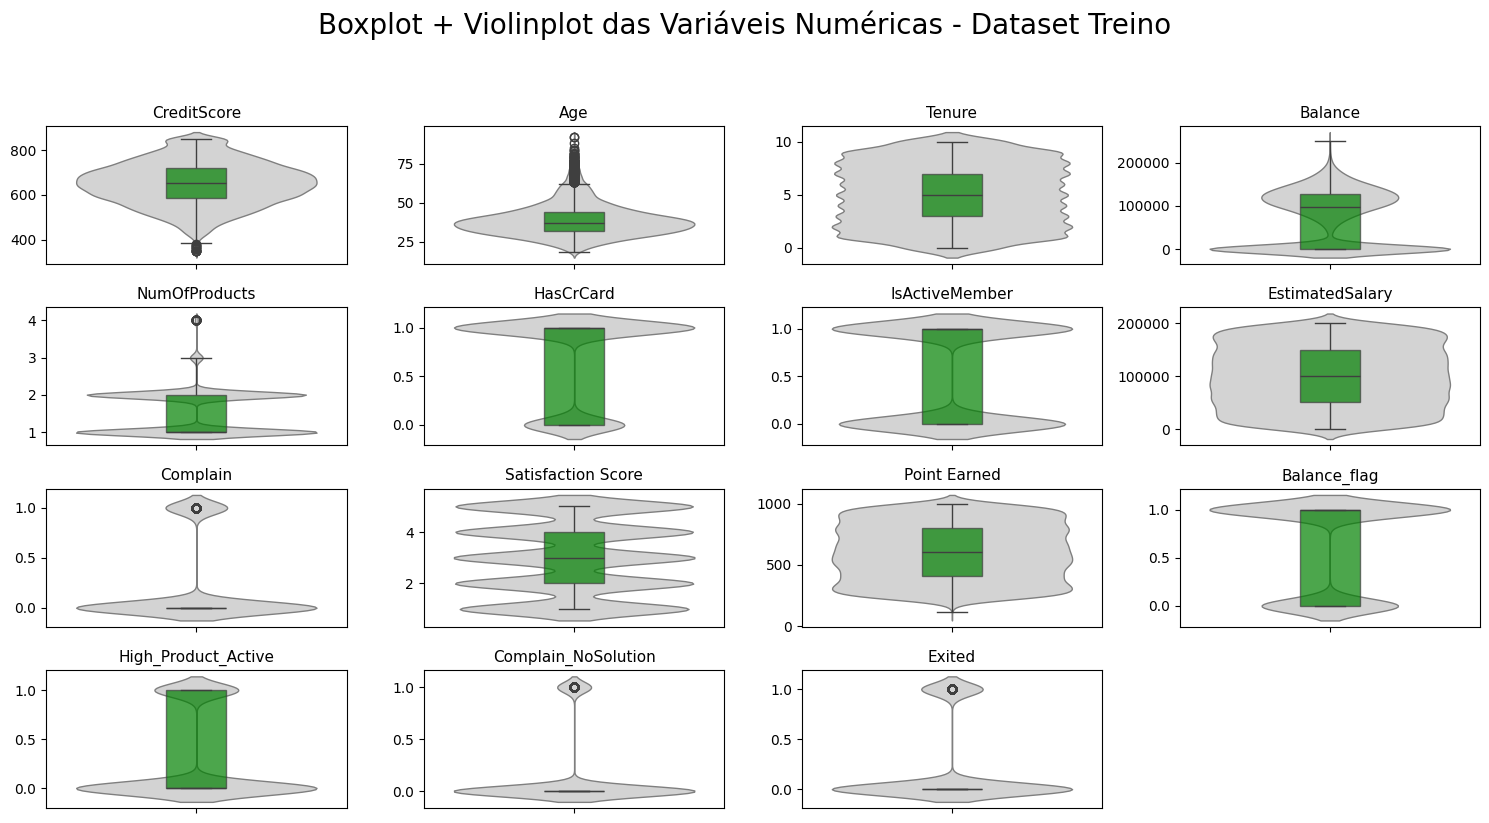

In [39]:
#  numéricas 
variaveis = df_selecionado.select_dtypes(include='number').columns.tolist()


plt.figure(figsize=(15, 12))
# loop de criação de subplots
for i, var in enumerate(variaveis):
    plt.subplot(6, 4, i + 1)  #  6 linhas x 4 colunas 
    
    # violinplot 
    sns.violinplot(y=df_selecionado[var], inner=None, color='lightgray', linewidth=1)
    
    # boxplot 
    sns.boxplot(y=df_selecionado[var],
                boxprops=dict(facecolor='green', alpha=0.7),
                width=0.2)
    
    plt.title(f'{var}', fontsize=11)
    plt.ylabel('')

# título 
plt.suptitle('Boxplot + Violinplot das Variáveis Numéricas - Dataset Treino', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 4. Modelagem 

## 4.1 Separando em Treino e teste 

In [40]:
'''
Aqui utilizamos uma cópia do DataFrame original, contendo apenas as variáveis sem feature engineering.
As variáveis de feature engineering serão criadas posteriormente dentro do Pipeline.
As criações feitas anteriormente foram apenas para análise exploratória e analítica.
As mesmas lógicas aplicadas nasvariáveis de feature engineering serão implementadas no Pipeline.
'''
X = df_selecionado_final.drop('Exited', axis=1)
y = df_selecionado_final['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [41]:
#checando separação e proporções das classes em treino e teste
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Total shape:", X.shape, y.shape)
print('')
print("Checagem duplicidade entre conjuntos:", set(X_train.index) & set(X_test.index))  
print('')
print('Distribuicao Geral das classes :', y.value_counts(normalize=True).map('{:.4%}'.format))
print('')
print('Distribuicao das classes em Treino:', y_train.value_counts(normalize=True).map('{:.4%}'.format) )
print('')
print('Distribuicao das classes em Teste:', y_test.value_counts(normalize=True).map('{:.4%}'.format) )


Train shape: (7000, 14) (7000,)
Test shape: (3000, 14) (3000,)
Total shape: (10000, 14) (10000,)

Checagem duplicidade entre conjuntos: set()

Distribuicao Geral das classes : Exited
0    79.6200%
1    20.3800%
Name: proportion, dtype: object

Distribuicao das classes em Treino: Exited
0    79.6143%
1    20.3857%
Name: proportion, dtype: object

Distribuicao das classes em Teste: Exited
0    79.6333%
1    20.3667%
Name: proportion, dtype: object


## 4.2 Criando Classes Transformadoras Customizadas 

Classes com as transformações usados no Pipeline. Encontra-se no arquivo **Classes_transformadoras_customizadas.py** |

## 4.3 Optuna: Melhores Hiperparametros & Aplicação de Pipelines 

* Organizando as variáveis por tipo de transformação 

In [42]:
print(df_selecionado_final.dtypes)

CreditScore             int64
Gender                 object
Geography              object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
Exited                  int64
dtype: object


In [43]:
# ========================== CONFIGURAÇÃO DE COLUNAS ========================== #


#Colunas que serão removidas do modelo:
#- São meramente identificadoras (RowNumber, CustomerId, Surname, complain).
#- 'Gender' e 'Geography' foram removidas por apresentarem viés de fairness.
#- A remoção de 'Gender' e 'Geography' não impactou drasticamente a performance, 
#indicando que outras variáveis carregavam boa parte da informação que essas possuíam.

colunas_a_remover = ['RowNumber', 
                     'CustomerId', 
                     'Surname', 
                     'complain', 
                     'Gender', 
                     'Geography', 
                     'Age_Grupo' 
                     ]


# Colunas categóricas
# Estas colunas representam variáveis categóricas nominais, ou seja, não possuem relação de ordem natural entre suas categorias.
# Serão tratadas com OneHotEncoder no pipeline.
# No momento, não há colunas categóricas nominais selecionadas para one-hot encoding.
#onehot_cols = []


# Colunas categóricas ordinais
# Estas colunas possuem uma relação de ordem natural entre suas categorias e, por isso, serão tratadas com ordinal encoding.

ordinal_cols = ['Tenure',
                'NumOfProducts',
                'Satisfaction Score',
                'Card Type',
                'CreditScore_Bin',
                'Salary_Level'
                ]
# Lista de categorias para cada coluna ordinal, na mesma ordem de 'ordinal_cols'
# Cada sublista define a ordem explícita das categorias, do menor para o maior valor.
categories_ordinal_cols = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],                  # Tenure: anos de relacionamento com o banco
    [1, 2, 3, 4],                                        # NumOfProducts: quantidade de produtos adquiridos
    [1, 2, 3, 4, 5],                                     # Satisfaction Score: nível de satisfação do cliente
    ['SILVER', 'GOLD', 'PLATINUM', 'DIAMOND'],           # Card Type: tipo de cartão, do mais básico ao mais premium
    ['Baixo', 'Médio', 'Alto'],                          # CreditScore_Bin: faixas de score de crédito
    ['Baixo', 'Médio', 'Alto', 'Muito Alto'],            # Salary_Level: faixas de salário estimado
]


# Colunas candidatas para tratamento de outliers
# Foram avaliadas variáveis como 'CreditScore' e 'Age' para winsorização/truncamento,
# porém os testes não trouxeram ganhos relevantes de performance ou robustez.
# outliers_cols = []

#  Colunas numéricas que serão escaladas
# variáveis contínuas que podem apresentar diferentes escalas e distribuições e alguns modelos são sensíves a isso.
# A aplicação do StandardScaler garante que cada uma tenha média 0 e desvio padrão 1, 
# facilitando o treinamento de modelos sensíveis à escala dos dados (como redes neurais).

scaler_cols = ['CreditScore',
               'EstimatedSalary',
               'Point Earned'
               ]


passthrough_cols = ['Age',
                    'HasCrCard',
                    'IsActiveMember',
                    'Balance_flag',
                    'High_Product_Active',
                    ]






#para Simpler Imputer adaptativo por tipo de variavel: se numerico mediana(para nao ser afetado por outliers), se categorico moda
num_cols = ['CreditScore',
            'EstimatedSalary',
            'Point Earned'
            ]  # ajuste conforme seu dataset

cat_cols = ['Tenure',
            'NumOfProducts',
            'Satisfaction Score',
            'Card Type',
            'CreditScore_Bin',
            'Salary_Level'
            ]  # ajuste conforme seu dataset



# 🆕 Colunas "passthrough" separadas por tipo 
passthrough_cat_cols = ['HasCrCard',
                        'IsActiveMember',
                        'Balance_flag',
                        'High_Product_Active',
                        ]  # exemplo

passthrough_num_cols = ['Age']  # exemplo



In [44]:
def criar_variaveis_derivadas(df):
    """
    Cria variável derivada no DataFrame, para usar na analise de fairness
    """
    df['Age_Grupo'] = np.where(df['Age'] >= 65, 'Idoso', 'Nao_Idoso')
    return df

X_train = criar_variaveis_derivadas(X_train)
X_test = criar_variaveis_derivadas(X_test)

#print(X_train.columns)
#print(X_test.columns)


In [45]:
#warnings.filterwarnings("ignore", message="A module that was compiled using NumPy 1.x cannot be run in NumPy 2.1.3")
#suprime warning de versao do numpy 

# Verifica se há GPU disponível
use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
tree_method_ = "gpu_hist" if use_gpu else "hist"

print(f"Usando GPU: {use_gpu}")
print(f"Método de árvore: {tree_method_}")

Usando GPU: True
Método de árvore: gpu_hist


In [46]:
# ==================== Variáveis Globais ==================== 

# Número de amostras para análise SHAP (explicabilidade)
n_amostras_shap = 100

# Número de trials para otimização de hiperparâmetros (Optuna)
n_trials_ = 1

# Número de folds para validação cruzada estratificada
n_splits_ = 5

# Pesos para ponderação das métricas dentro dos folds de treinamento
# - 'auc': capacidade de separação/ranqueamento
# - 'brier_score': calibração das probabilidades
# - 'log_loss': qualidade da previsão probabilística
# - 'ece': erro de calibração das probabilidades (é equivalente a curva de calibração)

weights_skf_ = {
    'auc': 0.40,
    'brier_score': 0.20,
    'log_loss': 0.20,
    'ece': 0.20
}

# Variáveis sensíveis que apresentaram problemas de fairness e que foram tratadas 
# com reweighing (para balancear grupos sensíveis)
sensitive_cols = ['Age_Grupo', 'Gender', 'Geography']

In [47]:
# ==================== Função de Construção de Pipeline ==================== 
def construir_pipeline(modelo):
    '''
    Define o pipeline a ser usado na cosntrução dos modelos com as seguintes etapas:
    - Criação dos blocos de transformação por tipo de variável (numérico, ordinal, categórico etc).
    - Construção do pré-processador com ColumnTransformer, integrando os blocos.
    - Composição do pipeline final com etapas de engenharia de atributos, remoção de colunas e o modelo estimador.
    '''

    ########### Blocos de transformação ############
    imputador_numerico = SimpleImputer(strategy='median')
    imputador_categorico = SimpleImputer(strategy='most_frequent')

    # imputação + scaler
    numeric_pipeline = Pipeline([
        ('imputer', imputador_numerico),
        ('scaler', StandardScaler())
    ])

    # imputação + transformação + codificação(Ordinal encoder)
    ordinal_pipeline = Pipeline([
        ('imputer', imputador_categorico),
        ('to_df', ToDataFrameTransformer(columns=ordinal_cols)),
        ('ordinal', OrdinalEncoderTransformer(categories=categories_ordinal_cols))
    ])

    #  imputação + transformação + codificação (oen hot)
    #onehot_pipeline = Pipeline([
    #    ('imputer', imputador_categorico),
    #    ('to_df', make_to_df_transformer(onehot_cols)),
    #    ('onehot', OneHotEncoderTransformer())
    #])

    # Imputação + transformação + PassThrough(cat)
    passthrough_cat_pipeline = Pipeline([
        ('imputer', imputador_categorico),
        ('to_df', ToDataFrameTransformer(columns=passthrough_cat_cols)),
        ('passthrough', PassThroughTransformer(passthrough_cat_cols))
    ])

    # Imputação + transformação + PassThrough(num)
    passthrough_num_pipeline = Pipeline([
        ('imputer', imputador_numerico),
        ('to_df', ToDataFrameTransformer(columns=passthrough_num_cols)),
        ('passthrough', PassThroughTransformer(passthrough_num_cols))
    ])

    ########### Preprocessador ############
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, scaler_cols),
            ('ordinal', ordinal_pipeline, ordinal_cols),
            #('onehot', onehot_pipeline, onehot_cols),
            ('passthrough_cat', passthrough_cat_pipeline, passthrough_cat_cols),
            ('passthrough_num', passthrough_num_pipeline, passthrough_num_cols)
        ],
        remainder='drop'
    )

    # ########### Pipeline final ###########
    pipeline = Pipeline([
        ("remover_colunas", RemoveColunas(colunas_para_remover=colunas_a_remover)),
        ("feature_engineering", FeatureEngineeringTransformer()),
        ("remover_colunas_2", RemoveColunas(colunas_para_remover=['Balance'])), #preciso dela para feature engineering, mas não no modelo final
        # ("outlier_flag", outlier_flag),  # se necessário
        ("preprocessamento", preprocessor),
        ("modelo", modelo)
    ])

    return pipeline



In [48]:
# ==================== Função de ANALISE DE CORRELACAO das variaveis usadas dentro do Pipeline ==================== 
def analisar_correlacao_pipeline(X, y):
    '''
    Gera a matriz de correlação entre as features transformadas pelo pipeline e a variável alvo (y).

    Para isso, utiliza o pipeline completo que inclui o pré-processamento e engenharia de features, porém com um modelo DummyClassifier como placeholder. 
    O DummyClassifier, ou modelo "bobo", não realiza aprendizado e serve apenas para viabilizar a execução do pipeline completo, já que a construção do pipeline requer um modelo final. 

    A função aplica o pipeline até a etapa de pré-processamento, extrai as features transformadas com seus nomes corretos e as combina com a variável alvo para análise da correlação.

    Além disso, verifica a existência de valores ausentes e infinitos após as transformações. (COMENTADO)

    '''
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X deve ser um DataFrame com nomes de colunas definidos.")

    pipeline_completo = construir_pipeline(DummyClassifier())
    pipeline_preprocessamento = Pipeline(pipeline_completo.steps[:-1])

    # Fit transform 
    X_transformed = pipeline_preprocessamento.fit_transform(X)

    preprocessor = pipeline_preprocessamento.named_steps['preprocessamento']

    # colunas originais para extrair nomes corretos
    def get_feature_names_from_column_transformer(column_transformer):
        feature_names = []
        for name, transformer, cols in column_transformer.transformers_:
            if transformer == 'drop':
                continue
            elif transformer == 'passthrough':
                feature_names.extend(cols)
            elif isinstance(transformer, Pipeline):
                last_step = transformer.steps[-1][1]
                if hasattr(last_step, 'get_feature_names_out'):
                    # colunas originais
                    feature_names.extend(last_step.get_feature_names_out(cols))
                else:
                    feature_names.extend(cols)
            else:
                if hasattr(transformer, 'get_feature_names_out'):
                    feature_names.extend(transformer.get_feature_names_out(cols))
                else:
                    feature_names.extend(cols)
        return feature_names

    nomes_colunas = get_feature_names_from_column_transformer(preprocessor)

    if X_transformed.shape[1] != len(nomes_colunas):
        print("⚠️ Aviso: número de colunas transformadas difere da lista de nomes. Usando nomes genéricos.")
        nomes_colunas = [f'var_{i}' for i in range(X_transformed.shape[1])]

    df_processado = pd.DataFrame(X_transformed, columns=nomes_colunas)
    df_processado['Exited'] = y.values if hasattr(y, 'values') else y

    plt.figure(figsize=(21, 20))
    sns.heatmap(
        df_processado.corr(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        linewidths=0.5
    )
    plt.title("Matriz de Correlação (variáveis do Pipeline + TARGET)", fontsize=16)
    plt.show()

    #print("\n Verificação de dados ausentes/inválidos após transformação:")
    #print(df_processado.isna().sum()[lambda x: x > 0])
    #print("\n Verificação de valores infinitos após transformação:")
    #print((df_processado == np.inf).sum()[lambda x: x > 0])


In [49]:
# ==================== Função auxiliar para calculo da metrica Expected Calibration Error (ECE) ====================

def compute_ece(y_true, y_proba, n_bins=10):
    """
    Calcula o Expected Calibration Error (ECE).

    O ECE mede o quão bem as probabilidades previstas estão calibradas em relação aos resultados reais.
    Probabilidades bem calibradas significam que, por exemplo, entre os exemplos com 70% de confiança,
    cerca de 70% realmente pertencem à classe positiva.

    A função divide as previsões em `n_bins` faixas uniformes e, em cada bin, calcula a diferença
    entre a confiança média (probabilidade prevista) e a acurácia empírica (proporção de acertos).
    Essas diferenças são ponderadas pela fração de exemplos em cada bin.

    Fórmula:

        ECE = ∑ₖ (|acc(Bₖ) - conf(Bₖ)| * nₖ / N)

    Onde:
    - Bₖ: k-ésimo bin (faixa de probabilidade)
    - acc(Bₖ): acurácia empírica no bin
    - conf(Bₖ): confiança média no bin
    - nₖ: número de exemplos no bin
    - N: total de exemplos

    ******Valores menores indicam melhor calibração. Um ECE de 0 representa calibração perfeita.******

    Parâmetros:
        y_true (array-like): Rótulos reais (0 ou 1).
        y_proba (array-like): Probabilidades previstas.
        n_bins (int): Número de faixas (bins) para discretização.

    Retorna:
        ece (float): O valor do ECE calculado.
    """

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_lower = bin_edges[i]
        bin_upper = bin_edges[i + 1]
        mask = (y_proba > bin_lower) & (y_proba <= bin_upper)
        
        if np.any(mask):
            bin_accuracy = y_true[mask].mean()
            bin_confidence = y_proba[mask].mean()
            bin_weight = np.sum(mask) / len(y_proba)
            ece += np.abs(bin_accuracy - bin_confidence) * bin_weight

    return ece

In [50]:
# ==================== Função auxiliar para calculo de probabilidades da classe positiva ====================

def calcular_probabilidades(pipeline, X_val):
    """
    Calcula as probabilidades preditas para o conjunto de validação a partir de um pipeline treinado,
    detectando automaticamente o tipo do modelo final do pipeline.

    Esta função garante que a saída seja sempre a probabilidade da classe positiva (classe 1),
    independentemente do modelo utilizado (XGBoost, HistGradientBoosting, MLP, etc).

    Para modelos baseados em log-odds (como XGBoost e HistGradientBoosting), converte a saída para probabilidade usando a função sigmoide (expit).
    Para modelos que já retornam probabilidade, utiliza predict_proba.

    Parâmetros:
        pipeline: sklearn.pipeline.Pipeline
            Pipeline treinado contendo o modelo final.

        X_val: array-like ou DataFrame
            Conjunto de validação para o qual as probabilidades serão calculadas.

    Retorna:
        probs: np.ndarray
            Vetor de probabilidades da classe positiva.
    """
    modelo = pipeline[-1]

    if isinstance(modelo, XGBClassifier):
        try:
            log_odds = pipeline.predict(X_val, output_margin=True)
            probs = expit(log_odds)
        except:
            probs = pipeline.predict_proba(X_val)[:, 1]

    elif isinstance(modelo, HistGradientBoostingClassifier):
        log_odds = pipeline.decision_function(X_val)
        probs = expit(log_odds)

    elif isinstance(modelo, MLPClassifier):
        probs = pipeline.predict_proba(X_val)[:, 1]

    elif hasattr(modelo, "predict_proba"):
        probs = pipeline.predict_proba(X_val)[:, 1]

    elif hasattr(modelo, "decision_function"):
        log_odds = pipeline.decision_function(X_val)
        probs = expit(log_odds)

    else:
        raise ValueError(f"Modelo '{modelo.__class__.__name__}' não tem método probabilístico tratado.")

    return probs

In [51]:
# ==================== Função auxiliar de calcular Reweighing para ajuste de Fairness durante o treinamento ====================
def calcular_pesos_reweighing(X, y, sensitive_cols, age_bins=(65, 'Não Idoso', 'Idoso')):
    """

    Reweighing: é uma técnica de fairness para machine learning que ajusta os pesos das AMOSTRAS durante o treinamento (folds de validação cruzada), 
    de modo a compensar possíveis desequilíbrios ou vieses em variáveis sensíveis (como gênero, idade, etc.). 
    O objetivo é reduzir a influência de grupos historicamente desfavorecidos, promovendo decisões mais justas do modelo.

    Essa def Calcula os pesos de reweighing para múltiplas variáveis sensíveis, permitindo ajuste de fairness.

    Parâmetros:
    - X: DataFrame de preditores.
    - y: Série alvo (target).
    - sensitive_cols: lista de colunas sensíveis para fairness
    - age_bins: tupla para binarização da idade caso 'Age' esteja em sensitive_cols.

    Funcionamento:
    - Se 'Age' estiver em sensitive_cols, cria uma coluna binária ('Age_Grupo') conforme o limiar definido em age_bins.
    - Cria grupos combinando todas as variáveis sensíveis.
    - Calcula as frequências marginais dos grupos e do target, e a frequência conjunta grupo-target.
    - Calcula os pesos de reweighing:
        - O peso de cada amostra é proporcional ao produto das frequências marginais dividido pela frequência conjunta, conforme a técnica de reweighing.
        - Retorna um vetor de pesos para ser usado como sample_weight no fit do modelo.

    Retorno:
    - np.array com os pesos de reweighing para cada linha de X.
    """
    df = X.copy()
    df['target'] = y.values

    # Binariza idade se estiver na lista
    if 'Age' in sensitive_cols:
        limiar, label_menor, label_maior = age_bins
        df['Age_Grupo'] = df['Age'].apply(lambda x: label_maior if x >= limiar else label_menor)
        sensitive_cols = [col if col != 'Age' else 'Age_Grupo' for col in sensitive_cols]

    # Cria variavel de grupo combinando as variáveis sensíveis
    df['grupo'] = df[sensitive_cols].astype(str).agg('-'.join, axis=1)

    # Frequências marginais
    p_grupo = df['grupo'].value_counts(normalize=True).to_dict()
    p_target = df['target'].value_counts(normalize=True).to_dict()

    # Frequência conjunta grupo-target
    p_conjunta = df.groupby(['grupo', 'target']).size() / len(df)

    # Calcula pesos
    pesos = {}
    for (g, t), p_xy in p_conjunta.items():
        peso = (p_grupo[g] * p_target[t]) / p_xy
        pesos[(g, t)] = peso

    # Aplica os pesos no df
    vetor_pesos = df.apply(lambda row: pesos[(row['grupo'], row['target'])], axis=1)

    return vetor_pesos.values

In [52]:
# ==================== Função de Geração de Folds e Treinamento (Cross-validation) ====================

def gerar_folds_e_treinar(trial, X, y, pipeline, weights_skf=weights_skf_, n_splits=n_splits_, reweighing=False, sensitive_cols=None):
    """
    Cross-validation com k-folds com suporte a técnicas de fairness e balanceamento:
    - Reweighing: ajusta pesos das amostras para reduzir viés em variáveis sensíveis.
    - Calcula métricas de performance e calibração (AUC, Brier, LogLoss, ECE) e retorna score ponderado.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metricas_acumuladas = {k: [] for k in weights_skf.keys()}
    scores_ponderados = []

    for fold, (idx_treino, idx_valid) in enumerate(skf.split(X, y), 1):
        inicio = time.time()

        X_treino, X_valid = X.iloc[idx_treino], X.iloc[idx_valid]
        y_treino, y_valid = y.iloc[idx_treino], y.iloc[idx_valid]

        # Calcula Pesos Reweighing
        if reweighing and sensitive_cols is not None:
            sample_weight = calcular_pesos_reweighing(X_treino, y_treino, sensitive_cols)
        else:
            sample_weight = None

        # Treinamento
        pipeline.fit(
            X_treino,
            y_treino,
            **({'modelo__sample_weight': sample_weight} if sample_weight is not None else {})
        )

        # Geração de probabilidades
        probs = calcular_probabilidades(pipeline, X_valid)

        # Métricas brutas 
        brier_real = brier_score_loss(y_valid, probs)
        logloss_real = log_loss(y_valid, probs)
        auc = roc_auc_score(y_valid, probs)
        ece_real = compute_ece(y_valid, probs)

        # Normalizações
        brier_score_norm = 1 / (1 + brier_real)
        log_loss_norm = 1 / (1 + logloss_real)
        ece_norm = 1 / (1 + ece_real)

        # Armazena as métricas normalizadas 
        # (sao as usadas para o score ponderado que retorna a cada fold)
        metricas = {
            'auc': auc,
            'brier_score': brier_score_norm,
            'log_loss': log_loss_norm,
            'ece': ece_norm
        }
        # Impressão das métricas reais (sao as usadas para o print)
        metricas_print = {
            'auc': auc,
            'brier_score': brier_real,
            'log_loss': logloss_real,
            'ece': ece_real
        }

        # Acumula métricas 
        for k in metricas_acumuladas:
            metricas_acumuladas[k].append(metricas[k])

        score_fold = sum(weights_skf.get(k, 0) * metricas[k] for k in metricas)
        scores_ponderados.append(score_fold)

        duracao = time.time() - inicio

        # Impressão das métricas do fold 
        # (para acompanhamento do progresso e performance do modelo em cada fold treinado)
        print(
            f"Fold {fold}/{n_splits} | "
            + " | ".join([f"{k}: {v:.4f}" for k, v in metricas_print.items()])
            + f" | Score Ponderado: {score_fold:.4f} | Tempo: {duracao:.2f}s"
        )

    # Salva métricas no trial do Optuna para otimização de hiperparâmetros
    for k, valores in metricas_acumuladas.items():
        trial.set_user_attr(k, np.mean(valores))

    return np.mean(scores_ponderados)

In [53]:
# ==================== Funções Objetivo para Cada Modelo ====================


#  XGBoost Objective

def objective_xgb(trial):
    """
    Função objetivo para otimização de hiperparâmetros do modelo XGBoost via Optuna.
    Realiza busca dos melhores parâmetros, constrói pipeline de pré-processamento, aplica fairness (reweighing) e validação cruzada.
    Retorna o score médio ponderado das métricas de classificação/calibração.
    """

    start_time = time.time()
    print(f"Iniciando trial {trial.number} para XGBoost...")
    
    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    model = XGBClassifier(
        # Booster e objetivo
        booster=booster,
        objective='binary:logitraw',  # log-odds antes da sigmoid, ideal para calibracao

        # Parametros de Crescimento da arvore
        grow_policy=trial.suggest_categorical('grow_policy', ['depthwise']),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        max_bin=trial.suggest_categorical('max_bin', [256, 512]),

        # Parametros de Subamostragem (para evitar overfitting)
        subsample=trial.suggest_float('subsample', 0.5, 0.8),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 1.0),
        colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.6, 1.0),

        # Parametros de Otimização 
        learning_rate=trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        n_estimators=trial.suggest_categorical('n_estimators', [500, 800, 1000, 1200]),

        # Parametros de Regularização
        gamma=trial.suggest_float('gamma', 0.1, 20.0),
        reg_alpha=trial.suggest_float('alpha', 0.5, 10.0, log=True),
        reg_lambda=trial.suggest_float('lambda', 0.5, 10.0, log=True),
        max_delta_step=trial.suggest_float('max_delta_step', 0.8, 2.0),

        # Parametros para tratar desbalanceamento
        scale_pos_weight=trial.suggest_int('scale_pos_weight', 1, 4),

        # Parametros específicos para booster 'dart'
        sample_type=trial.suggest_categorical('sample_type', ['uniform', 'weighted']) if booster == 'dart' else None,
        normalize_type=trial.suggest_categorical('normalize_type', ['tree', 'forest']) if booster == 'dart' else None,
        rate_drop=trial.suggest_float('rate_drop', 0.0, 0.3) if booster == 'dart' else None,
        skip_drop=trial.suggest_float('skip_drop', 0.0, 0.3) if booster == 'dart' else None,

        # Configurações técnicas
        tree_method='gpu_hist',  # usa GPU para acelerar treino
        eval_metric=trial.suggest_categorical('eval_metric', ['logloss', 'auc']),

        silent=1,  # silencia logs
        random_state=42,  # reprodutibilidade
        n_jobs=-1  # paraleliza usando todos os núcleos
    )

    # Constrói o pipeline com o modelo XGBoost
    pipeline = construir_pipeline(model)


    #Chama a função de geração de folds e treinamento 
    try:
        score = gerar_folds_e_treinar(
                                        trial=trial,                       # trial do Optuna
                                        X=X_train,                         # df treino
                                        y=y_train,                         # Target
                                        pipeline=pipeline,                 # Pipeline com o modelo XGBoost
                                        n_splits=5,                        # k-folds 
                                        reweighing=True,                   # Ativa fairness com reweighing
                                        sensitive_cols = sensitive_cols,   # Colunas sensíveis para fairness
                                        weights_skf=weights_skf_           # Pesos para ponderação das métricas
                                    )  

        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e

In [54]:
# HistGradientBoosting  Objective

def objective_histgb(trial):
    """
    Função objetivo para otimização de hiperparâmetros do modelo HistGradientBoosting via Optuna.
    Realiza busca dos melhores parâmetros, constrói pipeline de pré-processamento, aplica fairness (reweighing) e validação cruzada.
    Retorna o score médio ponderado das métricas de classificação/calibração.
    """
    start_time = time.time()
    print(f"Iniciando trial {trial.number} para HistGradientBoosting...")

    model = HistGradientBoostingClassifier(
    # Parametros de Otimização do aprendizado
    learning_rate=trial.suggest_float("learning_rate", 0.005, 0.05, log=True),

    # Parametros de Controle de iterações
    max_iter=trial.suggest_int("max_iter", 400, 1000),

    # Parametros de Crescimento da árvore
    max_depth=trial.suggest_int("max_depth", 3, 5),  
    max_leaf_nodes=trial.suggest_int("max_leaf_nodes", 20, 70),  
    min_samples_leaf=trial.suggest_int("min_samples_leaf", 20, 100),  

    # Parametros de Regularização
    l2_regularization=trial.suggest_float("l2_regularization", 1.0, 20.0, log=True), 

    # Parametros de Discretização dos dados
    max_bins=trial.suggest_int("max_bins", 32, 96),  

    # Parametros de Early Stopping e validação
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20, 

    # Outros Parametros 
    class_weight="balanced", 
    )


    # Constrói o pipeline com o modelo HistGradientBoosting
    pipeline = construir_pipeline(model)

    # Chama a função de geração de folds e treinamento 
    try:
        score = gerar_folds_e_treinar(
            trial=trial,                       # trial do Optuna
            X=X_train,                         # df treino
            y=y_train,                         # Target
            pipeline=pipeline,                 # Pipeline com o modelo HistGradientBoosting
            n_splits=5,                        # k-folds 
            reweighing=True,                   # Ativa fairness com reweighing
            sensitive_cols=sensitive_cols,     # Colunas sensíveis para fairness
            weights_skf=weights_skf_           # Pesos para ponderação das métricas
        )

        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e



In [55]:
# Rede Neural (NN) MLP Objective 

def objective_NN_MLP(trial):
    """
    Função objetivo para otimização de hiperparâmetros do modelo MLPClassifier via Optuna.
    Realiza busca dos melhores parâmetros, constrói pipeline de pré-processamento e validação cruzada.
    O reweighing está desativado pois o MLP do sklearn não suporta sample_weight nativamente.
    Retorna o score médio ponderado das métricas de classificação/calibração.
    """
    start_time = time.time()
    print(f"Iniciando trial {trial.number} para MLP...")

    # Configurações de camadas ocultas
    hidden_layer_configs = {
        "config_1": (50,),
        "config_2": (100,),
        "config_3": (50, 50),
        "config_4": (100, 100, 50)
    }
    config_key = trial.suggest_categorical("hidden_layer_config", list(hidden_layer_configs.keys()))
    hidden_layer_sizes = hidden_layer_configs[config_key]

    # Instancia modelo MLPClassifier 
    model = MLPClassifier(
        # Arquitetura da rede (camadas ocultas)
        hidden_layer_sizes=hidden_layer_sizes,  

        # Função de ativação
        activation=trial.suggest_categorical("activation", ["relu", "tanh", "logistic"]),  

        # Algoritmo de otimização
        solver=trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"]),  

        # Regularização
        alpha=trial.suggest_float("alpha", 1e-4, 0.1, log=True),  # penalidade L2

        # Taxa de aprendizado
        learning_rate=trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),  # política de lr
        learning_rate_init=trial.suggest_float("learning_rate_init", 1e-4, 0.05, log=True),  # valor inicial de lr

        # Controle de iterações e parada antecipada
        max_iter=trial.suggest_int("max_iter", 50, 600),  # número máximo de épocas
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.2,

        # Reprodutibilidade
        random_state=42
    )

    # Constrói o pipeline com o modelo MLP
    pipeline = construir_pipeline(model)

    # Chama a função de geração de folds e treinamento
    try:
        score = gerar_folds_e_treinar(
            trial=trial,                       # trial do Optuna
            X=X_train,                         # df treino
            y=y_train,                         # Target
            pipeline=pipeline,                 # Pipeline com o modelo MLP
            n_splits=5,                        # k-folds
            reweighing=False,                  # reweighing desativado (MLP não suporta sample_weight)
            sensitive_cols=sensitive_cols,     # Colunas sensíveis para fairness
            weights_skf=weights_skf_           # Pesos para ponderação das métricas
        )

        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e

In [56]:
#dicionário de modelos a serem otimizados (são as def's objetivo)
models = {
    "HistGb": objective_histgb,
    "NN_MLP": objective_NN_MLP,
    "XGBoost": objective_xgb
}

best_hyperparams = {}  # Armazena os melhores hiperparâmetros encontrados para cada modelo
storage_ = "sqlite:///Churn_study_models_by_Optuna.db"

def optimize_all_models():
    """
    Executa a otimização de hiperparâmetros com Optuna para todos os modelos definidos em `models`.

    Para cada modelo:
    - Cria (ou continua) um estudo Optuna com nome específico no banco SQLite.
    - Utiliza o TPESampler com parâmetros customizados para busca eficiente.
    - Salva os melhores hiperparâmetros encontrados no dicionário `best_hyperparams`.

    Visualização dos estudos:
    - Para acompanhar os estudos via navegador, execute no terminal:
      optuna-dashboard "sqlite:///CAMINHO/arquivo_estudo.db"
      (Use o caminho absoluto do arquivo após as três barras)
      Exemplo: optuna-dashboard "sqlite:///C:/Users/USUARIO_X/Documentos/GitHub/PASTA_X/Churn_predict/PASTA_Y/Churn_study_models_by_Optuna.db"
    - O dashboard só carrega se ao menos um estudo já tiver sido iniciado ou salvo.

    Observação:
    - O banco pode ser criado previamente com:
        storage = optuna.storages.RDBStorage(url="sqlite:///Churn_study_models_by_Optuna.db")
      (Execute antes para criar o banco, se necessário)

    Para conferir se os estudos foram gravados no banco, rode:
        storage = optuna.storages.RDBStorage(url="sqlite:///Churn_study_models_by_Optuna.db")
        studies = optuna.study.get_all_study_summaries(storage=storage)
        print([s.study_name for s in studies])
    """
    for model_name, objective_func in models.items():
        print(f"\nIniciando otimização para o modelo: {model_name}\n")
        optuna.logging.set_verbosity(optuna.logging.INFO)
        print('')

        #  TPESampler
        sampler_ = optuna.samplers.TPESampler(
            n_startup_trials=50,            # Exploração inicial do espaço de busca
            n_ei_candidates=50,             # Número de candidatos gerados por iteração
            group=True,                     # Captura dependências entre parâmetros (group e multivariate)
            seed=42,                        # Semente de reprodutibilidade
            multivariate=True,              # permite dependências entre parâmetros
            warn_independent_sampling=False # evita avisos sobre amostragem independente
        )

        # Cria ou carrega (se já iniciado) estudo Optuna para o modelo atual
        study = optuna.create_study(
            study_name=f"{model_name}_study_c_Reweighing",
            storage=storage_,
            sampler=sampler_,
            direction='maximize',
            load_if_exists=True
        )

        # Executa a otimização de hiperparâmetros
        study.optimize(objective_func, n_trials=n_trials_)
        best_params = study.best_params
        best_hyperparams[model_name] = best_params

        # Exibe os melhores hiperparâmetros encontrados
        print(f"\nMELHORES HIPERPARÂMETROS PARA O MODELO {model_name}")
        print("═" * 60)
        for param, value in best_params.items():
            print(f"{param:<25}{str(value):<15}")
        print("═" * 60)

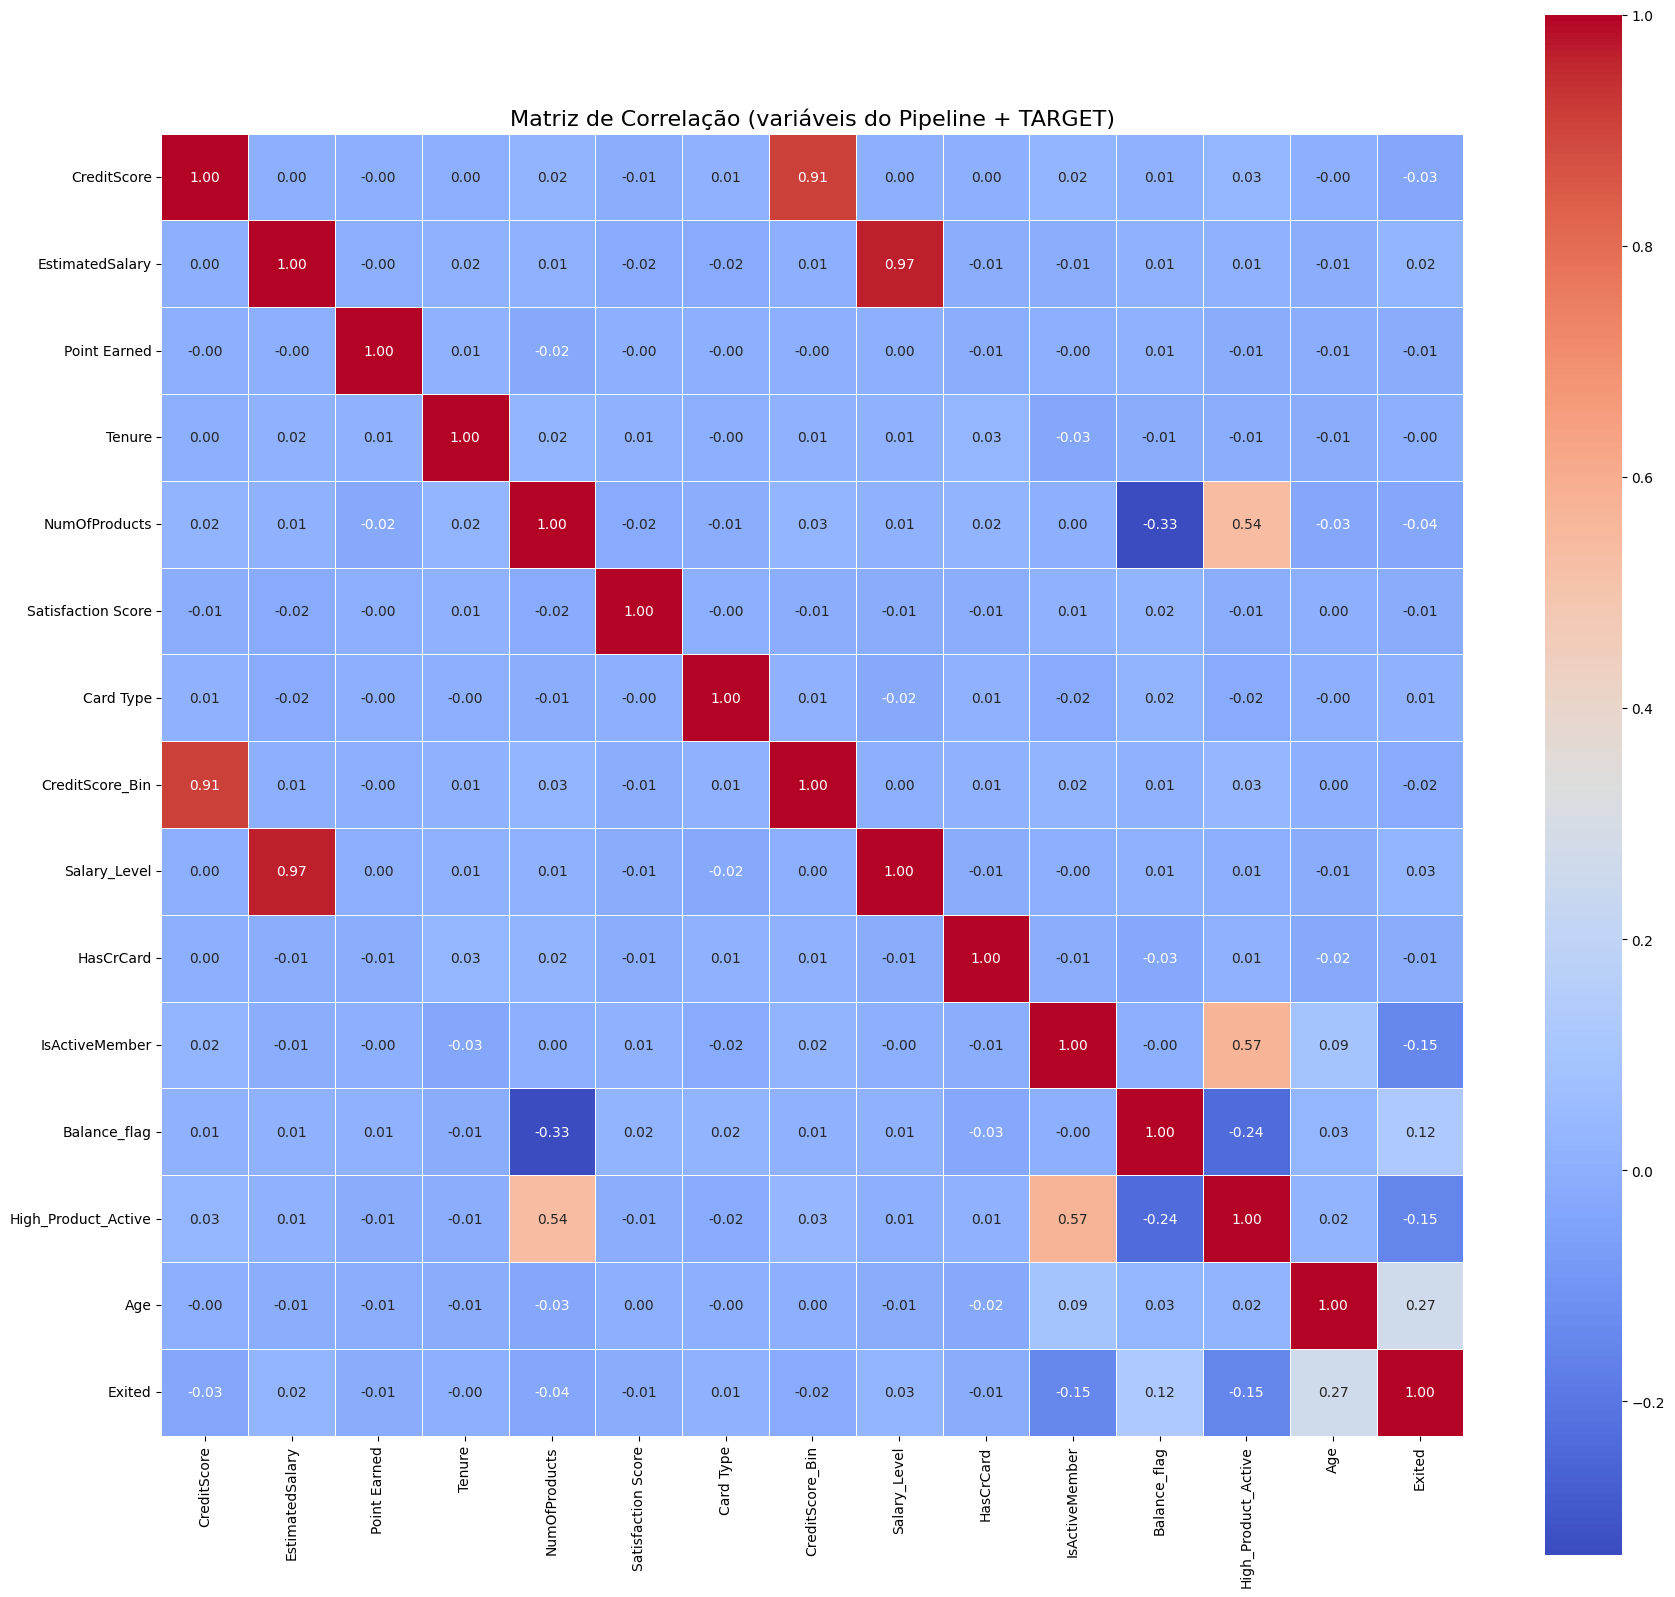

In [57]:
# Matriz de correlação das variáveis após o pré-processamento do pipeline (aplicando modelo "dummy" DummyClassifier como placeholder)
# A descrição está na própria função def 

analisar_correlacao_pipeline(X_train, y_train)



In [58]:
# Inicia treinamento e busca do optuna 
optimize_all_models()


Iniciando otimização para o modelo: HistGb




[I 2025-07-26 01:20:55,508] Using an existing study with name 'HistGb_study_c_Reweighing' instead of creating a new one.


Iniciando trial 522 para HistGradientBoosting...
Fold 1/5 | auc: 0.8404 | brier_score: 0.1506 | log_loss: 0.4650 | ece: 0.1842 | Score Ponderado: 0.8154 | Tempo: 1.03s
Fold 2/5 | auc: 0.8358 | brier_score: 0.1507 | log_loss: 0.4679 | ece: 0.1857 | Score Ponderado: 0.8130 | Tempo: 0.52s
Fold 3/5 | auc: 0.8308 | brier_score: 0.1613 | log_loss: 0.4946 | ece: 0.1999 | Score Ponderado: 0.8050 | Tempo: 0.51s
Fold 4/5 | auc: 0.8208 | brier_score: 0.1522 | log_loss: 0.4716 | ece: 0.1681 | Score Ponderado: 0.8090 | Tempo: 0.55s


[I 2025-07-26 01:20:59,319] Trial 522 finished with value: 0.8097896716398619 and parameters: {'learning_rate': 0.026191399622727932, 'max_iter': 881, 'max_depth': 4, 'max_leaf_nodes': 61, 'min_samples_leaf': 62, 'l2_regularization': 1.3545697766118048, 'max_bins': 60}. Best is trial 509 with value: 0.8125994429032144.
[I 2025-07-26 01:20:59,369] Using an existing study with name 'NN_MLP_study_c_Reweighing' instead of creating a new one.


Fold 5/5 | auc: 0.8336 | brier_score: 0.1595 | log_loss: 0.4893 | ece: 0.2030 | Score Ponderado: 0.8065 | Tempo: 0.40s
✅ Trial 522 finalizado | Score: 0.8098 | Tempo: 3.28 segundos

MELHORES HIPERPARÂMETROS PARA O MODELO HistGb
════════════════════════════════════════════════════════════
learning_rate            0.03824454874411644
max_iter                 876            
max_depth                5              
max_leaf_nodes           63             
min_samples_leaf         89             
l2_regularization        1.1218612401431949
max_bins                 74             
════════════════════════════════════════════════════════════

Iniciando otimização para o modelo: NN_MLP


Iniciando trial 520 para MLP...
Fold 1/5 | auc: 0.8378 | brier_score: 0.1106 | log_loss: 0.3601 | ece: 0.0311 | Score Ponderado: 0.8562 | Tempo: 9.93s
Fold 2/5 | auc: 0.8206 | brier_score: 0.1192 | log_loss: 0.3863 | ece: 0.0480 | Score Ponderado: 0.8421 | Tempo: 7.27s
Fold 3/5 | auc: 0.8240 | brier_score: 0.

[I 2025-07-26 01:21:49,880] Trial 520 finished with value: 0.8459681374336754 and parameters: {'hidden_layer_config': 'config_4', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0956744076950573, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002250228769551523, 'max_iter': 308}. Best is trial 412 with value: 0.8551461037562514.
[I 2025-07-26 01:21:49,930] Using an existing study with name 'XGBoost_study_c_Reweighing' instead of creating a new one.


Fold 5/5 | auc: 0.8260 | brier_score: 0.1161 | log_loss: 0.3759 | ece: 0.0326 | Score Ponderado: 0.8487 | Tempo: 13.48s
✅ Trial 520 finalizado | Score: 0.8460 | Tempo: 49.97 segundos

MELHORES HIPERPARÂMETROS PARA O MODELO NN_MLP
════════════════════════════════════════════════════════════
hidden_layer_config      config_4       
activation               tanh           
solver                   adam           
alpha                    0.02149070325333646
learning_rate            invscaling     
learning_rate_init       0.0019596380010535965
max_iter                 350            
════════════════════════════════════════════════════════════

Iniciando otimização para o modelo: XGBoost


Iniciando trial 475 para XGBoost...
Fold 1/5 | auc: 0.8436 | brier_score: 0.1146 | log_loss: 0.3733 | ece: 0.0773 | Score Ponderado: 0.8481 | Tempo: 216.95s
Fold 2/5 | auc: 0.8282 | brier_score: 0.1189 | log_loss: 0.3848 | ece: 0.0678 | Score Ponderado: 0.8418 | Tempo: 247.28s
Fold 3/5 | auc: 0.8206 | b

[I 2025-07-26 01:40:02,617] Trial 475 finished with value: 0.8391975953758427 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'max_depth': 5, 'min_child_weight': 4, 'max_bin': 512, 'subsample': 0.6498574422293796, 'colsample_bytree': 0.9967569841473609, 'colsample_bylevel': 0.8586192299125365, 'learning_rate': 0.07792602329766816, 'n_estimators': 800, 'gamma': 4.424465320409145, 'alpha': 0.7593980986466712, 'lambda': 3.1280579503616393, 'max_delta_step': 1.6884215434329937, 'scale_pos_weight': 2, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19380381822357376, 'skip_drop': 0.2812175262831833, 'eval_metric': 'auc'}. Best is trial 385 with value: 0.8563973033448438.


Fold 5/5 | auc: 0.8278 | brier_score: 0.1223 | log_loss: 0.3940 | ece: 0.0844 | Score Ponderado: 0.8372 | Tempo: 234.77s
✅ Trial 475 finalizado | Score: 0.8392 | Tempo: 1092.03 segundos

MELHORES HIPERPARÂMETROS PARA O MODELO XGBoost
════════════════════════════════════════════════════════════
booster                  gbtree         
grow_policy              depthwise      
max_depth                3              
min_child_weight         2              
max_bin                  256            
subsample                0.7579791737247483
colsample_bytree         0.8017454535267157
colsample_bylevel        0.961346394039583
learning_rate            0.07781745298818274
n_estimators             1200           
gamma                    5.475966251718459
alpha                    2.3891530594651496
lambda                   3.3922760213563676
max_delta_step           1.8299751236859747
scale_pos_weight         1              
eval_metric              auc            
══════════════════════════

In [59]:
# ==================== Funções auxiliares para a Função de Validação ===================================

def cross_validate_model_with_metrics(pipeline, X, y, n_splits=5, weights_skf=weights_skf_, reweighing=False, sensitive_cols=None):
    """
    Função de validação cruzada estratificada, calcula métricas e pondera resultados.
    Suporta modelos que retornam log-odds (ex: XGBoost com 'logitraw', HistGB).
    Normaliza métricas de log loss, brier e ECE para manter valores entre 0 e 1, facilitando a avaliação.
    Permite reweighing para fairness, aplicando pesos nas amostras conforme variáveis sensíveis.

    Parâmetros:
        pipeline: Pipeline sklearn com o modelo.
        X, y: preditivas e alvo.
        n_splits: Número de folds na validação cruzada.
        weights_skf: Dicionário de pesos para cada métrica.
        reweighing: Se True, aplica reweighing para fairness.
        sensitive_cols: Colunas sensíveis para cálculo de pesos (usado no reweighing).

    Retorna:
        medias_metricas: Média das métricas calculadas nos folds.
        score_ponderado_medio: Score final ponderado pelas métricas.
    """

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metricas_acumuladas = {metric: [] for metric in weights_skf.keys()}
    scores_ponderados = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Aplica reweighing para fairness se solicitado
        sample_weight = None
        if reweighing:
            sample_weight = calcular_pesos_reweighing(X_train_fold, y_train_fold, sensitive_cols)

        # Verifica se o modelo final do pipeline aceita sample_weight
        ultimo_modelo = pipeline.steps[-1][1]
        suporta_sample_weight = hasattr(ultimo_modelo, 'fit') and \
                                'sample_weight' in ultimo_modelo.fit.__code__.co_varnames

        # Treina o pipeline, passando sample_weight se suportado
        if suporta_sample_weight and sample_weight is not None:
            pipeline.fit(X_train_fold, y_train_fold, sample_weight=sample_weight)
        else:
            pipeline.fit(X_train_fold, y_train_fold)

        # Calcula probabilidades de predição para o fold de validação
        probs = calcular_probabilidades(pipeline, X_val_fold)

        # Calcula métricas REAIS para o fold
        auc = roc_auc_score(y_val_fold, probs)
        brier_real = brier_score_loss(y_val_fold, probs)
        logloss_real = log_loss(y_val_fold, probs)
        ece_real = compute_ece(y_val_fold, probs)

        metricas = {
            'auc': auc,
            'brier_score': brier_real,
            'log_loss': logloss_real,
            'ece': ece_real
        }

        # Normalização das métricas para que todas fiquem no mesmo sentido: quanto maior, melhor.
        # Para AUC, já é maximizável (quanto maior, melhor).
        # Para brier_score, log_loss e ECE, quanto menor, melhor, então aplicado a transformação 1/(1 + métrica)
        # Isso inverte o sentido e normaliza para o intervalo 0 e 1 , facilitando o cálculo do score ponderado.

        metricas_para_score = {
            'auc': auc,                               # já é maximizável
            'brier_score': 1 / (1 + brier_real),      # normalizado para maior é melhor
            'log_loss': 1 / (1 + logloss_real),       # normalizado para maior é melhor
            'ece': 1 / (1 + ece_real)                 # normalizado para maior é melhor
        }

        # Acumula métricas de cada fold
        for k in metricas_acumuladas:
            metricas_acumuladas[k].append(metricas[k])

        # Calcula score ponderado do fold usando os pesos fornecidos
        score_fold = sum(weights_skf.get(k, 0) * metricas_para_score.get(k, 0) for k in metricas_para_score)
        scores_ponderados.append(score_fold)

    # Calcula médias das métricas e do score ponderado final
    medias_metricas = {k: np.mean(v) for k, v in metricas_acumuladas.items()}
    score_ponderado_medio = np.mean(scores_ponderados)

    return medias_metricas, score_ponderado_medio

In [60]:
def print_metrics(model_name, metrics_dict, weighted_score=None):
    """
    Exibe as métricas médias de forma formatada.
    Se weighted_score for passado, exibe como uma métrica extra no final.
    """
    print(f"Métricas médias dos folds para o modelo {model_name}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")
    if weighted_score is not None:
        print(f"Score Ponderado: {weighted_score:.4f}")
    print("═" * 60)

In [61]:
def get_model_from_params(model_name, best_params):
    """
    Retorna uma instância do modelo de classificação configurada com os melhores hiperparâmetros encontrados pelo Optuna.

    Parâmetros:
        model_name (str): Nome do modelo ('XGBoost', 'HistGb', 'NN_MLP').
        best_params (dict): Dicionário com os melhores hiperparâmetros para configurar o modelo.

    Retorna:
        Instância do classificador configurado conforme os parâmetros.
    """
    if model_name == 'XGBoost':
        return XGBClassifier(
            objective='binary:logitraw',
            booster=best_params['booster'],  

            grow_policy=best_params['grow_policy'],
            max_depth=best_params['max_depth'],
            min_child_weight=best_params['min_child_weight'],
            max_bin=best_params['max_bin'],

            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            colsample_bylevel=best_params['colsample_bylevel'],

            learning_rate=best_params['learning_rate'],
            n_estimators=best_params['n_estimators'],

            gamma=best_params['gamma'],
            reg_alpha=best_params['alpha'],
            reg_lambda=best_params['lambda'],
            max_delta_step=best_params['max_delta_step'],

            scale_pos_weight=best_params['scale_pos_weight'],

            # Parâmetros exclusivos do booster 'dart'
            sample_type=best_params['sample_type'] if best_params['booster'] == 'dart' else None,
            normalize_type=best_params['normalize_type'] if best_params['booster'] == 'dart' else None,
            rate_drop=best_params['rate_drop'] if best_params['booster'] == 'dart' else None,
            skip_drop=best_params['skip_drop'] if best_params['booster'] == 'dart' else None,
            eval_metric=best_params['eval_metric'],

            #fixos
            tree_method='gpu_hist',
            silent=1,
            random_state=42,
            n_jobs=-1
        )

    elif model_name == 'HistGb':
        return HistGradientBoostingClassifier(
            learning_rate=best_params['learning_rate'],
            max_iter=best_params['max_iter'],
            max_depth=best_params['max_depth'],
            max_leaf_nodes=best_params['max_leaf_nodes'],
            min_samples_leaf=best_params['min_samples_leaf'],
            l2_regularization=best_params['l2_regularization'],
            max_bins=best_params['max_bins'],

            # opcionais/fixos
            early_stopping=best_params.get('early_stopping', True),
            validation_fraction=best_params.get('validation_fraction', 0.1),
            n_iter_no_change=best_params.get('n_iter_no_change', 20),

            class_weight='balanced',
            random_state=42
        )

    elif model_name == 'NN_MLP':
        hidden_layer_configs = {
            "config_1": (250,),
            "config_2": (150, 100),
            "config_3": (200, 150),
            "config_4": (200, 150, 100)
        }
        return MLPClassifier(
            hidden_layer_sizes=hidden_layer_configs[best_params["hidden_layer_config"]],
            activation=best_params["activation"],
            solver=best_params["solver"],
            alpha=best_params["alpha"],
            learning_rate=best_params["learning_rate"],           
            learning_rate_init=best_params["learning_rate_init"], 
            max_iter=best_params["max_iter"],

            #fixos
            early_stopping=True,
            n_iter_no_change=20,
            validation_fraction=0.2,
            random_state=42
        )

    else:
        raise ValueError(f"❌ Modelo '{model_name}' não reconhecido!")

In [62]:
# ==================== Função de Validação (com K-Folds) ===================================
def validate_with_best_params(X_train, y_train, models, best_hyperparams, n_splits=5, reweighing=False, sensitive_cols=None):
    """
    Valida os modelos com os melhores hiperparâmetros encontrados pelo Optuna usando validação cruzada (K-Folds).

    Explicação:
    - Avalia a performance dos modelos nos dados de treino com validação cruzada. 
    Utiliza os melhores parâmetros encontrados pelo Optuna para cada modelo. 
    Calcula e exibe as métricas médias para cada modelo.

    Parâmetros:
    X_train, y_train: Dados de treino (preditoras e alvo).
    models: Dicionário com nomes dos modelos e suas funções construtoras.
    best_hyperparams: Dicionário com os melhores hiperparâmetros para cada modelo.
    n_splits: Número de folds na validação cruzada.
    reweighing: Se True, aplica reweighing para fairness.
    sensitive_cols: Colunas sensíveis para cálculo de pesos (usado no reweighing).

    Saída:
    - Dicionário com as métricas médias para cada modelo avaliado.

    Observações:
    - O reweighing para fairness é aplicado apenas para modelos que suportam sample_weight (não é aplicado para MLP).
    """
    results = {}

    for model_name, model_func in models.items():
        print(f"Validando modelo {model_name} com K-Folds...")

        best_params = best_hyperparams[model_name]
        model = get_model_from_params(model_name, best_params)
        pipeline = construir_pipeline(model)

        # Aplica reweighing apenas para modelos que suportam sample_weight
        aplica_reweighing = False if model_name == 'NN_MLP' else True

        mean_metrics, mean_score = cross_validate_model_with_metrics(
            pipeline, 
            X_train, 
            y_train,
            n_splits=n_splits,
            reweighing=aplica_reweighing,
            sensitive_cols=sensitive_cols,
            weights_skf=weights_skf_
        )

        results[model_name] = mean_metrics
        print_metrics(model_name, mean_metrics, mean_score)


In [63]:
#Executa a validação com os melhores parâmetros encontrados pelo Optuna

final_results = validate_with_best_params(
    X_train, y_train, 
    models, best_hyperparams, 
    reweighing=True, 
    sensitive_cols=sensitive_cols
)


Validando modelo HistGb com K-Folds...
Métricas médias dos folds para o modelo HistGb:
auc: 0.8318
brier_score: 0.1550
log_loss: 0.4770
ece: 0.1845
Score Ponderado: 0.8102
════════════════════════════════════════════════════════════
Validando modelo NN_MLP com K-Folds...
Métricas médias dos folds para o modelo NN_MLP:
auc: 0.8219
brier_score: 0.1150
log_loss: 0.3754
ece: 0.0245
Score Ponderado: 0.8488
════════════════════════════════════════════════════════════
Validando modelo XGBoost com K-Folds...
Métricas médias dos folds para o modelo XGBoost:
auc: 0.8364
brier_score: 0.1110
log_loss: 0.3629
ece: 0.0211
Score Ponderado: 0.8572
════════════════════════════════════════════════════════════


In [64]:
def train_and_apply_final_model(X_train, y_train, X_test, y_test, models, best_hyperparams, sensitive_cols, pasta_base="modelos_treinados", proporcao_calibracao=0.2):
    """
    Treina os modelos finais aplicando reweighing e calibração quando necessário.

    Explicação:
    Utiliza os melhores hiperparâmetros para treinar os modelos finais, aplica reweighing nos dados de 
    treino quando suportado, realiza calibração de probabilidades para modelos compatíveis e salva o pipeline completo para uso posterior.

    Parâmetros:
    X_train, y_train: Dados de treino.
    X_test, y_test: Dados de teste.
    models: Dicionário com os modelos e funções construtoras.
    best_hyperparams: melhores hiperparâmetros encontrados para cada modelo.
    sensitive_cols: Colunas sensíveis usadas no reweighing.
    pasta_base: Pasta onde os modelos serão salvos.
    proporcao_calibracao: Proporção dos dados para calibração.

    Saída:
    - Dicionário com os seguintes elementos para cada modelo:
        - y verdadeiro e y predito (probabilidades) nos conjuntos de treino, calibração e teste
        - Pipeline final com o classificador (calibrado ou não)
        - Estimador final utilizado para as predições

    Observações:
    - Reweighing e calibração são aplicados apenas para modelos compatíveis.
    """

    resultados_finais = {}

    # Dados de treino em: treino e calibração
    X_treino, X_calibracao, y_treino, y_calibracao = train_test_split(
        X_train, y_train, test_size=proporcao_calibracao, stratify=y_train, random_state=42
    )

    # Pesos com reweighing
    pesos_reweighing = calcular_pesos_reweighing(X_treino, y_treino, sensitive_cols=sensitive_cols)

    # Listas de controle
    modelos_que_usam_reweighing = ['xgboost', 'histgb']
    modelos_que_precisam_calibracao = ['xgboost', 'histgb']
    modelos_sem_calibracao = ['mlpclassifier']

    for model_name, model_func in models.items():
        print(f"Treinando e salvando modelo final: {model_name}")
        best_params = best_hyperparams[model_name]
        model = get_model_from_params(model_name, best_params)
        pipeline = construir_pipeline(model)

        # Nome do modelo dentro do pipeline
        nome_modelo_base = list(pipeline.named_steps.keys())[-1]

        # Aplica reweighing se for compatível
        if model_name.lower() in modelos_que_usam_reweighing:
            pipeline.fit(X_treino, y_treino, **{f"{nome_modelo_base}__sample_weight": pesos_reweighing})
            print(f"✅ Reweighing aplicado: {model_name}")
        else:
            pipeline.fit(X_treino, y_treino)
            print(f"⚠️ Reweighing desativado: {model_name}")

        # Modelo base treinado
        modelo_base = pipeline.named_steps[nome_modelo_base]

        # Transforma os dados
        X_calibracao_transformado = pipeline[:-1].transform(X_calibracao)
        X_test_transformado = pipeline[:-1].transform(X_test)
        X_treino_transformado = pipeline[:-1].transform(X_treino)

        # Calibração
        if model_name.lower() in modelos_que_precisam_calibracao:
            modelo_calibrado = CalibratedClassifierCV(estimator=modelo_base, method='sigmoid', cv='prefit')
            modelo_calibrado.fit(X_calibracao_transformado, y_calibracao)
            calibrado = True
            print(f"✅Calibração aplicada: {model_name}")
        elif model_name.lower() in modelos_sem_calibracao:
            modelo_calibrado = modelo_base
            calibrado = False
            print(f"⚠️ Calibração pulada: {model_name}")
        else:
            modelo_calibrado = modelo_base
            calibrado = False
            print(f"ℹ️ Modelo mantido sem calibração: {model_name}")

        # Substitui modelo final no pipeline
        pipeline.steps[-1] = ('calibrated_model', modelo_calibrado)

        # Predições
        y_train_proba = modelo_calibrado.predict_proba(X_treino_transformado)[:, 1]
        y_calibracao_proba = modelo_calibrado.predict_proba(X_calibracao_transformado)[:, 1]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]

        resultados_finais[model_name] = {
            "y_train_true": y_treino,
            "y_train_proba": y_train_proba,
            "y_calibracao_true": y_calibracao,
            "y_calibracao_proba": y_calibracao_proba,
            "y_test_true": y_test,
            "y_test_proba": y_test_proba,
            "pipeline": pipeline,
            "calibrated_clf": modelo_calibrado
        }

        # Salvamento
        pasta_modelo = os.path.join(pasta_base, model_name)
        os.makedirs(pasta_modelo, exist_ok=True)

        sufixo = "modelo_calibrado.pkl" if calibrado else "modelo_final.pkl"
        caminho_modelo = os.path.join(pasta_modelo, f"{model_name}_{sufixo}")

        joblib.dump({'pipeline': pipeline}, caminho_modelo)
        print(f"Modelo salvo em: {caminho_modelo}")

    print("✅ Todos os modelos foram treinados, calibrados (se necessário) e salvos com sucesso!")
    return resultados_finais


In [65]:
# Treina e testa modelo final com reweighing e calibração
resultados_finais = train_and_apply_final_model(
    X_train, y_train, X_test, y_test,
    models, best_hyperparams,
    sensitive_cols=sensitive_cols
)

Treinando e salvando modelo final: HistGb
✅ Reweighing aplicado: HistGb
✅Calibração aplicada: HistGb
Modelo salvo em: modelos_treinados\HistGb\HistGb_modelo_calibrado.pkl
Treinando e salvando modelo final: NN_MLP
⚠️ Reweighing desativado: NN_MLP
ℹ️ Modelo mantido sem calibração: NN_MLP
Modelo salvo em: modelos_treinados\NN_MLP\NN_MLP_modelo_final.pkl
Treinando e salvando modelo final: XGBoost
✅ Reweighing aplicado: XGBoost
✅Calibração aplicada: XGBoost
Modelo salvo em: modelos_treinados\XGBoost\XGBoost_modelo_calibrado.pkl
✅ Todos os modelos foram treinados, calibrados (se necessário) e salvos com sucesso!


## 4.4 Explicabilidade: SHAP Global de treino 

In [66]:
def calcular_shap_global_para_modelos(pasta_base_modelos, X_treino_original):
    """
    Calcula e exibe os gráficos SHAP globais para os modelos treinados.

    Para cada modelo salvo (calibrado ou não), carrega o pipeline treinado, extrai o estimador final
    e calcula os valores SHAP globais, visualizando as contribuições das variáveis preditoras para a saída do modelo.
    Utiliza o SHAP Explainer apropriado para cada tipo de modelo suportado.

    Parâmetros:
    pasta_base_modelos: Caminho para a pasta onde os modelos treinados estão armazenados.
    X_treino_original: Dados originais de treino antes de qualquer transformação.

    Saída:
    - Exibe os gráficos SHAP summary plot para cada modelo suportado.

    Observações:
    - Suporta modelos XGBoost, HistGradientBoosting e MLPClassifier.
    - Os dados são transformados pelo pipeline salvo (exceto o último passo, que é o classificador).
    - Modelos não suportados para SHAP são ignorados com aviso.
    """
    
    for nome_modelo in os.listdir(pasta_base_modelos):
        print(f"Executando SHAP para: {nome_modelo}")
        print(f"Quantidade de amostras: {X_treino_original.shape[0]}\n")

        # Verifica se o modelo existe na pasta base

        # Tenta carregar o modelo calibrado primeiro
        caminho_modelo = os.path.join(pasta_base_modelos, nome_modelo, f"{nome_modelo}_modelo_calibrado.pkl")

        # Se o modelo calibrado não existir, tenta carregar o modelo final sem calibração
        if not os.path.isfile(caminho_modelo):
            caminho_modelo = os.path.join(pasta_base_modelos, nome_modelo, f"{nome_modelo}_modelo_final.pkl")

        # Se nenhum dos dois modelos for encontrado, pula para o próximo
        if not os.path.isfile(caminho_modelo):
            print(f"Ignorando {nome_modelo} (arquivo do modelo não encontrado)\n")
            continue

        try:
            # Carrega o pipeline
            pipeline_dict = joblib.load(caminho_modelo)
            pipeline = pipeline_dict['pipeline']

            # Extrai o modelo final (último passo do pipeline)
            etapas = pipeline.named_steps
            modelo_final = etapas[list(etapas.keys())[-1]]

            # Se o modelo for calibrado, extrai o modelo base para uso no SHAP
            if isinstance(modelo_final, CalibratedClassifierCV):
                modelo_base = modelo_final.estimator
                print(f"Modelo {nome_modelo} calibrado — usando modelo base '{type(modelo_base).__name__}' para SHAP.")
            else:
                modelo_base = modelo_final

            # Transforma os dados (exceto o classificador)
            X_treino_transformado = pipeline[:-1].transform(X_treino_original)

            # Recupera os nomes das variáveis após transformação
            try:
                preprocessor = pipeline.named_steps['preprocessamento']
                feature_names = preprocessor.get_feature_names_out()
            except (KeyError, AttributeError):
                # Se não for possível, cria nomes genéricos
                feature_names = [f"feature_{i}" for i in range(X_treino_transformado.shape[1])]

            # Converte em DataFrame
            X_treino_transformado = pd.DataFrame(X_treino_transformado, columns=feature_names)
            X_treino_transformado = X_treino_transformado.apply(pd.to_numeric, errors='coerce')

            nome_modelo_lower = nome_modelo.lower()

            # Seleciona o tipo de explainer SHAP conforme o modelo
            if nome_modelo_lower in ["histgb", "histgradientboosting", "histgradientboostingclassifier"]:
                explainer = shap.Explainer(modelo_base, X_treino_transformado)
                shap_values = explainer(X_treino_transformado, check_additivity=False)
                shap_values_plot = shap_values

            elif nome_modelo_lower == "xgboost":
                explainer = shap.Explainer(modelo_base, X_treino_transformado)
                shap_values = explainer(X_treino_transformado)
                shap_values_plot = shap_values

            elif isinstance(modelo_base, MLPClassifier):
                
                explainer = shap.KernelExplainer(modelo_base.predict_proba, X_treino_transformado)
                shap_values = explainer.shap_values(X_treino_transformado)

                # Apenas  SHAPs da classe positiva (1)
                indice_classe_usada = 1
                if isinstance(shap_values, list):
                    shap_values_plot = np.array(shap_values[indice_classe_usada])
                elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
                    shap_values_plot = shap_values[:, :, indice_classe_usada]
                else:
                    shap_values_plot = shap_values

                # Caso os valores estejam transpostos, corrige a orientação
                if shap_values_plot.shape[0] == X_treino_transformado.shape[1]:
                    shap_values_plot = shap_values_plot.T

            else:
                raise ValueError(f"Modelo {nome_modelo} não suportado para SHAP.")

            print(f"Gerando gráfico SHAP para {nome_modelo}")

            # Verifica se o número de linhas dos valores SHAP corresponde ao número de amostras transformadas
            if shap_values_plot.shape[0] != X_treino_transformado.shape[0]:
                print(f"❌ Shape incompatível: SHAP {shap_values_plot.shape} vs Dados {X_treino_transformado.shape}")
            else:
                # Exibe o gráfico e ajustes de visualização
                shap.summary_plot(shap_values_plot, X_treino_transformado, show=False)
                fig = plt.gcf()
                fig.set_size_inches(10, 7)
                titulo = f"SHAP Summary Plot - {nome_modelo}"
                plt.title(titulo, fontsize=14)
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"❌ Erro ao calcular SHAP para {nome_modelo}: {e}")


Executando SHAP para: best_model
Quantidade de amostras: 100

Ignorando best_model (arquivo do modelo não encontrado)

Executando SHAP para: HistGb
Quantidade de amostras: 100

Modelo HistGb calibrado — usando modelo base 'HistGradientBoostingClassifier' para SHAP.
Gerando gráfico SHAP para HistGb


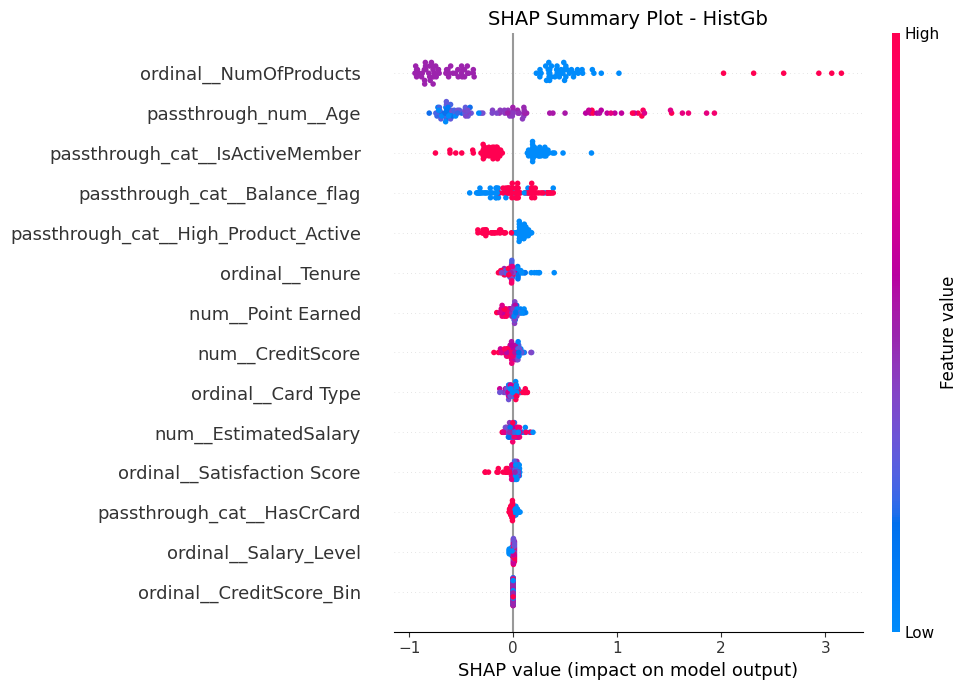

Executando SHAP para: NN_MLP
Quantidade de amostras: 100



  0%|          | 0/100 [00:00<?, ?it/s]

Gerando gráfico SHAP para NN_MLP


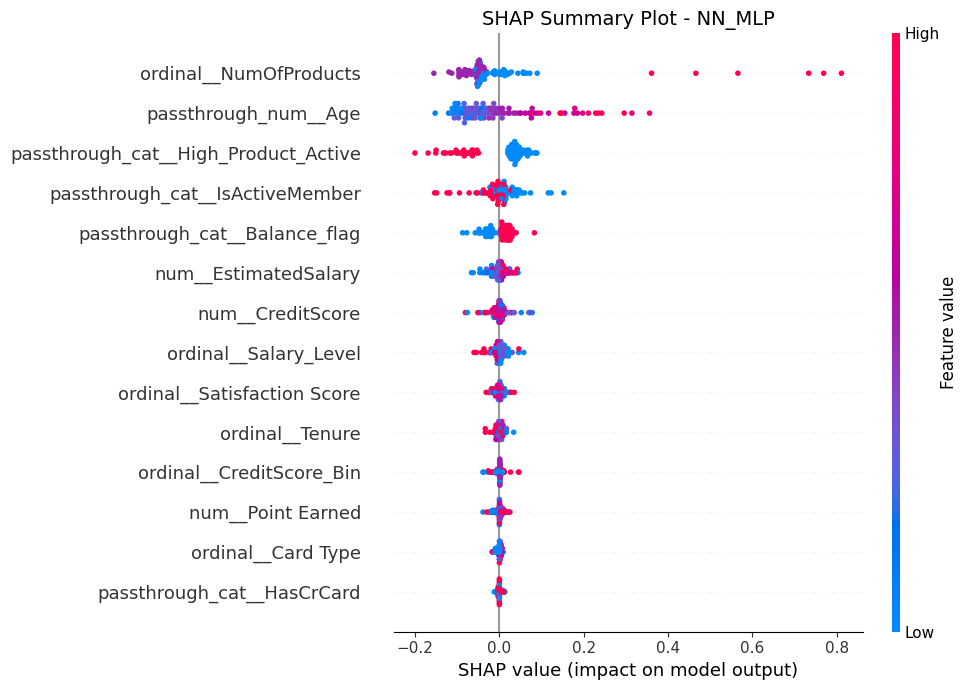

Executando SHAP para: XGBoost
Quantidade de amostras: 100

Modelo XGBoost calibrado — usando modelo base 'XGBClassifier' para SHAP.
Gerando gráfico SHAP para XGBoost


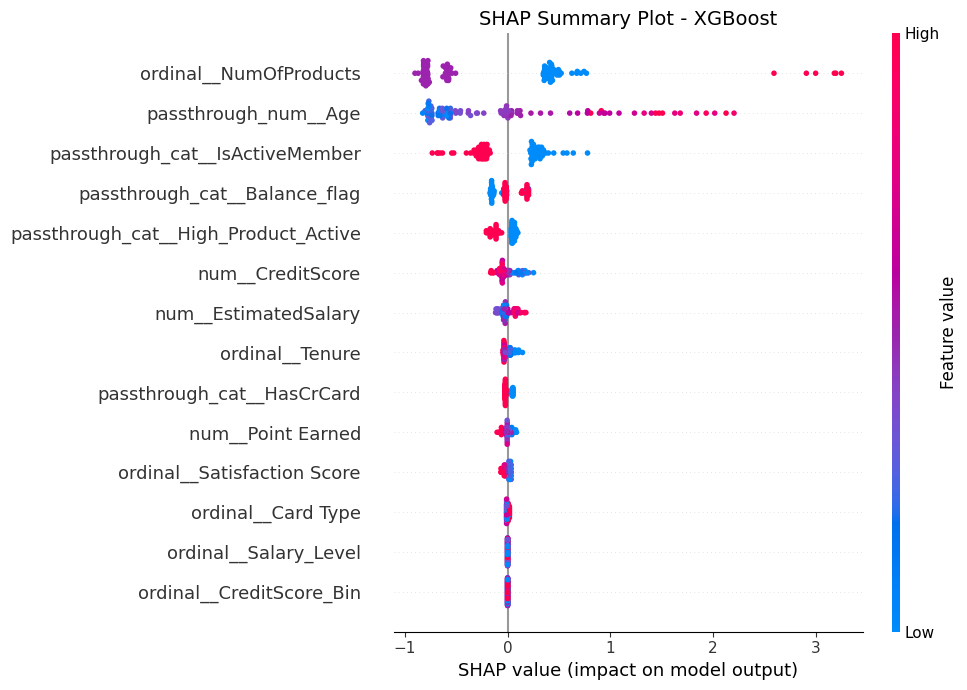

In [67]:
# Amostra estratificada para SHAP:
# Seleciona uma amostra estratificada de X_train e y_train 
# com tamanho definido por n_amostras_shap
X_train_for_shap, _, y_train_for_shap, _ = train_test_split(
    X_train, y_train,
    stratify=y_train,
    train_size=n_amostras_shap,
    random_state=42
)

# Calcula e plota os gráficos SHAP globais para os modelos treinados
calcular_shap_global_para_modelos("modelos_treinados", X_train_for_shap)


# 5. Avaliação: Avaliando Modelos (Métricas)    

In [68]:
def Avalia_modelos(resultados_modelos):
    """
    Avalia os modelos, calcula métricas globais (ROC AUC, AUC PR, Brier Score, Log Loss, ECE)
    e gera gráficos comparativos de performance, calibração e distribuição das probabilidades previstas.

    Parâmetros:
    - resultados_modelos: dict
        Dicionário onde cada chave é o nome do modelo e o valor é outro dict contendo:
            - "y_test_true": array-like, rótulos verdadeiros do teste
            - "y_test_proba": array-like, probabilidades previstas no teste
            - "y_train_true": array-like, rótulos verdadeiros do treino
            - "y_train_proba": array-like, probabilidades previstas no treino

    Retorno:
    - metricas_dict: dict
        Dicionário com métricas globais para cada modelo.
    """

    metricas_dict = {}
    nomes_modelos = list(resultados_modelos.keys())
    cmap = cm.get_cmap("viridis")
    cores_viridis = [cmap(x) for x in np.linspace(0.1, 0.9, len(nomes_modelos))]
    cores_dict = dict(zip(nomes_modelos, cores_viridis))

    # Calcula métricas globais para cada modelo
    for nome_modelo, dados in resultados_modelos.items():
        y_true = dados["y_test_true"]
        y_proba = dados["y_test_proba"]

        auc_roc = roc_auc_score(y_true, y_proba)
        auc_pr = average_precision_score(y_true, y_proba)
        brier = brier_score_loss(y_true, y_proba)
        logloss = log_loss(y_true, y_proba)
        ece = compute_ece(y_true, y_proba)

        metricas_dict[nome_modelo] = {
            "ROC AUC": auc_roc,
            "AUC PR": auc_pr,
            "Brier Score": brier,
            "Log Loss": logloss,
            "ECE": ece
        }

    # ===== GRÁFICOS: BRIER, LOG LOSS e ECE =====
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    nomes = list(metricas_dict.keys())
    cores = [cores_dict[n] for n in nomes]

    # --- Brier Score ---
    brier_scores = [metricas_dict[n]["Brier Score"] for n in nomes]
    barras1 = axes[0].bar(nomes, brier_scores, color=cores)
    axes[0].set_title("Brier Score por Modelo")
    axes[0].set_ylabel("Brier Score (quanto menor melhor)")
    axes[0].set_ylim(0, 1)
    for barra in barras1:
        altura = barra.get_height()
        axes[0].text(barra.get_x() + barra.get_width()/2, altura + 0.005, f"{altura:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # --- Log Loss ---
    log_losses = [metricas_dict[n]["Log Loss"] for n in nomes]
    barras2 = axes[1].bar(nomes, log_losses, color=cores)
    axes[1].set_title("Log Loss por Modelo")
    axes[1].set_ylabel("Logloss (quanto menor melhor)")
    axes[1].set_ylim(0, 1)
    for barra in barras2:
        altura = barra.get_height()
        axes[1].text(barra.get_x() + barra.get_width()/2, altura + 0.005, f"{altura:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # --- Expected Calibration Error (ECE) ---
    ece_scores = [metricas_dict[n]["ECE"] for n in nomes]
    barras3 = axes[2].bar(nomes, ece_scores, color=cores)
    axes[2].set_title("Expected Calibration Error (ECE)")
    axes[2].set_ylabel("ECE (quanto menor melhor)")
    axes[2].set_ylim(0, 1)
    for barra in barras3:
        altura = barra.get_height()
        axes[2].text(barra.get_x() + barra.get_width()/2, altura + 0.005, f"{altura:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ===== KDEs + Curva de Calibração =====
    fig, axes = plt.subplots(1, 3, figsize=(21, 6)) 

    # Gráfico KDE para Classe 0: distribuição das probabilidades previstas para a classe negativa
    for nome_modelo, dados in resultados_modelos.items():
        proba_negativo = dados["y_test_proba"][dados["y_test_true"] == 0]
        sns.kdeplot(
            proba_negativo,
            label=nome_modelo,
            linestyle="--",
            fill=True,
            color=cores_dict[nome_modelo],
            alpha=0,
            bw_adjust=1.2,
            ax=axes[0]
        )
    axes[0].set_title("Classe 0 - Distribuição de Probabilidades")
    axes[0].set_xlabel("Probabilidade Prevista")
    axes[0].set_ylabel("Densidade")
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xlim(0, 1)

    # Gráfico KDE para Classe 1: distribuição das probabilidades previstas para a classe positiva
    for nome_modelo, dados in resultados_modelos.items():
        proba_positivo = dados["y_test_proba"][dados["y_test_true"] == 1]
        sns.kdeplot(
            proba_positivo,
            label=nome_modelo,
            fill=True,
            color=cores_dict[nome_modelo],
            alpha=0,
            bw_adjust=1.2,
            ax=axes[1]
        )
    axes[1].set_title("Classe 1 - Distribuição de Probabilidades")
    axes[1].set_xlabel("Probabilidade Prevista")
    axes[1].set_ylabel("Densidade")
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlim(0, 1)

    # Curva de calibração: compara probabilidades previstas com frequência observada da classe positiva
    for nome_modelo, dados in resultados_modelos.items():
        prob_true, prob_pred = calibration_curve(dados["y_test_true"], dados["y_test_proba"], n_bins=10, strategy='uniform')
        axes[2].plot(prob_pred, prob_true, marker='o', label=nome_modelo, color=cores_dict[nome_modelo])
    axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
    axes[2].set_title("Curva de Calibração")
    axes[2].set_xlabel("Probabilidade Prevista")
    axes[2].set_ylabel("Frequência Observada (proporção real positiva)")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # ===== CURVAS DE PERFORMANCE =====
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Curva ROC: compara taxa de verdadeiros positivos vs. taxa de falsos positivos
    for nome_modelo, dados in resultados_modelos.items():
        # Teste ROC
        fpr_test, tpr_test, _ = roc_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_test = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        axes[0].plot(fpr_test, tpr_test, lw=2, label=f"{nome_modelo} Teste (AUC={auc_test:.2f})", color=cores_dict[nome_modelo])

        # Treino (linha tracejada)
        fpr_train, tpr_train, _ = roc_curve(dados["y_train_true"], dados["y_train_proba"])
        auc_train = roc_auc_score(dados["y_train_true"], dados["y_train_proba"])
        axes[0].plot(fpr_train, tpr_train, "--", lw=2, label=f"{nome_modelo} Treino (AUC={auc_train:.2f})", color=cores_dict[nome_modelo])

    axes[0].plot([0, 1], [0, 1], "k--", lw=1)
    axes[0].set_title("Curva ROC - Treino e Teste")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()
    axes[0].grid(True)

    # Curva Precision-Recall: relação entre precisão e recall para diferentes limiares
    for nome_modelo, dados in resultados_modelos.items():
        precision, recall, _ = precision_recall_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])
        axes[1].plot(recall, precision, lw=2, label=f"{nome_modelo} (AUC-PR={auc_pr:.2f})", color=cores_dict[nome_modelo])
    axes[1].set_title("Precision vs Recall")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()
    axes[1].grid(True)

    return metricas_dict

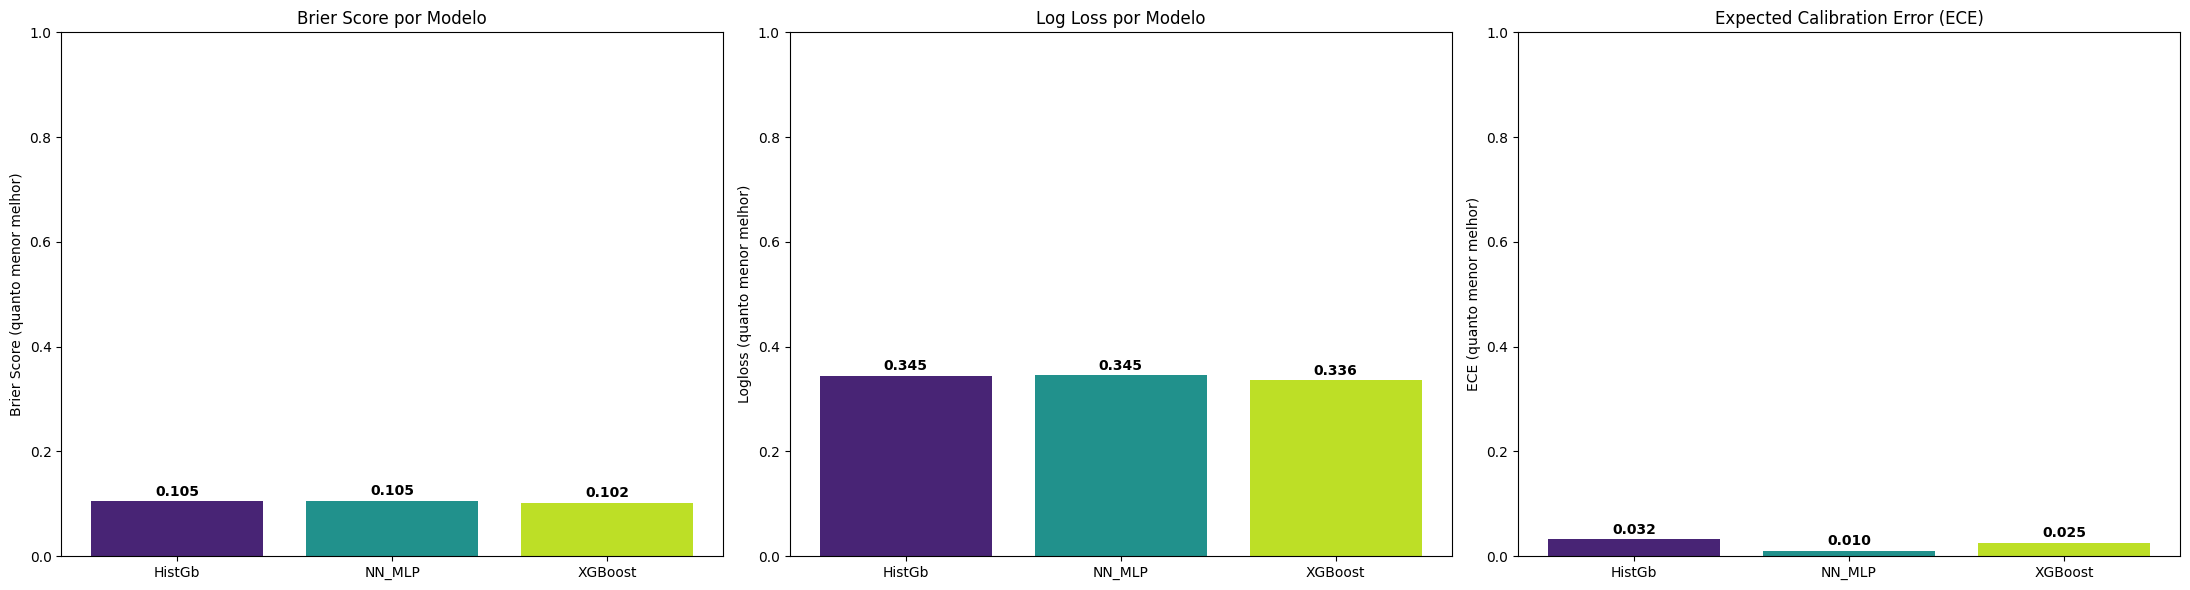

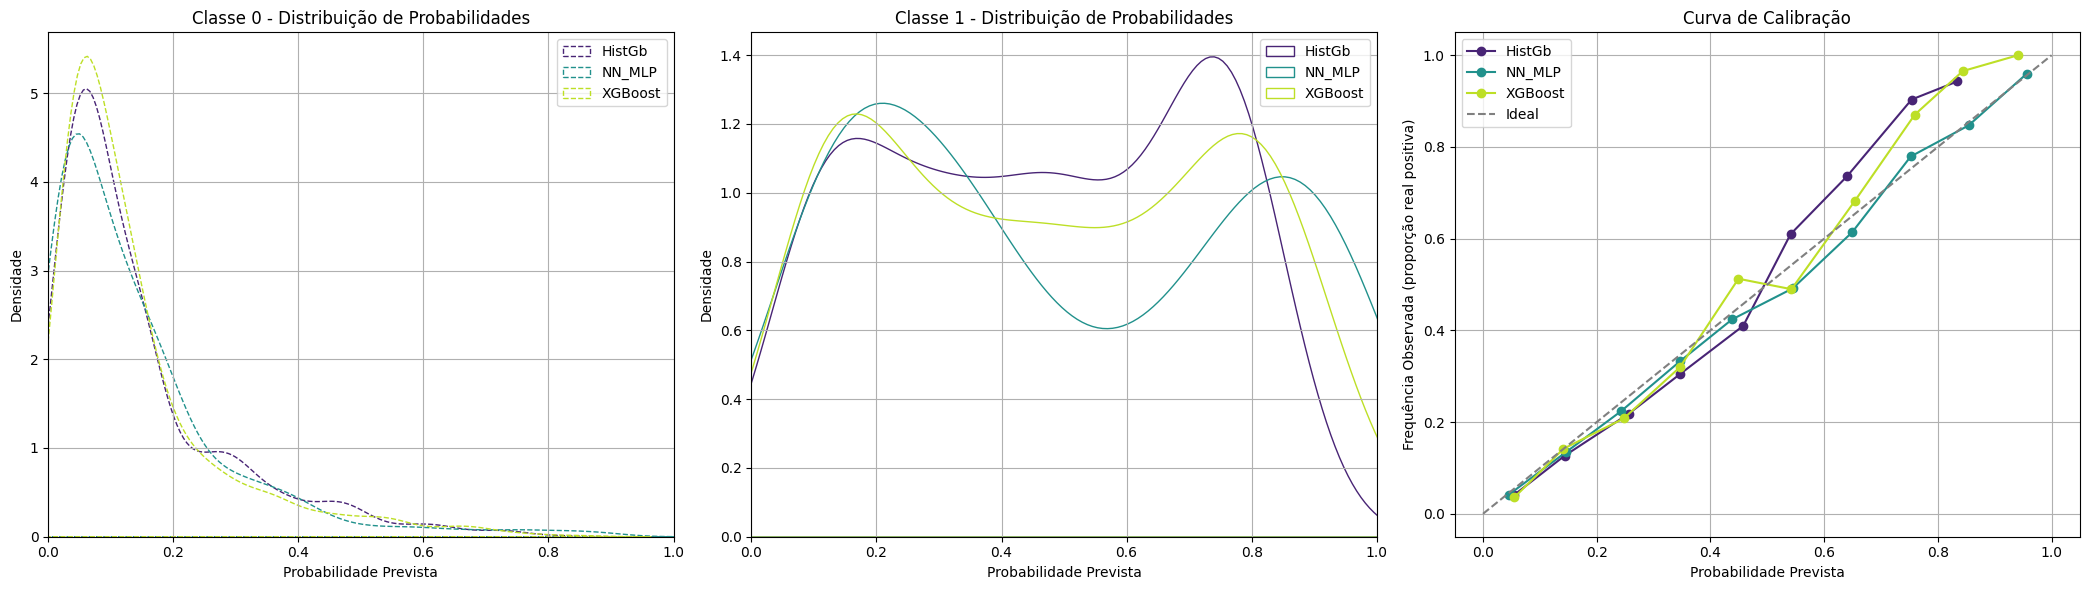

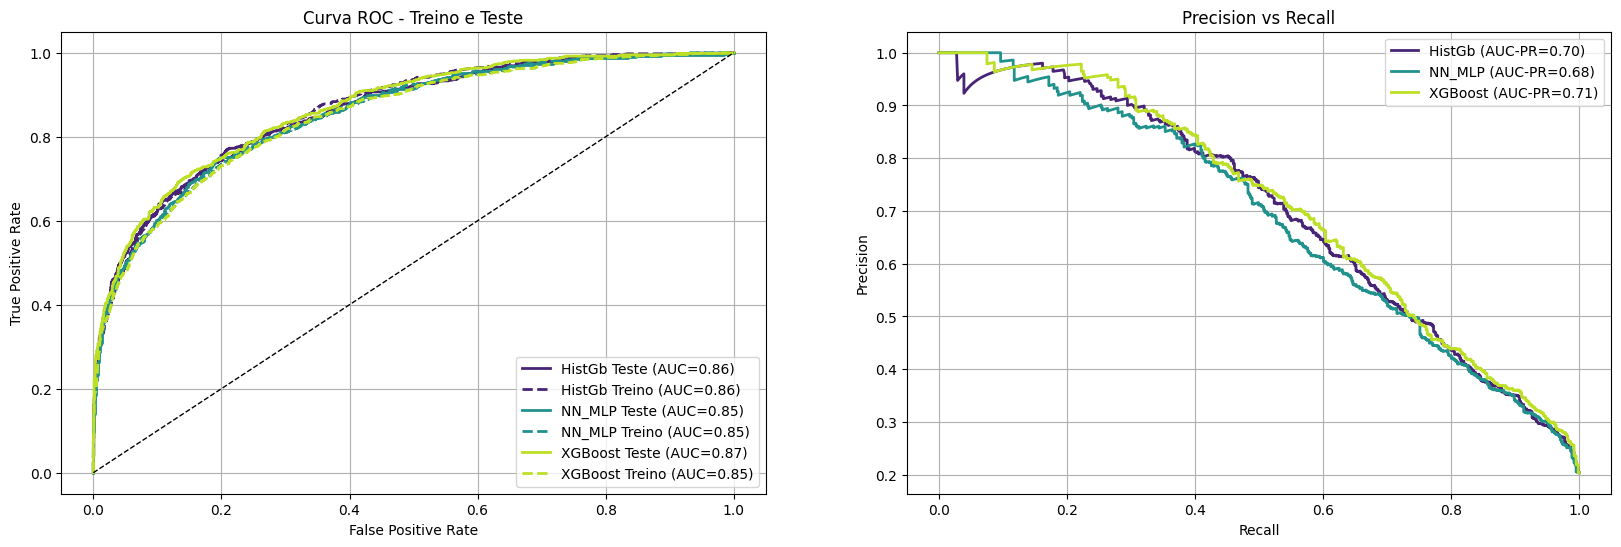

In [69]:
# Chama a função de avaliação para calcular métricas e gerar gráficos comparativos
metricas_finais = Avalia_modelos (resultados_finais)

* O **KDE mostra a distribuição das probabilidades** atribuídas pelo modelo para cada classe (positiva e negativa). Ele permite visualizar se o modelo consegue separar bem as classes, ou seja, se atribui probabilidades altas para a classe positiva e baixas para a negativa. Uma boa separação, com distribuições pouco sobrepostas, indica bom poder discriminativo.

* A **curva de calibração** verifica se as probabilidades previstas pelo modelo correspondem às frequências reais observadas dos eventos. Ela agrupa as previsões em faixas e compara a média das probabilidades previstas com a proporção de eventos ocorridos em cada faixa. Uma curva próxima da diagonal indica que o modelo está bem calibrado, ou seja, suas probabilidades refletem corretamente a chance real dos eventos.

* O **Expected Calibration Error (ECE)** avalia numericamente a calibração das previsões. Ele divide as probabilidades previstas em faixas (bins) e mede a diferença média ponderada entre a confiança prevista pelo modelo e a frequência real dos eventos em cada faixa. Um valor baixo de ECE indica boa calibração, ou seja, as probabilidades previstas refletem de forma precisa a frequência com que os eventos realmente ocorrem.

* O **Brier score** é uma métrica que quantifica a qualidade das previsões probabilísticas, considerando calibração e discriminação. Ele calcula o erro quadrático médio entre as probabilidades previstas e os resultados reais (0 ou 1). Quanto menor o Brier score, melhor a qualidade das previsões.

* O **Log loss (ou perda logarítmica)** mede a incerteza das previsões probabilísticas feitas pelo modelo. Ele penaliza mais severamente previsões com alta confiança quando estão erradas. Quanto menor o log loss, melhor o desempenho do modelo.

* A **curva ROC (Receiver Operating Characteristic)** avalia a capacidade do modelo de distinguir entre as classes, mostrando a taxa de verdadeiros positivos (TPR) em função da taxa de falsos positivos (FPR) para diferentes thresholds. O ROC AUC resume essa curva em um único valor, sendo 1 o ideal. É uma métrica clássica de discriminação, independente do threshold. Neste estudo, o foco está na propensão e não na classificação binária com um limiar fixo; ainda assim, é importante analisar a curva ROC para entender o poder discriminativo do modelo.

* A **curva Precision vs Recall** mostra o equilíbrio entre a precisão (quantos dos positivos previstos realmente são positivos) e a revocação (quantos dos positivos reais foram identificados) ao variar o threshold. Ela é especialmente útil em contextos com classes desbalanceadas, pois foca na qualidade da detecção da classe minoritária. Neste estudo, como o modelo é de propensão e não será utilizado um limiar fixo para classificação binária, a curva Precision vs Recall é relevante para avaliar o desempenho do modelo em diferentes faixas de probabilidade, sem depender de uma decisão binária.

Portanto, o KDE ajuda a visualizar a separação das classes (discriminação), a curva de calibração mostra o quão confiáveis são as probabilidades atribuídas (calibração), enquanto ECE e Brier score avaliam a calibração, e o log loss captura tanto aspectos de calibração quanto de discriminação. A ROC AUC resume a capacidade discriminativa global do modelo, e a curva Precision vs Recall destaca o desempenho em contextos desbalanceados. Usar essas análises em conjunto proporciona uma visão mais completa sobre o desempenho probabilístico dos modelos.

# 6. "Deploy" & Análise final: salvando o melhor modelo e checando resultados
* Aqui foram aplicados os critérios de seleção especificados no início do projeto.
* Modelo salvo neste passo, no próximo ele será carregado como se estivesse em outro ambiente, diretamente do arquivo .pkl (simulação controlada de produção).

In [70]:

def seleciona_melhor_modelo(metricas_finais, crit_brierscore=None, crit_aucroc=None, crit_logloss=None, crit_aucpr=None, crit_ece=None):
    """
    Seleciona o melhor modelo com base nas métricas e nos critérios definidos.

    As comparações de corte respeitam o sentido original das métricas:
    - Brier Score, Log Loss e ECE: quanto menor, melhor
    - AUC ROC e AUC PR: quanto maior, melhor

    Para fins de desempate, é calculada a média das métricas convertidas para a lógica "menor é melhor"
    (invertendo as métricas onde maior é melhor, como AUC ROC e AUC PR).

    Retorna o nome do melhor modelo ou None se nenhum atender aos critérios.
    """

    modelos_qualificados = {}
    for nome, m in metricas_finais.items():
        # Converte para float e arredonda as métricas
        brier = round(float(m['Brier Score']), 2)
        aucroc = round(float(m['ROC AUC']), 2)
        logloss = round(float(m['Log Loss']), 2)
        aucpr = round(float(m['AUC PR']), 2)
        ece = round(float(m['ECE']), 2)

        #Printa metricas
        print(f"\n🤖 Modelo: {nome}")
        print(f"   Brier:   {brier:.4f}")
        print(f"   AUC ROC: {aucroc:.4f}")
        print(f"   LogLoss: {logloss:.4f}")
        print(f"   AUC PR:  {aucpr:.4f}")
        print(f"   ECE:     {ece:.4f}")

        # Checagem dos critérios
        if (
            brier <= crit_brierscore and        # menor é melhor 
            logloss <= crit_logloss and         # menor é melhor 
            aucroc >= crit_aucroc and           # MAIOR é melhor 
            aucpr >= crit_aucpr and             # MAIOR é melhor 
            ece <= crit_ece                     # menor é melhor 
        ):
            print(f"🎯✅Modelo {nome} atende a todos os critérios definidos.")

            # Critério de desempate: calcula a média das métricas,
            # todas convertidas para a lógica "menor é melhor".
            # Quanto menor essa média, melhor o modelo.
            media_metricas = ((1 - aucroc) + brier + logloss + (1 - aucpr) + ece) / 5
            print(f"Modelo {nome} com média: {media_metricas:.5f} para critérios de desempate (quanto menor esta média, melhor o modelo).")
            modelos_qualificados[nome] = media_metricas

    if not modelos_qualificados:
        return None

    melhor_modelo = min(modelos_qualificados, key=modelos_qualificados.get)
    return melhor_modelo



def seleciona_e_salva_melhor_modelo(metricas_finais, pasta_base,crit_brierscore=None, crit_logloss=None, crit_aucroc=None,crit_aucpr=None, crit_ece=None):
    """
    Seleciona e salva o melhor modelo com base nos critérios definidos em seleciona_melhor_modelo().

    O modelo é escolhido conforme as métricas e critérios informados, validado quanto ao conteúdo do arquivo .pkl,
    e salvo em uma pasta chamada 'best_model', sobrescrevendo-a se já existir.

    Retorna None. Exibe mensagens informativas sobre o processo.
    """

    melhor_modelo = seleciona_melhor_modelo(metricas_finais,
                                   crit_brierscore=crit_brierscore,
                                   crit_logloss=crit_logloss,
                                   crit_aucroc=crit_aucroc,
                                   crit_aucpr=crit_aucpr,
                                   crit_ece=crit_ece)

    if melhor_modelo is None:
        print("⚠️ Nenhum modelo atendeu a todos os critérios definidos.")
        return

    print(f"\n🏆🤖 Modelo selecionado como melhor: {melhor_modelo}\n")

    # Caminho do arquivo do modelo selecionado
    origem = os.path.join(pasta_base, melhor_modelo, f"{melhor_modelo}_modelo_calibrado.pkl")

    if not os.path.exists(origem):
        print(f"❌ Arquivo não encontrado: {origem}")
        return

    # Validação do conteúdo do arquivo
    try:
        with open(origem, "rb") as f:
            objeto = joblib.load(f)
        if not isinstance(objeto, dict) or "pipeline" not in objeto:
            print("❌ O arquivo não contém 'pipeline'. Verifique o salvamento.")
            return
    except Exception as e:
        print(f"❌ Erro ao carregar o modelo: {e}")
        return

    # Criação da pasta de destino
    destino_pasta = os.path.join(pasta_base, "best_model")
    if os.path.exists(destino_pasta):
        shutil.rmtree(destino_pasta)
    os.makedirs(destino_pasta, exist_ok=True)

    # Copia o modelo para a pasta de destino
    destino = os.path.join(destino_pasta, "best_modelo_calibrado.pkl")
    shutil.copy(origem, destino)
    print(f"📁 Modelo copiado para: {destino}")

    # Salva as métricas do melhor modelo
    caminho_metricas = os.path.join(destino_pasta, "metricas.txt")
    with open(caminho_metricas, "w") as f:
        f.write(f"Metricas do melhor modelo: {melhor_modelo}\n\n")
        for metrica, valor in metricas_finais[melhor_modelo].items():
            f.write(f"{metrica}: {round(float(valor), 4)}\n")
    print(f"📝 Métricas salvas em: {caminho_metricas}")



In [71]:
# Definição dos critérios de corte e pasta base para salvar o melhor modelo

base_folder = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\modelos_treinados"

# Critérios de corte
crit_brierscore = 0.10 #quanto menor, melhor
crit_logloss = 0.35 #quanto menor, melhor
crit_ece = 0.03 #quanto menor, melhor
crit_aucroc = 0.85 #quanto maior, melhor
crit_aucpr = 0.70 #quanto maior, melhor

# Chama def que seleciona o melhor modelo e salva com base nos critérios de corte informados
seleciona_e_salva_melhor_modelo(
    metricas_finais,
    base_folder,
    crit_brierscore,
    crit_logloss,
    crit_aucroc,
    crit_aucpr,
    crit_ece
)



🤖 Modelo: HistGb
   Brier:   0.1000
   AUC ROC: 0.8600
   LogLoss: 0.3400
   AUC PR:  0.7000
   ECE:     0.0300
🎯✅Modelo HistGb atende a todos os critérios definidos.
Modelo HistGb com média: 0.18200 para critérios de desempate (quanto menor esta média, melhor o modelo).

🤖 Modelo: NN_MLP
   Brier:   0.1100
   AUC ROC: 0.8500
   LogLoss: 0.3500
   AUC PR:  0.6800
   ECE:     0.0100

🤖 Modelo: XGBoost
   Brier:   0.1000
   AUC ROC: 0.8700
   LogLoss: 0.3400
   AUC PR:  0.7100
   ECE:     0.0300
🎯✅Modelo XGBoost atende a todos os critérios definidos.
Modelo XGBoost com média: 0.17800 para critérios de desempate (quanto menor esta média, melhor o modelo).

🏆🤖 Modelo selecionado como melhor: XGBoost

📁 Modelo copiado para: C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\modelos_treinados\best_model\best_modelo_calibrado.pkl
📝 Métricas salvas em: C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\C

## 6.1 Aplicando modelo final e categorizando por Decis de probabilidade 

In [72]:
def aplicar_melhor_modelo(caminho_modelo, caminho_dados, caminho_nome_melhor_modelo, coluna_target="target"):
    """
    Aplica o melhor modelo salvo a um novo DataFrame, gera as probabilidades previstas, 
    adiciona coluna de decil (1 = maior risco), calcula métricas de performance e salva 
    os resultados e métricas em arquivos na pasta de output.

    Parâmetros:
        caminho_modelo (str): Caminho para o arquivo do modelo treinado (joblib).
        caminho_dados (str): Caminho para o arquivo CSV com os dados de entrada.
        caminho_nome_melhor_modelo (str): Caminho para o arquivo txt com o nome do melhor modelo.
        coluna_target (str): Nome da coluna alvo no DataFrame. Default: "target".

    Retorna:
        Salva arquivos de resultados e métricas na pasta de output (nao retorna nenhum objeto)
    """

    #carrega resultados obtidos antes, no treinamento,  para comparar com o resultado após aplicação em dados "novos" de produção
    try:
        with open(caminho_nome_melhor_modelo, "r") as f:
            Lista_metrica_modelo = f.read().strip()

        # Extrair apenas o nome do modelo (após "modelo:")
        if "modelo:" in Lista_metrica_modelo.lower():
            nome_modelo_puro = Lista_metrica_modelo.split("modelo:")[-1].strip().splitlines()[0]
        else:
            nome_modelo_puro = Lista_metrica_modelo.strip().splitlines()[0]  # fallback

        print(f"🏷️ Carregando melhor modelo treinado, após competicao e criterios de selecao: {nome_modelo_puro} \n (Trata-se das metricas salvas no treinamento, antes da aplicacao em prod) \n\n 📊{Lista_metrica_modelo}\n\n")

    except Exception as e:
        print(f"❌ Erro ao carregar o nome do melhor modelo: {e}")
        return

    # Carrega modelo treinado
    try:
        with open(caminho_modelo, "rb") as f:
            objeto = joblib.load(f)
        pipeline = objeto["pipeline"]
    except Exception as e:
        print(f"❌ Erro ao carregar o modelo: {e}")
        return

    # Carrega dados de entrada e cria variáveis derivadas
    try:
        df_original = pd.read_csv(caminho_dados)
        df_original = criar_variaveis_derivadas(df_original)  # variavies usadas para fairness 
    except Exception as e:
        print(f"❌ Erro ao carregar o CSV de entrada: {e}")
        return

    if coluna_target not in df_original.columns:
        print(f"❌ Coluna target '{coluna_target}' não encontrada no DataFrame.")
        return

    X = df_original.drop(columns=[coluna_target])
    y = df_original[coluna_target]

    # Aplica pipeline para gerar probabilidades
    print("")
    print("🏷️Aplicando Pipeline de Processamento, Modelo e Calibracao em prod:\n\n")

    try:
        probas = pipeline.predict_proba(X)[:, 1]
        # Identifica o nome da última etapa (modelo)
        ultimo_step_nome, ultimo_step_obj = pipeline.steps[-1]
        modelo_nome = ultimo_step_obj.__class__.__name__
        print("")
        print(f"🏷️ Modelo após Pipeline e calibração: '{modelo_nome}' (apesar do nome o modelo ainda é o {nome_modelo_puro})")
        print(f" step: '{ultimo_step_nome}'.\n\n\n\n ✅Pipeline aplicado com sucesso.\n\n")
    except Exception as e:
        print(f"❌ Erro ao aplicar o pipeline: {e}")
        return

    # Adiciona colunas 
    df_original["probabilidade"] = probas
    df_original["decil"] = pd.qcut(-df_original["probabilidade"], 10, labels=False) + 1

    # Calcula métricas
    brier = brier_score_loss(y, probas)
    logloss = log_loss(y, probas)
    rocauc = roc_auc_score(y, probas)
    aucpr = average_precision_score(y, probas)
    ece = compute_ece(y, probas, n_bins=10)  # usando sua função

    # printa métricas no console
    print("\n📊 Métricas na aplicação do modelo em prod:\n")
    print(f"ROC AUC: {rocauc:.4f}")
    print(f"AUC PR: {aucpr:.4f}")
    print(f"Brier Score: {brier:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"ECE: {ece:.4f}")

    # Caminho para salvar resultados
    pasta_output = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\output_final"
    os.makedirs(pasta_output, exist_ok=True)

    # Salva resultado com probabilidades e decil
    caminho_saida_csv = os.path.join(pasta_output, "resultado_com_probabilidades_e_decil.csv")
    df_original.to_csv(caminho_saida_csv, index=False)
    print(f"\n💾 Resultado salvo em: {caminho_saida_csv}")

    # Salva métricas em arquivo txt
    caminho_metricas_txt = os.path.join(pasta_output, "metricas_aplicacao.txt")
    with open(caminho_metricas_txt, "w") as f:
        f.write(f"Metricas da aplicacao do melhor modelo em Prod: {nome_modelo_puro} \n\n")
        f.write(f"ROC AUC: {rocauc:.4f}\n")
        f.write(f"AUC PR: {aucpr:.4f}\n")
        f.write(f"Brier Score: {brier:.4f}\n")
        f.write(f"Log Loss: {logloss:.4f}\n")
        f.write(f"ECE: {ece:.4f}\n")

    print(f"📝 Métricas salvas em: {caminho_metricas_txt}")


* modelo é aplicado a amostra completa; não sendo o ideal, foi o possível e mais próximo de novos dados. 

In [73]:
# Caminho para o arquivo do modelo calibrado 
caminho_modelo = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\modelos_treinados\best_model\best_modelo_calibrado.pkl"

# Caminho para o arquivo de métricas e nome do melhor modelo
caminho_nome_melhor_modelo = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\modelos_treinados\best_model\metricas.txt"

# Caminho para o CSV com os dados de entrada (amostra total para aplicação do modelo)
caminho_dados = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Customer-Churn-Records.csv"

# Aplica o melhor modelo, gera probabilidades, decil e salva resultados
aplicar_melhor_modelo(
    caminho_modelo,
    caminho_dados,
    caminho_nome_melhor_modelo,
    coluna_target="Exited"
)



🏷️ Carregando melhor modelo treinado, após competicao e criterios de selecao: XGBoost 
 (Trata-se das metricas salvas no treinamento, antes da aplicacao em prod) 

 📊Metricas do melhor modelo: XGBoost

ROC AUC: 0.8673
AUC PR: 0.7093
Brier Score: 0.1018
Log Loss: 0.3359
ECE: 0.0255



🏷️Aplicando Pipeline de Processamento, Modelo e Calibracao em prod:



🏷️ Modelo após Pipeline e calibração: 'CalibratedClassifierCV' (apesar do nome o modelo ainda é o XGBoost)
 step: 'calibrated_model'.



 ✅Pipeline aplicado com sucesso.



📊 Métricas na aplicação do modelo em prod:

ROC AUC: 0.8517
AUC PR: 0.6826
Brier Score: 0.1065
Log Loss: 0.3496
ECE: 0.0123

💾 Resultado salvo em: C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\output_final\resultado_com_probabilidades_e_decil.csv
📝 Métricas salvas em: C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\output_final\m

* Representação gráfica do objeto Pipeline final e a sequência de etapas aplicadas aos dados durante o processo de modelagem. Ele mostra como os dados são transformados e processados até chegar à etapa final de predição. Essa visualização facilita o entendimento do fluxo do modelo e da lógica aplicada em cada fase do pipeline do scikit-learn.

In [74]:
pipeline_dict = joblib.load(caminho_modelo)
pipeline = pipeline_dict['pipeline']
pipeline


Pipeline(steps=[('remover_colunas',
                 RemoveColunas(colunas_para_remover=['RowNumber', 'CustomerId',
                                                     'Surname', 'complain',
                                                     'Gender', 'Geography',
                                                     'Age_Grupo'])),
                ('feature_engineering', FeatureEngineeringTransformer()),
                ('remover_colunas_2',
                 RemoveColunas(colunas_para_remover=['Balance'])),
                ('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(ste...
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.07781745298818274,
                                                                max_bin=256,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=1.8299751236859747,
                                                                max_depth=3,
                                                                max_leaves=None,
                                                                min_child_weight=2,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=1200,
                                                                n_jobs=-1,
                                                                normalize_type=None,
                                                                num_parallel_tree=None, ...)))])

## 6.2 Explicabilidade: SHAP Global e Lime Local 

In [75]:
def calcular_shap_melhor_modelo(caminho_modelo, caminho_dados, n_amostras=100, target_col="Exited", random_state=42):
    """
    Calcula e exibe o gráfico SHAP global para o melhor modelo treinado, utilizando uma amostra estratificada dos dados.
    Realiza as etapas necessárias: leitura dos dados, criação de variáveis derivadas, transformação via pipeline,
    seleção do explainer SHAP adequado conforme o tipo de modelo, e geração do gráfico de importância das features.
    """

    print(f"Carregando dados de: {caminho_dados}")
    dados = pd.read_csv(caminho_dados)

    # variáveis derivadas
    dados = criar_variaveis_derivadas(dados)

    # Amostra estratificada 
    if target_col in dados.columns and n_amostras < len(dados):
        sss = StratifiedShuffleSplit(n_splits=1, train_size=n_amostras, random_state=random_state)
        for train_index, _ in sss.split(dados, dados[target_col]):
            dados_amostra = dados.iloc[train_index].reset_index(drop=True)
    else:
        dados_amostra = dados.copy()

    print(f"Amostra selecionada: {dados_amostra.shape[0]} linhas")

    #Separação das features (X)
    if target_col in dados_amostra.columns:
        X = dados_amostra.drop(columns=[target_col])
    else:
        X = dados_amostra.copy()

    #Carrega pipeline salvo
    pipeline_dict = joblib.load(caminho_modelo)
    pipeline = pipeline_dict['pipeline']

    #Extrai modelo final (calibrado ou não)
    modelo_final = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
    modelo_base = modelo_final.estimator if isinstance(modelo_final, CalibratedClassifierCV) else modelo_final

    #Pipeline sem o modelo (apenas pré-processamento)
    pipeline_sem_modelo = Pipeline(pipeline.steps[:-1])

    #Transforma dados com o pipeline (sem o modelo)
    X_transformado = pipeline_sem_modelo.transform(X)

    # Nomes das features após transformação
    try:
        preprocessor = pipeline.named_steps.get('preprocessamento', None)
        if preprocessor is not None:
            feature_names = preprocessor.get_feature_names_out()
        else:
            feature_names = None
    except Exception:
        feature_names = None

    #Valida número de features
    num_features = X_transformado.shape[1]
    if (feature_names is None) or (len(feature_names) != num_features):
        feature_names = [f"feature_{i}" for i in range(num_features)]

    # DataFrame com nomes das features
    X_transformado = pd.DataFrame(X_transformado, columns=feature_names)

    # Garante todos os dados como numéricos
    #X_transformado = X_transformado.apply(pd.to_numeric, errors='coerce')

    print(f"✅ Dados transformados — Shape: {X_transformado.shape}")

    # Seleciona explainer SHAP conforme o tipo de modelo
    nome_modelo = type(modelo_base).__name__.lower()

    if isinstance(modelo_base, MLPClassifier):
        print(f"Usando KernelExplainer para {nome_modelo}")
        explainer = shap.KernelExplainer(modelo_base.predict_proba, X_transformado)
        shap_values = explainer.shap_values(X_transformado)
        shap_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

    elif "histgradientboosting" in nome_modelo:
        print(f"Usando TreeExplainer para {nome_modelo}")
        explainer = shap.Explainer(modelo_base, X_transformado)
        shap_values = explainer(X_transformado, check_additivity=False) 
        shap_plot = shap_values

    elif "xgb" in nome_modelo or "xgboost" in nome_modelo:
        print(f"Usando TreeExplainer para {nome_modelo}")
        explainer = shap.Explainer(modelo_base, X_transformado)
        shap_values = explainer(X_transformado)
        shap_plot = shap_values

    else:
        print(f"Usando TreeExplainer para {nome_modelo}")
        explainer = shap.Explainer(modelo_base, X_transformado)
        shap_values = explainer(X_transformado)
        shap_plot = shap_values

    # Gráfico SHAP summary
    print(f"Gerando gráfico SHAP para o modelo {nome_modelo}")
    shap.summary_plot(shap_plot, X_transformado, show=False)

    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    plt.tight_layout()
    plt.show()


Carregando dados de: C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Customer-Churn-Records.csv
Amostra selecionada: 100 linhas
✅ Dados transformados — Shape: (100, 14)
Usando TreeExplainer para xgbclassifier
Gerando gráfico SHAP para o modelo xgbclassifier


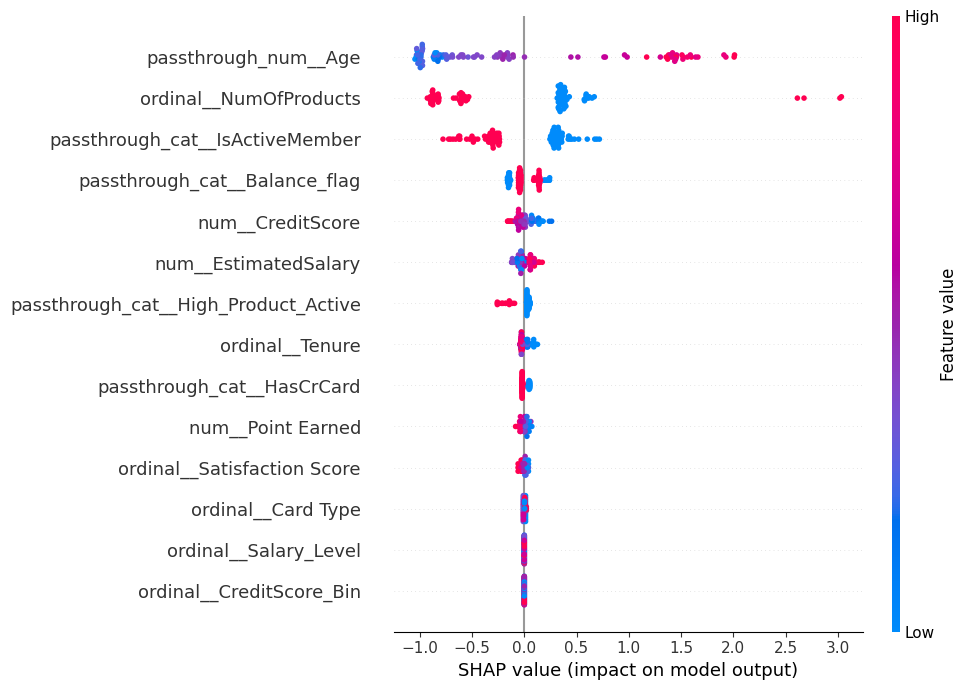

In [76]:
caminho_dados = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Customer-Churn-Records.csv"
caminho_modelo = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\modelos_treinados\best_model\best_modelo_calibrado.pkl"

calcular_shap_melhor_modelo(
    caminho_modelo=caminho_modelo,
    caminho_dados=caminho_dados,
    n_amostras=n_amostras_shap,
    target_col="Exited",
    random_state=42
)


In [77]:

def plotar_lime_linha_transformada(caminho_modelo, caminho_dados, indice_linha, target_col="Exited", random_state=42):
    """
    Gera e plota a explicação LIME para uma linha específica dos dados, utilizando o pipeline salvo.
    A função aplica todas as transformações do pipeline (exceto o modelo final), seleciona a linha transformada,
    e utiliza o LimeTabularExplainer para mostrar a contribuição de cada feature para a predição do modelo. 
    (explicabilidade local) 

    Parâmetros:
        caminho_modelo (str): Caminho para o arquivo do pipeline treinado (.pkl).
        caminho_dados (str): Caminho para o arquivo CSV com os dados originais.
        indice_linha (int): Índice da linha a ser explicada.
        target_col (str): Nome da coluna alvo (default: "Exited").
        random_state (int): Semente de aleatoriedade para reprodutibilidade.

    Saída:
        gráfico LIME para a linha selecionada.
    """

    # Carrega os dados originais e cria variáveis derivadas
    dados = pd.read_csv(caminho_dados)
    dados = criar_variaveis_derivadas(dados)
    if target_col in dados.columns:
        X = dados.drop(columns=[target_col])
    else:
        X = dados.copy()

    # Verifica se o índice solicitado existe
    if indice_linha not in X.index:
        raise IndexError(f"Índice {indice_linha} não está no dataset.")

    # Carrega o pipeline
    if not os.path.exists(caminho_modelo):
        raise FileNotFoundError(f"Modelo não encontrado em: {caminho_modelo}")
    pipeline_dict = joblib.load(caminho_modelo)
    pipeline = pipeline_dict['pipeline']

    # Aplica todas as transformações do pipeline (exceto o modelo final)
    X_transformado = pipeline[:-1].transform(X)

    # Recupera os nomes das features após o pré-processamento
    preprocessor = pipeline.named_steps['preprocessamento']
    feature_names = preprocessor.get_feature_names_out()

    # Instancia o LimeTabularExplainer usando os dados transformados
    explainer = LimeTabularExplainer(
        training_data=X_transformado,
        feature_names=feature_names,
        class_names=['Not Exited', 'Exited'],
        mode='classification',
        discretize_continuous=False,
        random_state=random_state
    )

    # Função preditora para o modelo final do pipeline
    modelo_final = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
    def pred_fn(dados_transformados):
        return modelo_final.predict_proba(dados_transformados)

    # Seleciona a linha transformada a ser explicada
    linha_transformada = X_transformado[indice_linha].reshape(1, -1)

    # Gera a explicação LIME para a linha selecionada
    exp = explainer.explain_instance(
        data_row=linha_transformada.flatten(),
        predict_fn=pred_fn,
        num_features=len(feature_names)
    )

    # Plota o LIME
    fig = exp.as_pyplot_figure()
    fig.set_size_inches(10, 7)
    plt.title(f"LIME Explanation para Observação de Número: {indice_linha} (dados transformados)")
    plt.show()




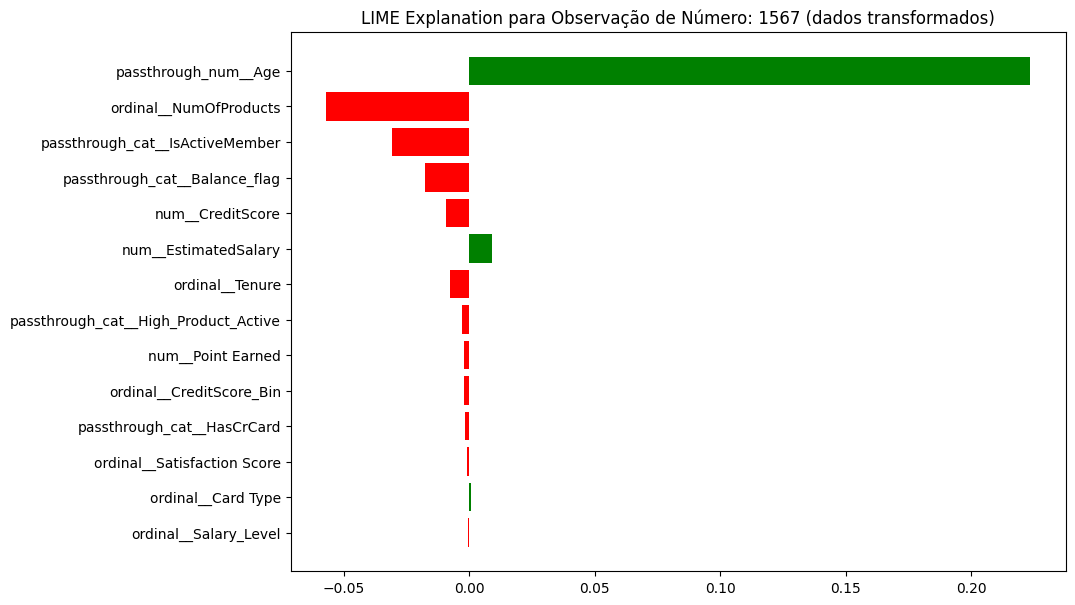

In [78]:
caminho_dados = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Customer-Churn-Records.csv"
caminho_modelo = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\modelos_treinados\best_model\best_modelo_calibrado.pkl"

# aplica LIME
plotar_lime_linha_transformada(caminho_modelo, caminho_dados, indice_linha=1567) # numero aleatorio de observacao 


## 6.3 Checando Resultados Finais 

In [79]:
df_final = pd.read_csv(r'C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Churn_predict_2.0_com_Pipeline_&_CRISP_DM\output_final\resultado_com_probabilidades_e_decil.csv')
df_final.head(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure   Balance  NumOfProducts  ...  IsActiveMember  EstimatedSalary  \
0       2      0.00              1  ...               1        101348.88   
1       1  83807.86              1  ...               1        112542.58   
2       8 159660.80              3  ...               0        113931.57   
3       1      0.00              2  ...               0         93826.63   
4       2 125510.82              1  ...               1         79084.10   
5       8 113755.78              2  ...               0        149756.71   
6       7      0.00              2  ...               1         10062.80   
7       4 115046.74              4  ...               0        119346.88   
8       4 142051.07              2  ...               1         74940.50   
9       2 134603.88              1  ...               1         71725.73   

   Exited  Complain  Satisfaction Score  Card Type Point Earned  Age_Grupo  \
0       1         1                   2    DIAMOND          464  Nao_Idoso   
1       0         1                   3    DIAMOND          456  Nao_Idoso   
2       1         1                   3    DIAMOND          377  Nao_Idoso   
3       0         0                   5       GOLD          350  Nao_Idoso   
4       0         0                   5       GOLD          425  Nao_Idoso   
5       1         1                   5    DIAMOND          484  Nao_Idoso   
6       0         0                   2     SILVER          206  Nao_Idoso   
7       1         1                   2    DIAMOND          282  Nao_Idoso   
8       0         0                   3       GOLD          251  Nao_Idoso   
9       0         0                   3       GOLD          342  Nao_Idoso   

  probabilidade  decil  
0          0.34      2  
1          0.19      4  
2          0.88      1  
3          0.08      7  
4          0.23      3  
5          0.23      3  
6          0.11      6  
7          0.78      1  
8          0.13      5  
9          0.08      7  

[10 rows x 21 columns]

* Entendendo o comportamento das probabilidades por decil:

In [80]:
resumo = df_final.groupby('decil')['probabilidade'].agg(
    min='min',
    max='max',
    média='mean',
    mediana='median',
    desvio_padrao='std',
    quantidade='count'  
).reset_index()

resumo


decil  min  max  média  mediana  desvio_padrao  quantidade
0      1 0.55 0.98   0.75     0.76           0.11        1000
1      2 0.32 0.55   0.42     0.41           0.07        1000
2      3 0.20 0.32   0.26     0.26           0.03        1000
3      4 0.15 0.20   0.17     0.17           0.02        1000
4      5 0.12 0.15   0.13     0.13           0.01        1000
5      6 0.09 0.12   0.11     0.11           0.01        1000
6      7 0.07 0.09   0.08     0.08           0.01        1000
7      8 0.05 0.07   0.06     0.06           0.01        1000
8      9 0.03 0.05   0.04     0.04           0.00        1000
9     10 0.02 0.03   0.03     0.03           0.00        1000

- As distribuições das probabilidades dentro de cada decil apresentam média e mediana muito próximas, o que indica simetria nos grupos.

- Os baixos desvios padrão sugerem que as probabilidades são pouco dispersas e consistentes dentro de cada faixa.

- Esse padrão de distribuição bem comportado entre os decis é um indício de boa calibração do modelo, contribuindo para uma maior confiabilidade nas probabilidades previstas.

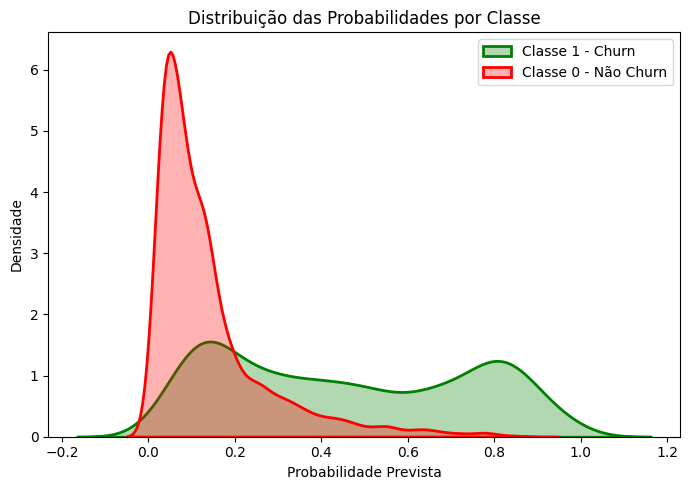

In [81]:
plt.figure(figsize=(7, 5))

# Distribuição das Probabilidades por Classe
sns.kdeplot(
    data=df_final[df_final["Exited"] == 1],
    x="probabilidade",
    label="Classe 1 - Churn",
    color="green",
    fill=True,
    alpha=0.3,
    linewidth=2
)
sns.kdeplot(
    data=df_final[df_final["Exited"] == 0],
    x="probabilidade",
    label="Classe 0 - Não Churn",
    color="red",
    fill=True,
    alpha=0.3,
    linewidth=2
)

plt.title("Distribuição das Probabilidades por Classe")
plt.xlabel("Probabilidade Prevista")
plt.ylabel("Densidade")
plt.legend()

plt.tight_layout()
plt.show()


* A sobreposição entre as probabilidades previstas das classes é esperada, especialmente em problemas com dados desbalanceados (como este). Como o modelo retorna propensões (probabilidades) para todos os registros, sem aplicar um corte, é natural que exista uma zona de incerteza com valores similares entre as classes. Isso não indica necessariamente um mau desempenho, mas sim as limitações naturais da separação probabilística quando há poucos exemplos da classe positiva.

## 6.4 Avaliação de Justiça (Fairness) e Detecção de Viés Algorítmico


In [82]:
def avaliar_justica_modelo_em_imagem(df, grupo_col, prob_col, decil_col, target_col, threshold=0.5):
    """
    Gera um relatório visual de fairness (justiça) do modelo para o grupo informado.
        Gráficos/textos:
            1. Tabela da média das probabilidades por grupo.
            2. Heatmap da distribuição dos décis por grupo.
            3. Histograma das probabilidades por grupo.
            4. Teste estatístico Kolmogorov-Smirnov entre grupos.
            5. Texto com AUC por grupo.
            6. Texto com Equalized Odds (TPR/FPR) por grupo.
            7. Texto com Disparate Impact Ratio (DIR) por grupo.
            8a. Gráfico DIR por decil.
            8b. Gráfico TPR Gap por decil.
            9. Espaço vazio para notas ou análises futuras.

    Parâmetros:
    - df: DataFrame de entrada.
    - grupo_col: Nome da coluna do grupo (ex: 'sexo', 'raca').
    - prob_col: Nome da coluna das probabilidades do modelo.
    - decil_col: Nome da coluna dos décis.
    - target_col: Nome da coluna do target (verdadeiro/real).
    - threshold: Limite para classificação binária (default=0.5).

    Retorna o objeto matplotlib Figure.
    """

    fig = plt.figure(figsize=(22, 22))
    gs = GridSpec(5, 2, figure=fig)

    grupos = df[grupo_col].unique()

    # 1. Tabela da média das probabilidades por grupo
    ax0 = fig.add_subplot(gs[0, 0])
    medias = df.groupby(grupo_col)[prob_col].mean().round(3)
    tabela = pd.DataFrame(medias).reset_index()
    ax0.axis('off')
    ax0.set_title("1️ - Média da probabilidade por grupo", fontsize=18)
    table = ax0.table(
        cellText=tabela.values,
        colLabels=tabela.columns,
        loc='center',
        cellLoc='center',
    )
    table.scale(0.9, 1.3)
    for key, cell in table.get_celld().items():
        cell.set_fontsize(16)
        cell.set_height(0.1)

    # 2. Heatmap da distribuição dos décis por grupo
    ax1 = fig.add_subplot(gs[0, 1])
    decil_dist = pd.crosstab(df[grupo_col], df[decil_col], normalize='index')
    sns.heatmap(decil_dist, annot=True, fmt=".2f", cmap="Blues", ax=ax1)
    ax1.set_title("2️ - Distribuição dos décis por grupo", fontsize=18)
    ax1.set_ylabel("", fontsize=12)
    ax1.set_xlabel("Decis", fontsize=12)

    # 3. Histograma das probabilidades por grupo
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(data=df, x=prob_col, hue=grupo_col, kde=True, stat='density',
                 common_norm=False, bins=20, ax=ax2)
    ax2.set_title("3️ - Distribuição da Probabilidade por Grupo", fontsize=18)
    ax2.set_xlabel('Probabilidade', fontsize=12)
    ax2.set_ylabel('Densidade', fontsize=12)

    # 4. Teste estatístico Kolmogorov-Smirnov entre grupos
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    texto_ks = "Kolmogorov-Smirnov entre grupos:\n\n"
    for i in range(len(grupos)):
        for j in range(i+1, len(grupos)):
            g1, g2 = grupos[i], grupos[j]
            stat, p = ks_2samp(df[df[grupo_col] == g1][prob_col],
                               df[df[grupo_col] == g2][prob_col])
            status = "✅ Sem diferença (p > 0.05)" if p > 0.05 else "⚠️ Diferença significativa (p ≤ 0.05)"
            texto_ks += f"{g1} vs {g2}: stat={stat:.2f}, p={p:.3f} → {status}\n"
    ax3.text(0, 0.5, texto_ks, fontsize=16, verticalalignment='center')
    ax3.set_title("4 - Teste estatistico (Kolmogorov-Smirnov)", fontsize=18)

    # 5. Texto com AUC por grupo
    ax4 = fig.add_subplot(gs[2, 0])
    auc_text = "AUC por grupo:\n\n"
    for grupo in grupos:
        grupo_df = df[df[grupo_col] == grupo]
        auc = roc_auc_score(grupo_df[target_col], grupo_df[prob_col])
        auc_text += f"{grupo}: AUC = {auc:.3f}\n"
    ax4.axis('off')
    ax4.text(0, 0.5, auc_text, fontsize=16, verticalalignment='center')
    ax4.set_title("5️ - AUC por grupo", fontsize=18)

    # 6. Texto com Equalized Odds (TPR/FPR) por grupo
    ax5 = fig.add_subplot(gs[2, 1])
    tpr = {}
    fpr = {}
    for grupo in grupos:
        grupo_df = df[df[grupo_col] == grupo]
        preds = (grupo_df[prob_col] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(grupo_df[target_col], preds).ravel()
        tpr[grupo] = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        fpr[grupo] = fp / (fp + tn) if (fp + tn) > 0 else np.nan

    tpr_diff = max(tpr.values()) - min(tpr.values())
    fpr_diff = max(fpr.values()) - min(fpr.values())

    eo_text = "Equalized Odds:\n\n"
    for grupo in grupos:
        eo_text += f"{grupo}: TPR = {tpr[grupo]:.3f}, FPR = {fpr[grupo]:.3f}\n"
    eo_text += f"\nDiferença TPR = {tpr_diff:.3f}, FPR = {fpr_diff:.3f}"

    ax5.axis('off')
    ax5.text(0, 0.5, eo_text, fontsize=16, verticalalignment='center')
    ax5.set_title("6 - Equalized Odds", fontsize=18)

    # 7. Texto com Disparate Impact Ratio (DIR) por grupo
    ax6 = fig.add_subplot(gs[3, 0])
    ax6.axis('off')
    limite_decil_dir = 4
    limite_inferior = 0.8
    limite_superior = 1.25
    taxas = {}
    dir_text = f"DIR por grupo (Decil ≤ {limite_decil_dir}):\n\n"
    for grupo in grupos:
        grupo_df = df[df[grupo_col] == grupo]
        selecionados = grupo_df[grupo_df[decil_col] <= limite_decil_dir]
        taxa = len(selecionados) / len(grupo_df) if len(grupo_df) > 0 else np.nan
        taxas[grupo] = taxa
        dir_text += f"{grupo}: {taxa:.3f}\n"
    from itertools import permutations
    for ref, comp in permutations(taxas.keys(), 2):
        taxa_ref = taxas[ref]
        taxa_comp = taxas[comp]
        if taxa_ref > 0:
            dir_valor = taxa_comp / taxa_ref
            status = ("✔️ Atende à Regra dos 80%" if (limite_inferior <= dir_valor <= limite_superior) 
                      else "❌ Viola a Regra dos 80%")
            dir_text += f"DIR ({comp} / {ref}): {dir_valor:.2f} → {status}\n"
        else:
            dir_text += f"DIR ({comp} / {ref}): Não calculável (taxa ref = 0)\n"
    ax6.set_title("7 - Disparate Impact Ratio (DIR) por grupo", fontsize=18, pad=5)
    ax6.text(0, 0.45, dir_text, fontsize=12, verticalalignment='center')

    # 8a. Gráfico DIR por decil
    ax7 = fig.add_subplot(gs[3, 1])
    resultados_dir = []
    for decil_corte in range(1, 11):
        df['Flag_Alto_Risco'] = df[decil_col] <= decil_corte
        taxas_por_grupo = df.groupby(grupo_col)['Flag_Alto_Risco'].mean()
        taxa_ref = taxas_por_grupo.min()
        dir_por_grupo = taxas_por_grupo / taxa_ref
        for grupo, dir_valor in dir_por_grupo.items():
            resultados_dir.append({'Decil_Corte': decil_corte, 'Grupo': grupo, 'DIR': dir_valor})
    df_dir = pd.DataFrame(resultados_dir)
    limite_inferior = 0.8
    limite_superior = 1.25
    sns.lineplot(data=df_dir, x='Decil_Corte', y='DIR', hue='Grupo', marker="o", ax=ax7)
    ax7.axhline(limite_superior, color='red', linestyle='--')
    ax7.axhline(limite_inferior, color='red', linestyle='--')
    ax7.set_title("8️ - Disparate Impact Ratio (DIR) por Decil", fontsize=18)
    ax7.set_ylabel("DIR", fontsize=12)
    ax7.set_xlabel("Decil ≤", fontsize=12)

    # 8b. Gráfico TPR Gap por decil
    ax8 = fig.add_subplot(gs[4, 0])
    resultados_tpr = []
    for decil_corte in range(1, 11):
        df['Flag_Alto_Risco'] = df[decil_col] <= decil_corte
        tpr_por_grupo = df[df[target_col] == 1].groupby(grupo_col)['Flag_Alto_Risco'].mean()
        tpr_gap = tpr_por_grupo.max() - tpr_por_grupo.min()
        resultados_tpr.append({'Decil_Corte': decil_corte, 'TPR_Gap': tpr_gap})
    df_tpr = pd.DataFrame(resultados_tpr)
    sns.lineplot(data=df_tpr, x='Decil_Corte', y='TPR_Gap', marker="o", ax=ax8, color='green')
    ax8.set_title("9️ - TPR Gap por Decil", fontsize=18)
    ax8.set_ylabel("TPR Gap", fontsize=12)
    ax8.set_xlabel("Decil ≤", fontsize=12)

    # 9. Espaço vazio para notas ou análises futuras
    ax9 = fig.add_subplot(gs[4, 1])
    ax9.axis('off')
    ax9.text(0.5, 0.5, "   ",
             fontsize=14, ha='center', va='center')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, wspace=0.15, hspace=0.5)
    fig.suptitle(
        f"Relatório de monitoramento de Fairness (Justiça) para a variável: {grupo_col}",
        fontsize=26,
        fontweight='bold',
        y=1.02
    )

    return fig


In [83]:
def executar_analise_justica(df, lista_variaveis, prob_col='probabilidade', decil_col='decil', target_col='Exited'):
    """
    Executa uma análise visual e estatística de justiça (fairness) do modelo para cada variável sensível informada.

    Para cada variável em `lista_variaveis`, gera os gráficos da função `avaliar_justica_modelo_em_imagem`.
    Se a variável for 'Age', cria uma coluna binária 'Grupo_Idoso' para separar idosos (65+) dos demais.

    Parâmetros:
        df (pd.DataFrame): DataFrame com os dados e probabilidades previstas.
        lista_variaveis (list): Lista de variáveis sensíveis para análise de justiça.
        prob_col (str): Nome da coluna de probabilidades previstas.
        decil_col (str): Nome da coluna de decil de risco.
        target_col (str): Nome da coluna alvo (verdadeiro/real).

    Saída: 
        Exibe os gráficos e resultados para cada variável sensível.
    """
    for var in lista_variaveis:
        print(f"\nAnálise de Justiça para: {var}")
        #cria coluna binária da idade para grupo de idosos se for a variável 'Age'
        if var == 'Age':
            df_temp = df.copy()
            df_temp['Grupo_Idoso'] = np.where(df_temp['Age'] >= 65, 'Idoso (65+)', 'Não Idoso') 
            grupo_col = 'Grupo_Idoso'
        else:
            df_temp = df
            grupo_col = var

        fig = avaliar_justica_modelo_em_imagem(df_temp,
                                               grupo_col=grupo_col,
                                               prob_col=prob_col,
                                               decil_col=decil_col,
                                               target_col=target_col)
        plt.show()



Análise de Justiça para: Geography


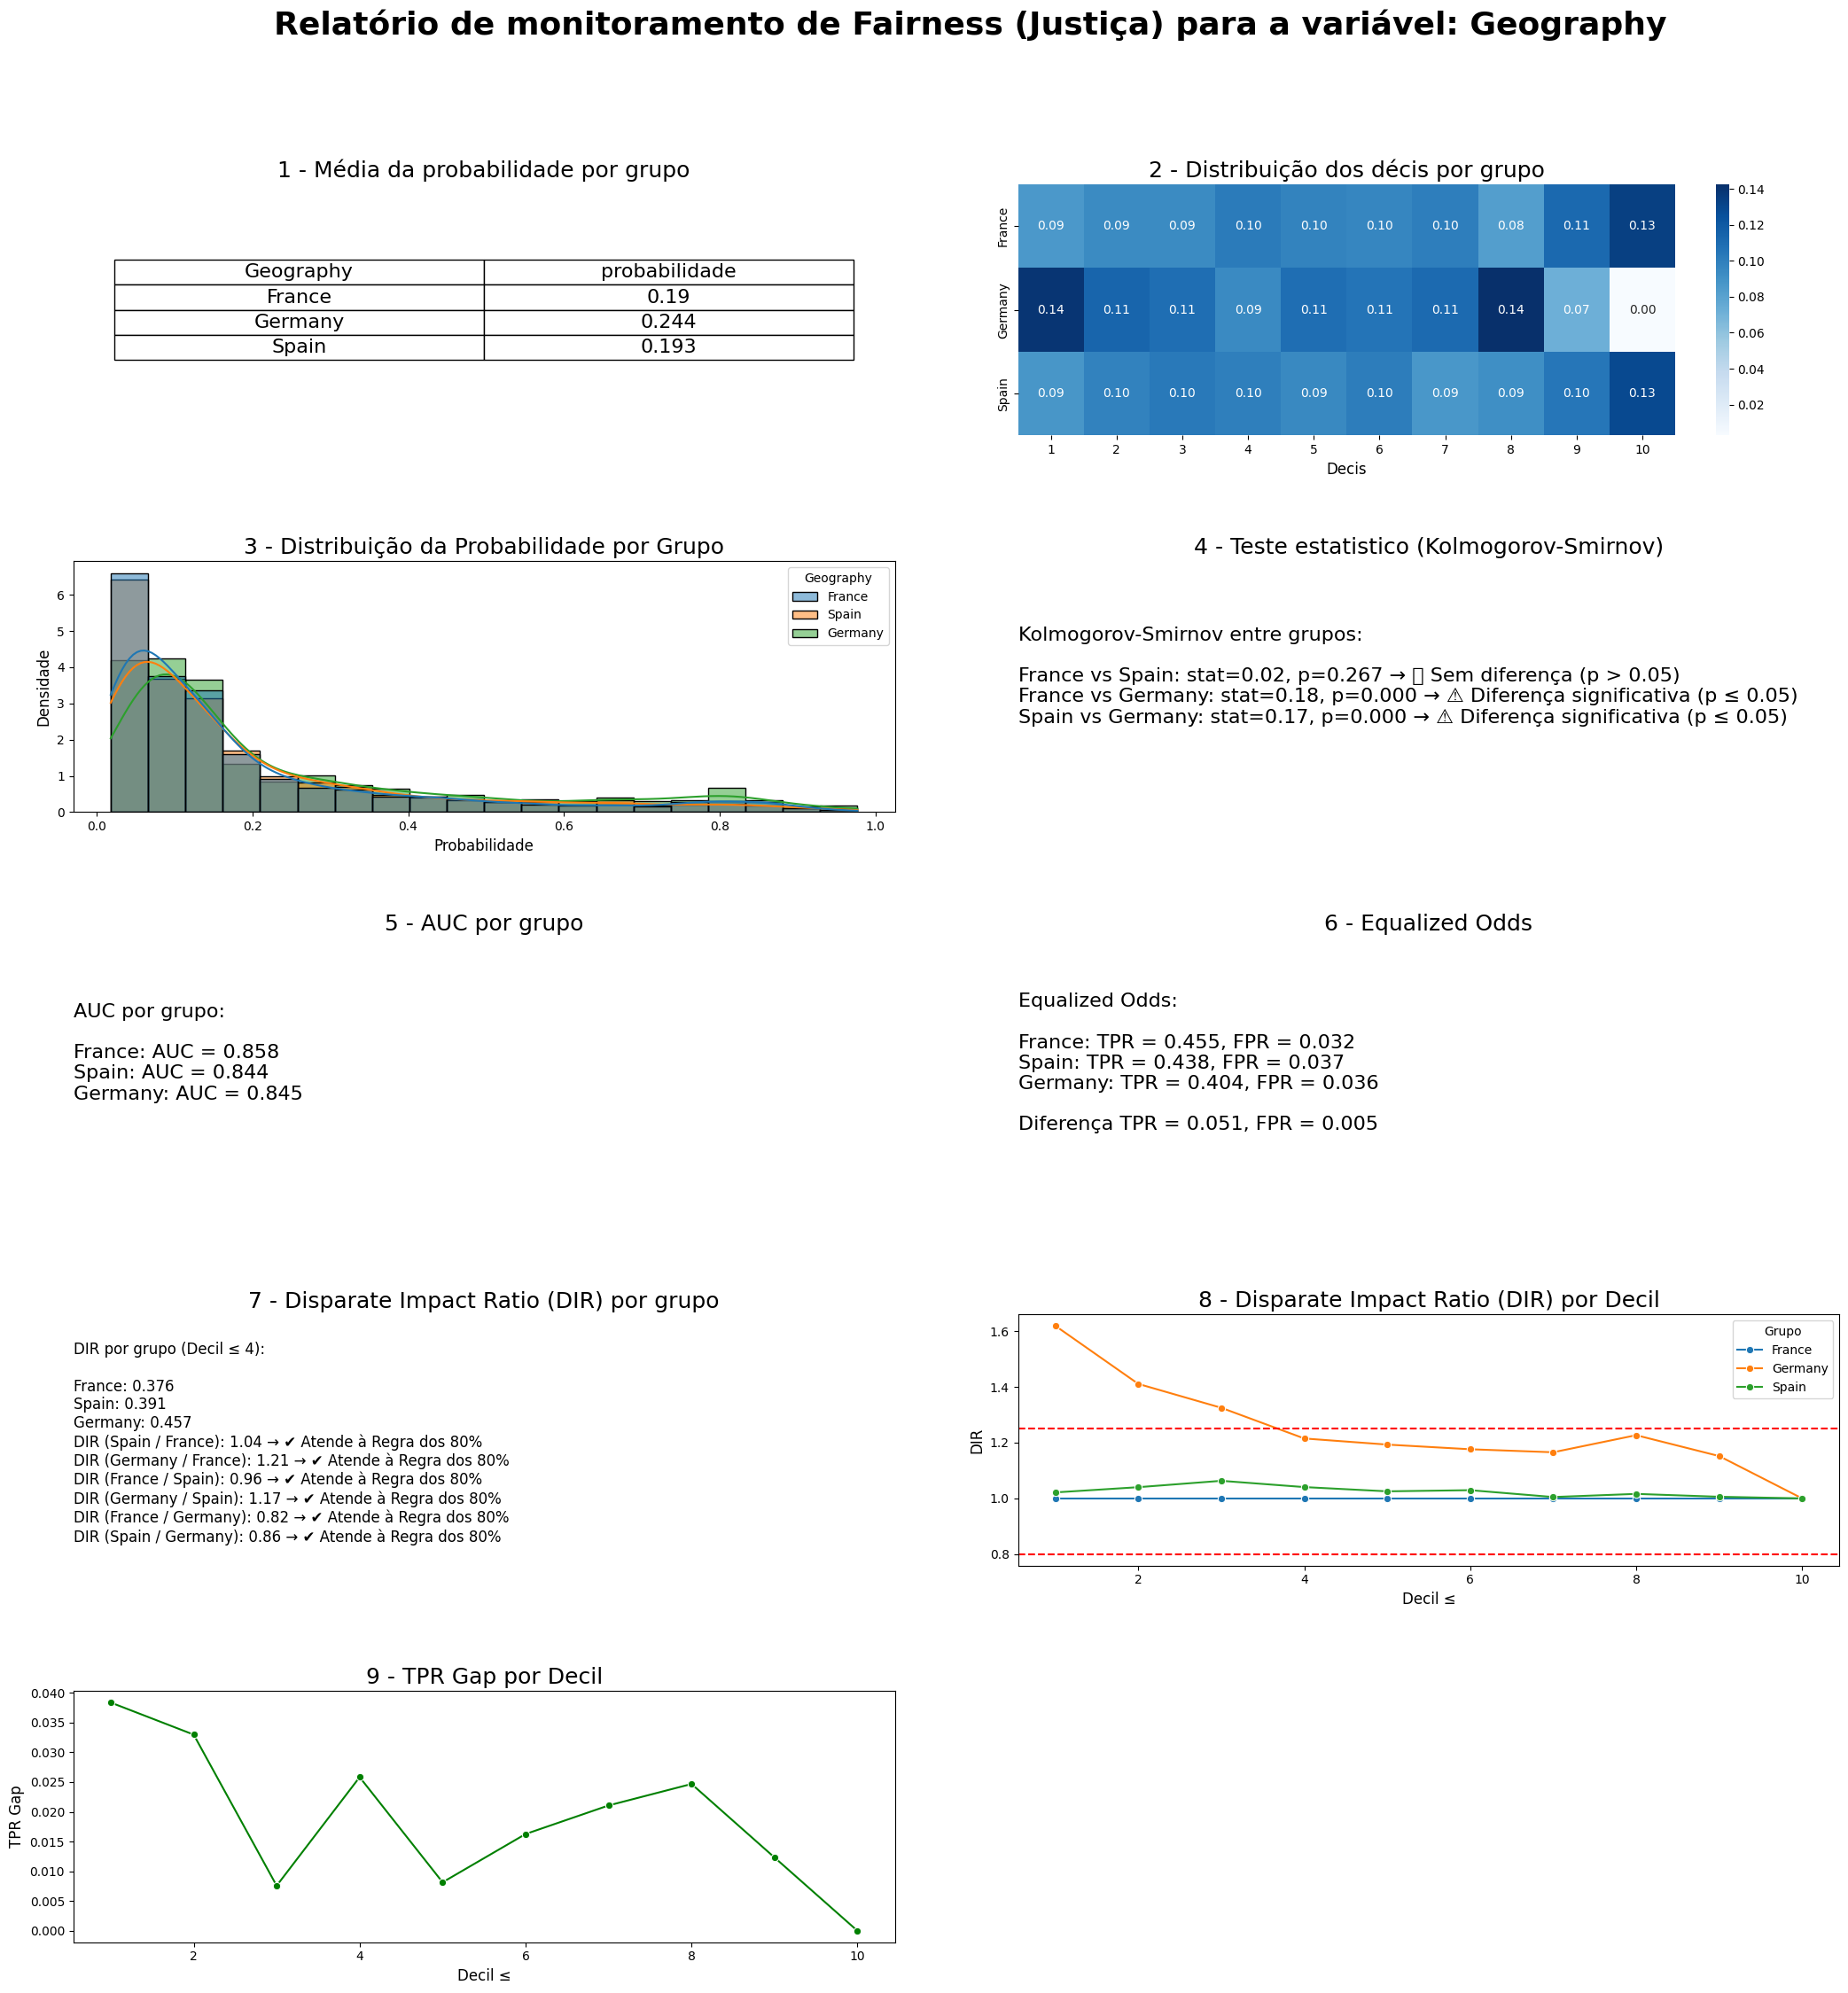


Análise de Justiça para: Gender


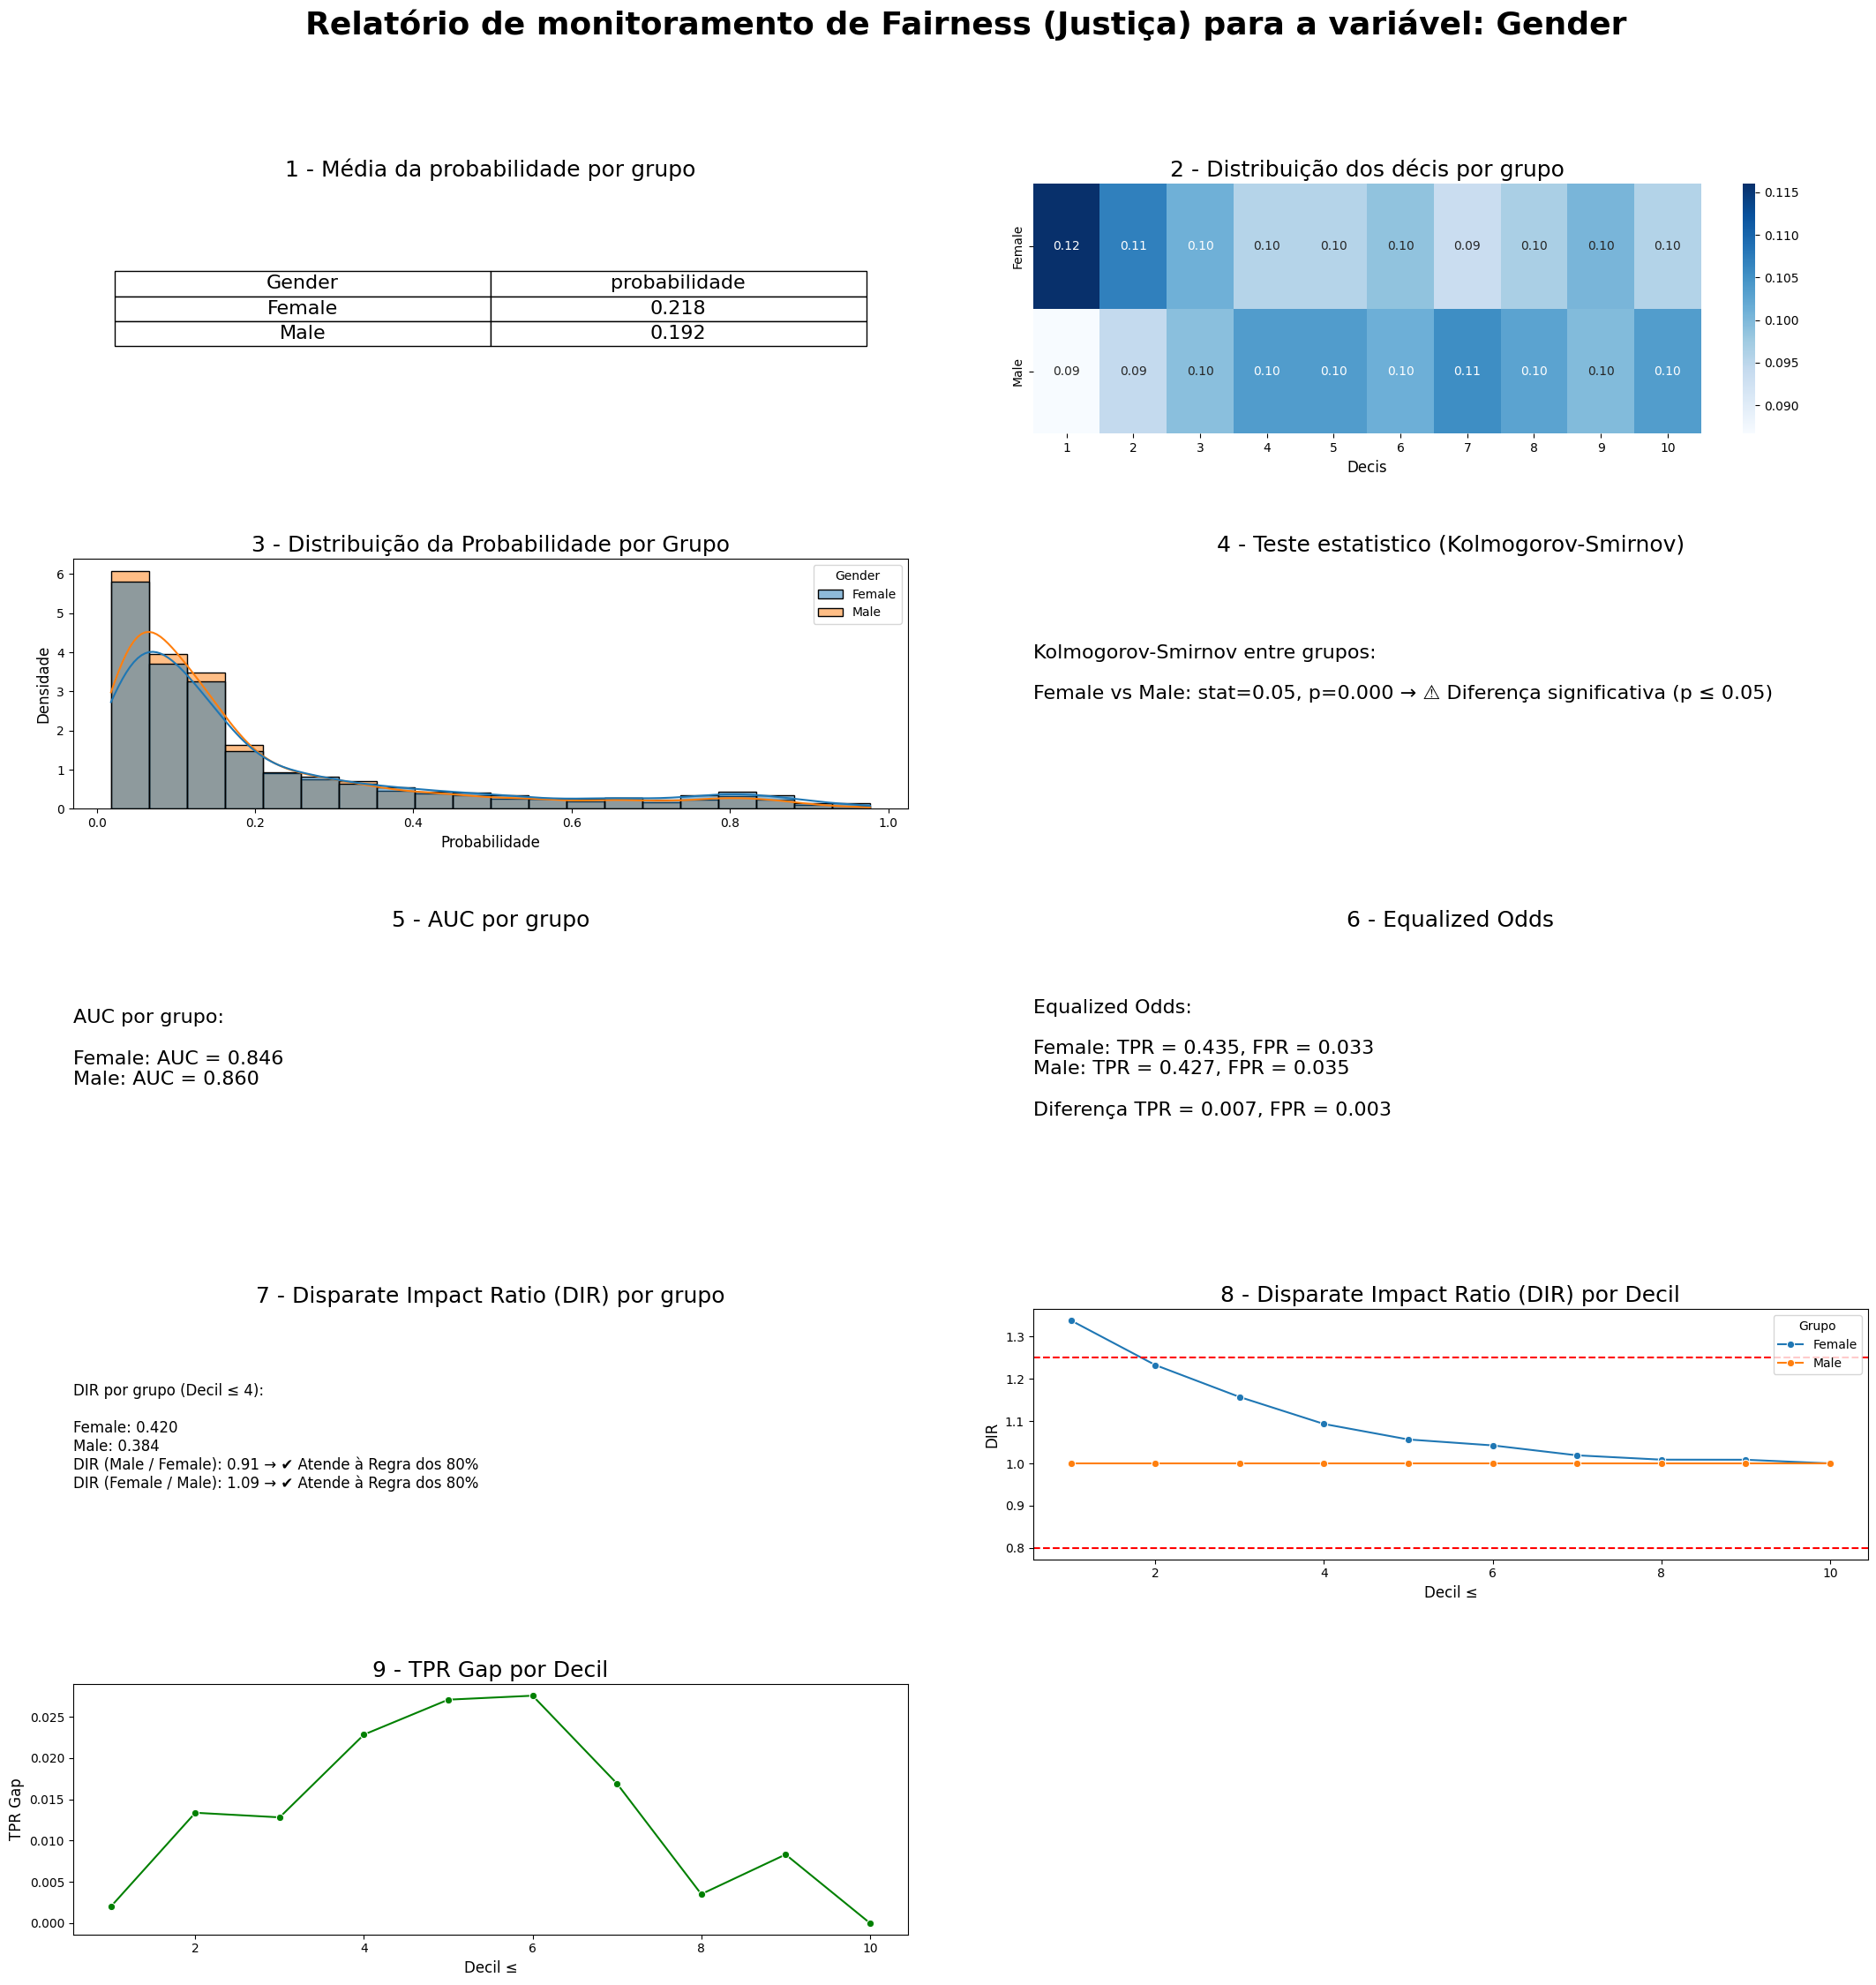


Análise de Justiça para: Age


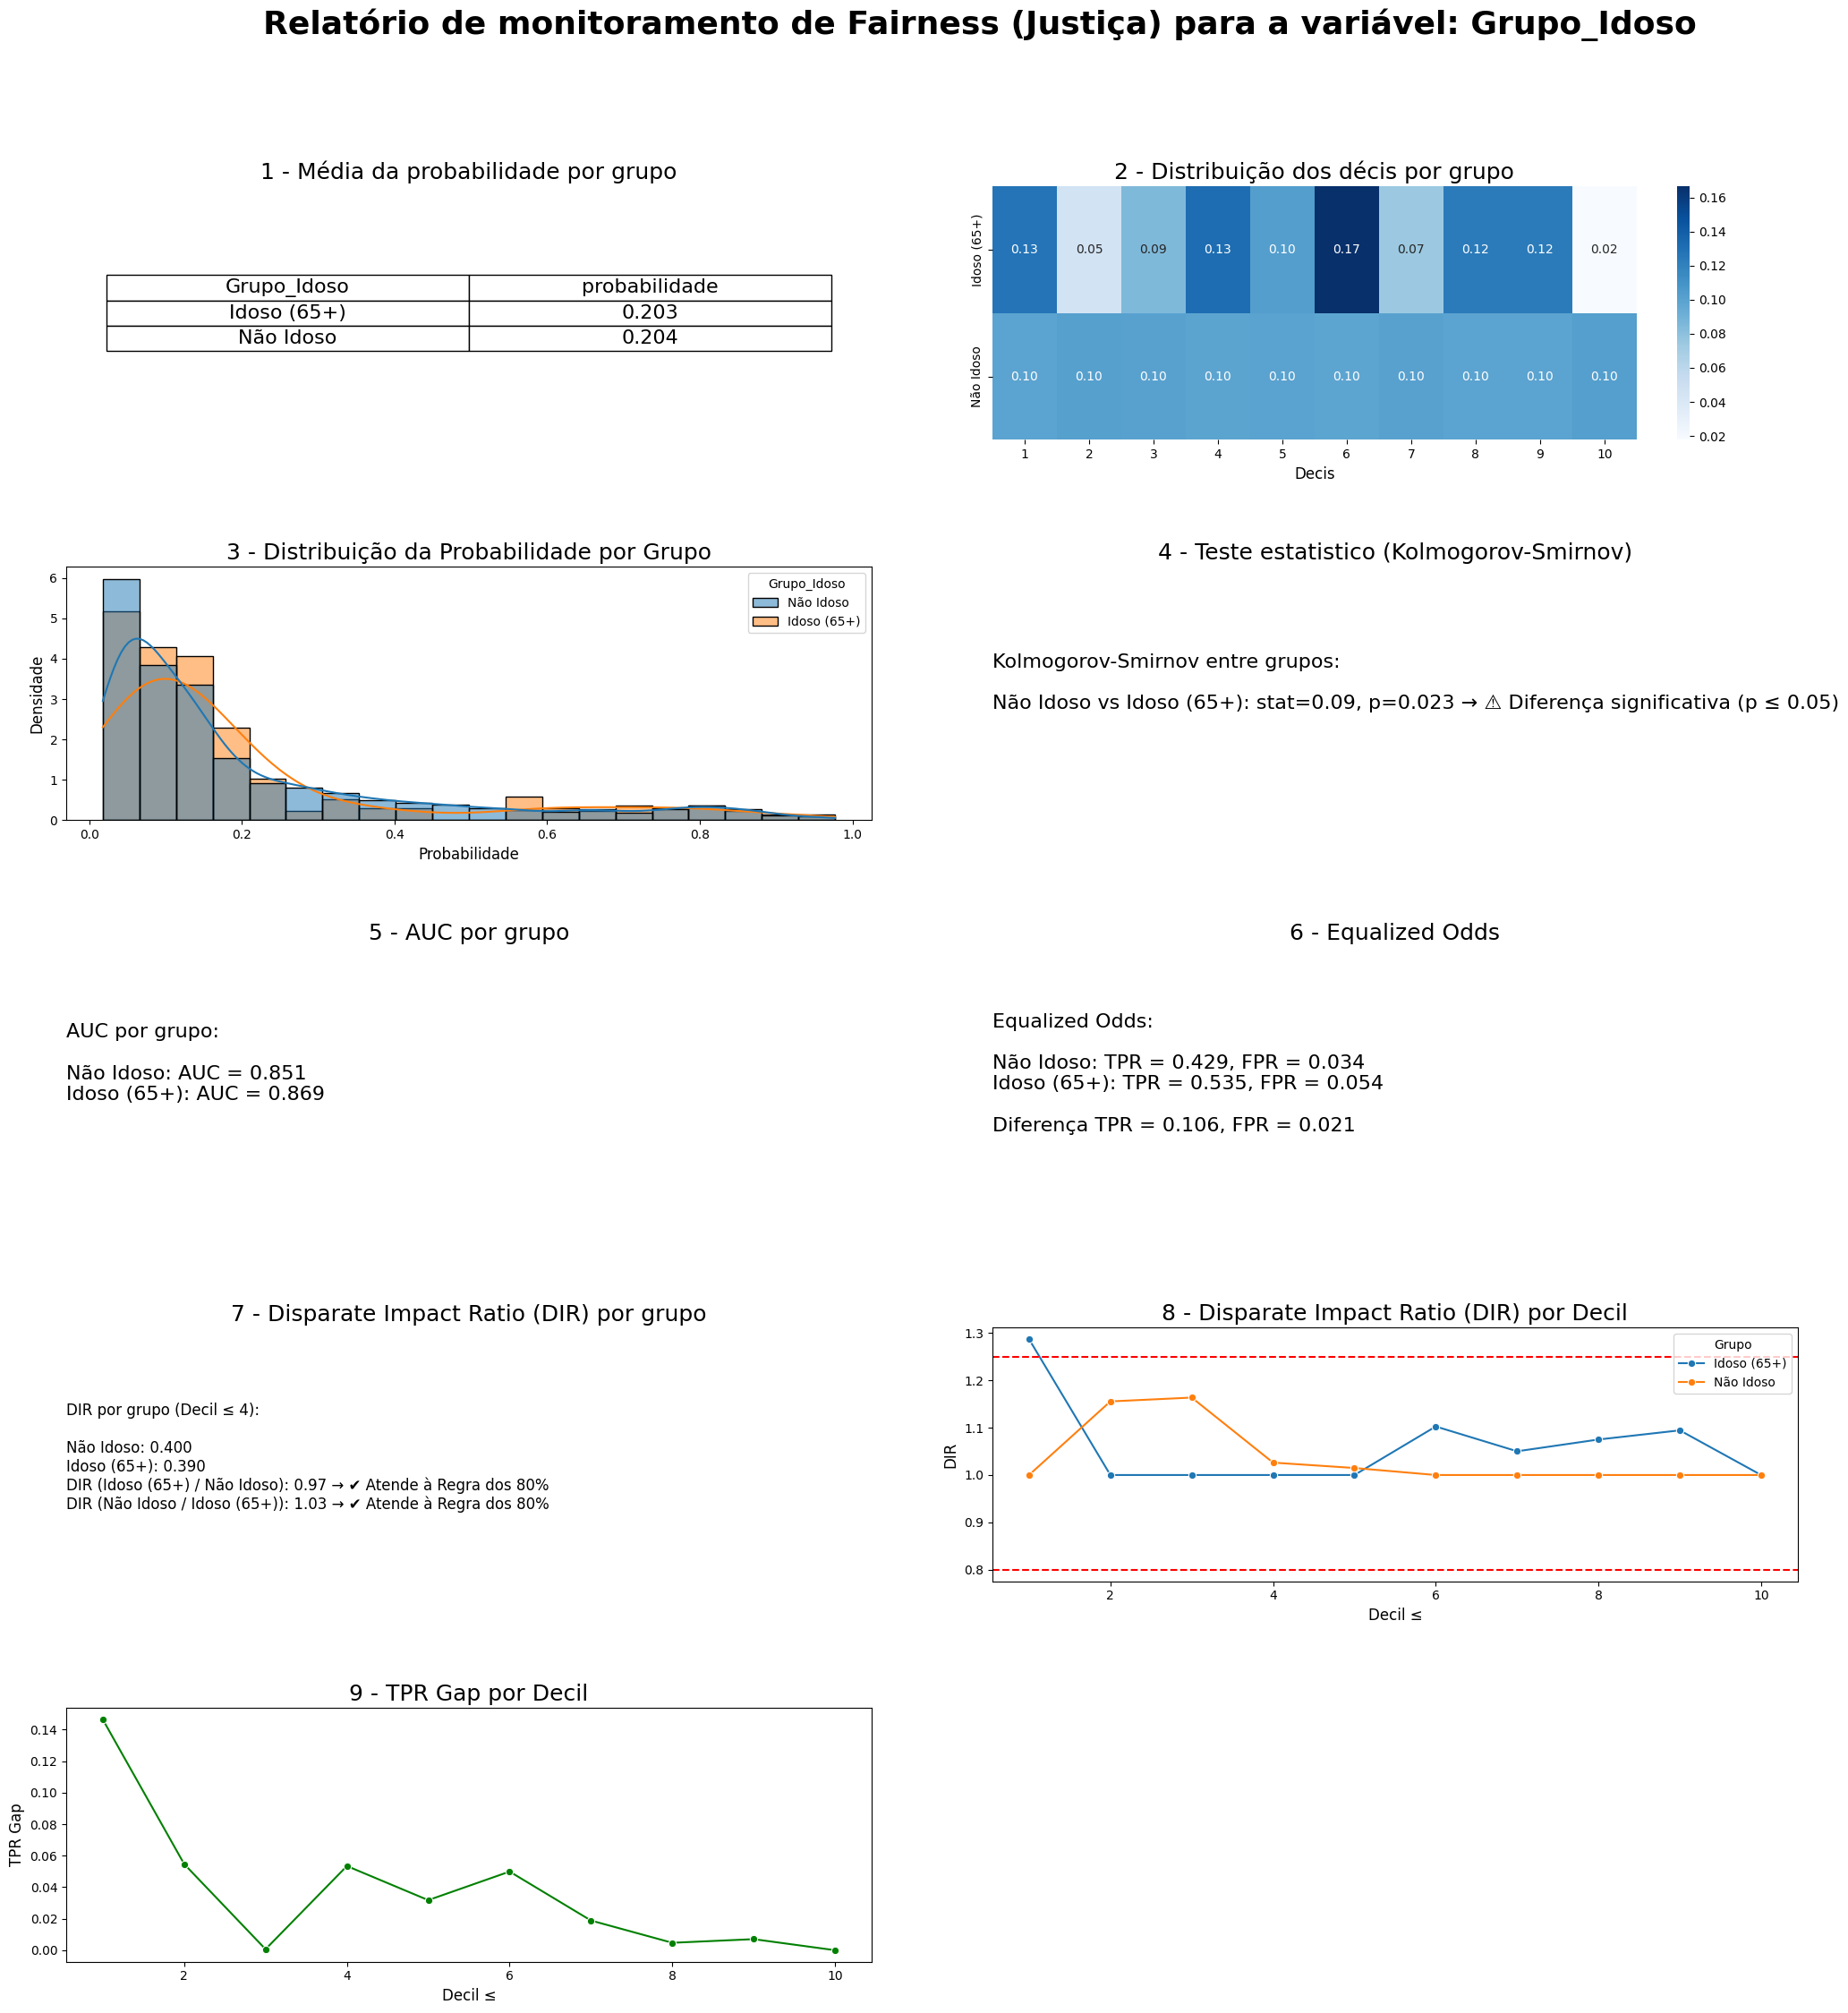

In [84]:
#chama a função de análise de justiça com as variáveis sensíveis
variaveis = ['Geography', 'Gender', 'Age']
executar_analise_justica(df_final, variaveis)


* **Geography**

    - **1 - Tabela da média das probabilidades por grupo:**
        A média da Alemanha é maior que a dos demais países, ou seja, seus clientes estão sendo rotulados com probabilidade média maior em relação aos outros grupos. Isso, por si só, não indica injustiça ou viés algorítmico, pois pode refletir o comportamento natural do evento: se de fato mais clientes desse país dão churn, o modelo aprenderá essa relação naturalmente.


    - **2 - Heatmap da distribuição dos decis por grupo:**
        Torna-se mais evidente onde ocorrem as concentrações de alta probabilidade para a Alemanha. O decil 1 para esse grupo tem maior concentração e permanece acima dos demais grupos até o decil 8, quando cai, indicando baixa concentração de clientes nos decis de menor probabilidade. Isso indica também que o grupo Alemanha está mais taxado como possível churn.

 
    - **3 - Histograma das probabilidades por grupo:** 
        Nas probabilidades mais baixas há pouca diferença, exceto pela menor quantidade de casos para a Alemanha, conforme visto. Porém, por volta da faixa de probabilidade 0,8 há um salto significativo em relação aos demais grupos para a Alemanha, indicando maior concentração nessa faixa, o que pode ser um comportamento normal do evento.


    - **4 - Teste estatístico Kolmogorov-Smirnov entre grupos:** 
        Indica que não há diferença significativa entre as distribuições de probabilidade da França e Espanha, sugerindo tratamento semelhante pelo modelo. No entanto, há diferenças estatisticamente significativas entre a Alemanha e os outros dois grupos, apontando para uma possível disparidade no comportamento do modelo — indicando viés algorítmico potencial contra ou a favor do grupo da Alemanha.


    - **5 - Texto com AUC por grupo:** 
        Os resultados da curva ROC AUC são praticamente os mesmos entre todos os países, indicando que não há indícios de viés em relação à separação geral entre as classes.


    - **6 - Texto com Equalized Odds (TPR/FPR) por grupo:** 
        Há pequenas diferenças entre os grupos no critério Equalized Odds, o que é positivo do ponto de vista da justiça. No entanto, a França apresenta desempenho levemente favorecido.


    - **7 - Texto com Disparate Impact Ratio (DIR) por grupo:** 
        O modelo atende ao critério de não-discriminação pelo Disparate Impact. As taxas de resultado positivo são razoavelmente equilibradas entre os países, e todos os pares respeitam a Regra dos 80%, que estabelece um limite aceitável de razão entre 0,80 e 1,25. Observa-se, porém, que o grupo Alemanha apresenta uma taxa 21% maior que a França e 17% maior que a Espanha para indivíduos classificados com decil ≤ 4, indicando uma leve vantagem relativa, embora dentro dos limites considerados aceitáveis.


    - **8 - Gráfico DIR por decil:** 
        Embora o modelo atenda à Regra dos 80% de forma agregada (como mostrado na análise anterior), a avaliação por decil revela que a justiça não é uniforme ao longo da distribuição de risco (decis). A injustiça está concentrada justamente onde o modelo é mais sensível — nos decis baixos, com maior probabilidade de churn. Isso indica que, apesar das medidas de reweighting para fairness aplicadas, ainda existem partes enviesadas nos decis. Seria necessário utilizar técnicas como a criação de modelos separados para cada grupo, focando o aprendizado individualmente em cada público e evitando que o modelo force um padrão do grupo majoritário sobre os demais.


    - **9 - Gráfico TPR Gap por decil:** 
        O TPR Gap mede a diferença na capacidade do modelo de acertar casos positivos entre grupos distintos. Em outras palavras, compara a sensibilidade (taxa de verdadeiros positivos) entre grupos, e uma diferença maior indica que o modelo está acertando mais em um grupo do que no outro, apontando possível viés. Observamos que o TPR Gap é mais elevado nos dois primeiros decis (cerca de 0,04), indicando que o modelo favorece um grupo na detecção dos casos de maior risco — justamente onde a precisão é mais crítica. Nos decis intermediários, o gap oscila moderadamente entre 0,005 e 0,025, e nos decis de menor risco (9 e 10) a diferença se aproxima de zero, mostrando maior equilíbrio. Esse padrão sugere que o modelo possui um viés relevante na identificação dos casos mais importantes, reforçando a necessidade de medidas além do reweighting para fairness, caso essa variável precise ser mantida no modelo. Mesmo que retirada, esse aspecto deve ser monitorado.

* **Resumo:**
Em termos gerais, a injustiça não é observada de forma global, mas ao analisar por decis, há faixas onde a injustiça do modelo para essa variável fica evidente. Em um cenário real, medidas específicas deveriam ser adotadas para manter essa variável, como o uso de modelos dedicados a país. **Neste trabalho, ela foi mantida pois apenas a métricas globais foram consideradas.**


* **Gender**

    - **1 - Tabela da média das probabilidades por grupo:**  
        A média das probabilidades para o sexo feminino é maior. Isso, por si só, não indica injustiça ou viés algorítmico, pois pode refletir o comportamento real do evento: se de fato mais clientes do sexo feminino dão churn, o modelo aprenderá essa relação naturalmente.

    - **2 - Heatmap da distribuição dos decis por grupo:**  
        Fica evidente que há maior concentração de probabilidades altas nos decis 1 e 2 para o grupo feminino, indicando que esse grupo é mais frequentemente classificado como de maior risco de churn.

    - **3 - Histograma das probabilidades por grupo:**  
        Há pouca diferença entre os grupos; ambos apresentam maior densidade em probabilidades baixas, o que é esperado em problemas desbalanceados. O grupo masculino tem leve maior densidade nas probabilidades mais baixas.

    - **4 - Teste estatístico Kolmogorov-Smirnov entre grupos:**  
        Existe diferença estatisticamente significativa entre as distribuições de probabilidade para homens e mulheres  (p-valor < 0.001, ou seja, menor que o limiar convencional de 0.05). Isso sugere que o modelo trata esses grupos de maneira distinta, o que pode indicar um viés algorítmico relacionado ao gênero.

    - **5 - Texto com AUC por grupo:**  
        Os resultados da curva ROC AUC são praticamente iguais entre os gêneros, indicando que não há indícios de viés em relação à capacidade de separação entre as classes.

    - **6 - Texto com Equalized Odds (TPR/FPR) por grupo:**  
        Há pequenas diferenças entre os grupos no critério Equalized Odds, o que é positivo do ponto de vista da justiça. Ainda assim, o grupo feminino apresenta um leve favorecimento na taxa de verdadeiros positivos (TPR).

    - **7 - Texto com Disparate Impact Ratio (DIR) por grupo:**  
        O modelo atende ao critério de não-discriminação pelo Disparate Impact. As taxas de resultado positivo são razoavelmente equilibradas entre os gêneros e respeitam a Regra dos 80%, que estabelece um limite aceitável de razão entre 0,80 e 1,25.

    - **8 - Gráfico DIR por decil:**  
        Embora o modelo atenda à Regra dos 80% de forma agregada, a avaliação por decil revela que a justiça não é uniforme ao longo da distribuição de risco. A maior disparidade ocorre no decil 1, onde há violação da regra dos 80%, mas nos decis seguintes a diferença diminui e se torna aceitável. Isso indica que, apesar das medidas de reweighting para fairness, ainda existe viés em parte da distribuição. Seria necessário utilizar técnicas como a criação de modelos separados para cada grupo, focando o aprendizado individualmente em cada gênero, para evitar que o padrão do grupo majoritário seja imposto ao outro.

    - **9 - Gráfico TPR Gap por decil:**  
        O TPR Gap mede a diferença na capacidade do modelo de acertar casos positivos entre os grupos. Observa-se que o TPR Gap começa baixo, aumenta até atingir o pico no decil 6 e depois diminui até o decil 10. Esse padrão evidencia que, embora o modelo pareça justo em média (como sugerido pela Equalized Odds), ele não mantém a equidade ao longo de toda a distribuição de risco.

* **Resumo:**  
Em termos gerais, a injustiça não é observada de forma global, mas ao analisar por decis, há faixas onde a injustiça do modelo para essa variável fica evidente. Em um cenário real, medidas específicas deveriam ser adotadas para manter essa variável, como o uso de modelos dedicados a cada gênero. **Neste trabalho, ela foi mantida pois apenas as métricas globais foram consideradas.**


**Grupo_Idoso**

- **1 - Tabela da média das probabilidades por grupo:**  
    As médias de probabilidade são praticamente iguais entre os grupos: 0,203 para idosos e 0,204 para não idosos. Essa proximidade indica que o modelo atribui risco de forma semelhante para ambos, não havendo sinal evidente de viés nessa métrica.

- **2 - Heatmap da distribuição dos decis por grupo:**  
    A distribuição entre os decis é bastante equilibrada entre os grupos. Não há concentração atípica de idosos ou não idosos nos decis de maior ou menor risco (há um leve aumento no decil 6 para idosos), o que reforça a consistência do modelo na classificação de ambos os grupos.

- **3 - Histograma das probabilidades por grupo:**  
    A distribuição de probabilidades entre idosos e não idosos é semelhante, com padrão típico de problemas desbalanceados (maior concentração em valores baixos). Há leve sobreposição das curvas, mas sem desvios evidentes que sugiram favoritismo ou viés.

- **4 - Teste estatístico Kolmogorov-Smirnov entre grupos:**  
    Há diferença estatisticamente significativa entre as distribuições de probabilidade dos grupos (stat=0,09, p=0,023). Como o p-valor é menor que 0,05, rejeita-se a hipótese de que as distribuições são iguais, sugerindo que o modelo trata idosos e não idosos de maneira distinta, o que pode indicar um viés algorítmico relacionado ao grupo idoso.

- **5 - Texto com AUC por grupo:**  
    Os resultados da curva ROC AUC são praticamente iguais entre os grupos, indicando que não há indícios de viés em relação à capacidade de separação entre as classes.

- **6 - Texto com Equalized Odds (TPR/FPR) por grupo:**  
    A métrica mostra uma diferença de 0,106 em TPR (idosos: 0,535 vs. não idosos: 0,429) e 0,021 em FPR. Isso indica que o modelo está mais sensível para identificar corretamente casos positivos no grupo idoso (TPR maior), mas com leve aumento na taxa de falsos positivos (FPR). Apesar de aceitável, essa diferença sugere um leve favorecimento ao grupo idoso.

- **7 - Texto com Disparate Impact Ratio (DIR) por grupo:**  
    O modelo atende ao critério de não discriminação pelo Disparate Impact. As taxas de resultado positivo são razoavelmente equilibradas entre os grupos e respeitam a Regra dos 80%, que estabelece um limite aceitável de razão entre 0,80 e 1,25.

- **8 - Gráfico DIR por decil:**  
    Embora o modelo atenda à Regra dos 80% de forma agregada, a avaliação por decil revela que a justiça não é uniforme ao longo da distribuição de risco. A maior disparidade ocorre no decil 1, onde há violação da regra dos 80%, mas nos decis seguintes a diferença diminui e se torna aceitável. Isso indica que, apesar das medidas de reweighting para fairness, ainda existe viés em parte da distribuição.

- **9 - Gráfico TPR Gap por decil:**  
    O TPR Gap mede a diferença na capacidade do modelo de acertar casos positivos entre os grupos. Observa-se que o TPR Gap começa alto e diminui a partir do decil 2, mantendo-se estável e até caindo ainda mais nos decis finais. Esse padrão evidencia que, embora o modelo pareça justo em média (como sugerido pela Equalized Odds), ele não mantém a equidade ao longo de toda a distribuição de risco, principalmente no decil mais sensível, o 1, de maior probabilidade de churn.

* **Resumo:**  
Em termos gerais, a injustiça não é observada de forma global, mas ao analisar por decis, há faixas onde a injustiça do modelo para essa variável fica evidente. Em um cenário real, medidas específicas deveriam ser adotadas para manter essa variável, como o uso de modelos dedicados a cada grupo e, em casos extremos, a remoção da variável de idade no modelo. **Neste trabalho, ela foi mantida pois apenas as métricas globais foram consideradas.**
